## Treg heterogeneity paper heatmaps (with non Tregs)

In [56]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(patchwork)
    library(harmony)
    library(entropy)
    library(presto)
    library(singlecellmethods)
    library(lme4)
    library(purrr)
    library(pheatmap)
    library(rcna)
    library(glue)
    library(ggthemes)
})

source("utils.r")
source("myfun.r")

In [8]:
treg.path <-"/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.rds"
marker_genes_path <- "/data/brennerlab/Shani/projects/Treg/analysis/Heatmaps_markers.csv"
saving.path <- "/data/brennerlab/Shani/projects/Treg/analysis/integrated/"

In [59]:
cell.state.colors <- c(cell.state.colors.v2, list(group = c(`C1.Naïve` = "#4E79A7",
                                          `C3.CD25high` = "#F28E2B",
                                          `C4.CD25highCXCR6` = "#FFBE7D",
                                          `C5.AREG` = "#59A14F",
                                          `C6.TNFa` = "#8CD17D",
                                          `C7.CD161` = "#B6992D",
                                          `C8.ISGhigh` = "#F1CE63",
                                          `C9.GZM` = "#499894",
                                          `C10.Prolif` = "#86BCB6",
                                          `X1.canonical.Treg.markers` = "#D4A6C8",
                                          `X2.Expected.low` = "#D7B5A6")))

In [4]:
merged <- readRDS(treg.path)
merged

An object of class Seurat 
38406 features across 18909 samples within 3 assays 
Active assay: RNA (38224 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ADT, HTO
 3 dimensional reductions calculated: pca, harmony, humap

In [5]:
merged$cell.states %>% unique()
merged$tissue %>% unique()

[1] CD25hiTNFAIP3pos Treg CD25hiCXCR6neg Treg   ISG Treg             
 [4] CD25loAREGpos Treg    Naive Treg            CD161posmem. Treg    
 [7] CD25hiCXCR6pos Treg   CD25int Treg          Prolif.              
[10] GZM Treg             
10 Levels: Naive Treg CD25int Treg CD25hiCXCR6neg Treg ... Prolif.

[1] RA.Syn.Tissue RA.Blood      RA.Syn.Fluid  HD.Blood     
Levels: HD.Blood RA.Blood RA.Syn.Fluid RA.Syn.Tissue

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


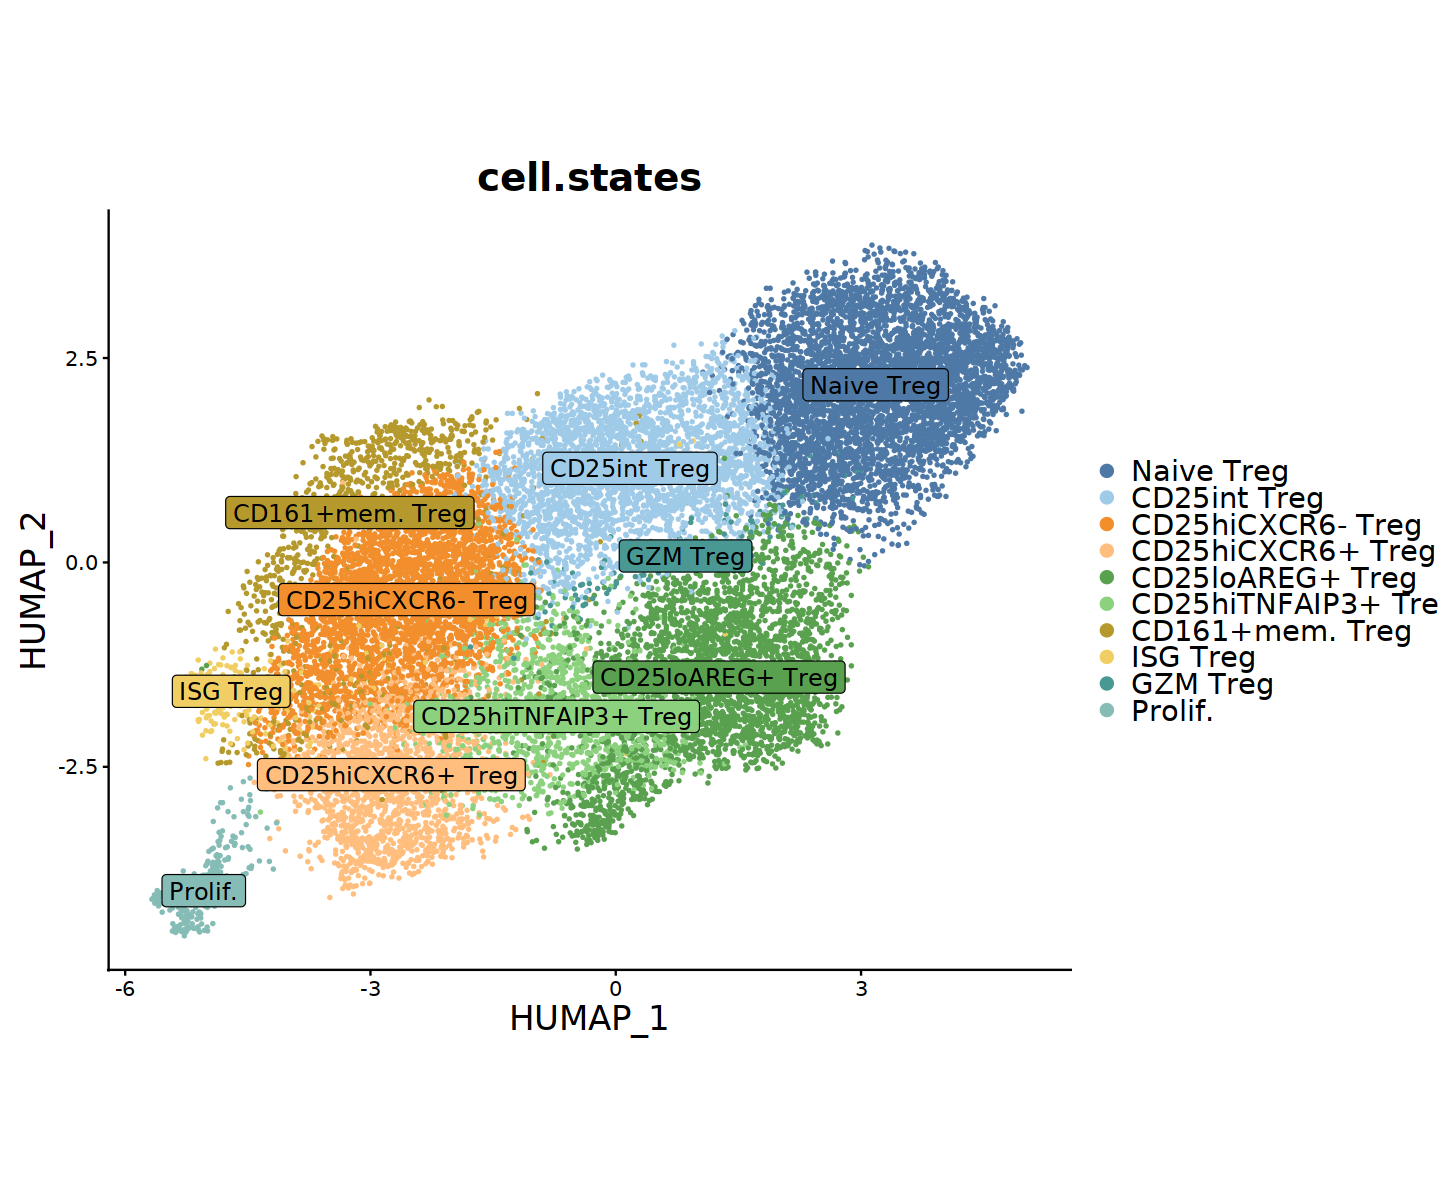

In [6]:
fig.size(10,12)
Idents(merged) <- "cell.states"


DimPlot(merged, group.by = "cell.states", label = T, label.box = T, reduction = "humap",
        shuffle = T, label.size = 5, pt.size = 0.5) + 
    theme(text = element_text(size = 20)) + scale_fill_manual(values = cell.state.colors$cell.states) +
    scale_color_manual(values = cell.state.colors$cell.states) + coord_fixed()

### Load AMP data

In [7]:
data.path <- "/data/brennerlab/AMP_Phase_2/Data/Processed_single_cell_data/processed_output_04-11-2023/"
T.metadata.p <- paste0(data.path, "T_reference.rds")
T.uwot.p <- paste0(data.path, "T_uwot_model")
all.qc.p <- paste0(data.path, "qc_mRNA_314011cells_log_normalized_matrix.rds")
all.qc.prot.p <- paste0(data.path, "qc_protein_CLR_normalized_filtered_matrix.rds")
all.raw.counts <- paste0(data.path, "raw_mRNA_count_matrix.rds")
all.raw.counts.prot <- paste0(data.path, "raw_protein_count_matrix.rds")
CTAP.path <- paste0(data.path, "CTAP_donor_mapping.xlsx")
donor.meta.data <- "/data/brennerlab/Shani/projects/AMP_Phase_2/treatment assigned metadata_clin_donor_singlecell.csv"

In [8]:
amp_ref <- readRDS(T.metadata.p)
amp_meta <- amp_ref$meta_data

In [9]:
# load counts and qc counts
amp_counts <- readRDS(all.raw.counts)

In [10]:
#filter counts to to include T cells only by metadata
cells <- amp_meta$cell
amp_counts <- amp_counts[,cells]

In [11]:
meta <- amp_meta %>% tibble::remove_rownames()%>% tibble::column_to_rownames(var = "cell")
amp <- CreateSeuratObject(counts = amp_counts, meta.data = meta, project = "AMPII")


In [12]:
donor.meta <- read.csv(donor.meta.data)
merged.meta <- amp@meta.data%>% left_join(donor.meta, by =join_by("orig.ident" == "mRNA_run"))
head(merged.meta, 3)

orig.ident nCount_RNA nFeature_RNA sample  cluster                  cell_type
1 BRI-399    7560       2157         BRI-399 T-6: CD4+ memory         T cell   
2 BRI-399    2563       1171         BRI-399 T-5: CD4+ GZMK+ memory   T cell   
3 BRI-399    4922       1741         BRI-399 T-8: CD4+ CD25-high Treg T cell   
  donor   fibro Tfilter nUMI ⋯ sex    age CDAI disease_duration tissue_type 
1 BRI-399 TRUE  FALSE   7560 ⋯ Female 70       NA               Arthroplasty
2 BRI-399 TRUE  FALSE   2563 ⋯ Female 70       NA               Arthroplasty
3 BRI-399 TRUE  FALSE   4922 ⋯ Female 70       NA               Arthroplasty
  krenn_inflammation single_cell_tech                cell_count_to_10x
1 NA                 CITEseq + flow/bulk + re-freeze 15,000           
2 NA                 CITEseq + flow/bulk + re-freeze 15,000           
3 NA                 CITEseq + flow/bulk + re-freeze 15,000           
  protein_run atac_run
1 BRI-400     BRI-448 
2 BRI-400     BRI-448 
3 BRI-400     BRI-448

In [13]:
#Add metadata
amp <- AddMetaData(amp, merged.meta$age, "age")
amp <- AddMetaData(amp, merged.meta$sex, "sex")
amp <- AddMetaData(amp, merged.meta$treatment, "treatment")
amp <- AddMetaData(amp, merged.meta$CDAI, "CDAI")
amp <- AddMetaData(amp, merged.meta$disease_duration, "disease.duration")
amp <- AddMetaData(amp, merged.meta$tissue_type, "tissue.type")
amp <- AddMetaData(amp, merged.meta$krenn_inflammation, "krenn")
amp <- AddMetaData(amp, merged.meta$subject_id, "subject_id")
amp <- AddMetaData(amp, "AMP2", "orig.ident")
amp <- AddMetaData(amp, "RA.Syn.Tissue", "tissue")

In [14]:
Idents(amp) <- "treatment"
amp <- subset(amp, idents = c("OA", "Repeat"), invert = T)

In [15]:
unique(amp$treatment)

[1] "Naïve"                "methotrexate failure" "TNF failure"

In [16]:
#filter naive and memory CD4 T
naive <- "T-4: CD4+ naive"
memory <- c("T-6: CD4+ memory", "T-2: CD4+ IL7R+CCR5+ memory", "T-0: CD4+ IL7R+ memory", "T-1: CD4+ CD161+ memory")

In [17]:
Idents(amp) <- "cluster"
amp.subset <- subset(amp, idents = c(naive, memory)) 

## merge datasets

In [18]:
merged <- merge(merged, amp.subset)

In [19]:
#remove other amp
rm(amp, amp_ref)

In [20]:
unique(merged$cluster_name)
unique(merged$orig.ident)

[1] "T-8: CD4+ CD25-high Treg"    "T-9: CD4+ CD25-low Treg"    
[3] "T-18: Proliferating"         NA                           
[5] "T-4: CD4+ naive"             "T-6: CD4+ memory"           
[7] "T-1: CD4+ CD161+ memory"     "T-2: CD4+ IL7R+CCR5+ memory"
[9] "T-0: CD4+ IL7R+ memory"

[1] "AMP2"   "AMPrep" "SF.BL"  "HD_Luo"

In [21]:
merged@meta.data <- merged@meta.data %>% mutate(cell.states = if_else(merged$cluster_name %in% memory, "Memory CD4 T", 
                                                  if_else(merged$cluster_name %in% naive, "Naive CD4 T", cell.states)))

In [22]:
merged$cell.states %>% tail

BRI-619_GACATCACAAGGTCTT BRI-619_GTTAGTGGTCTAACTG BRI-619_TACGGTAAGCCTGGAA 
          "Memory CD4 T"           "Memory CD4 T"           "Memory CD4 T" 
BRI-619_TCCATCGGTGAGATCG BRI-619_TGAATGCGTACGAGTG BRI-625_TCATTACTCTATTGTC 
          "Memory CD4 T"           "Memory CD4 T"           "Memory CD4 T"

## Normalize and scale

In [23]:
merged <- merged %>% 
        NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000) %>% 
        ScaleData()%>% 
        FindVariableFeatures(selection.method = "vst", nfeatures = 2000) 

Centering and scaling data matrix



In [24]:
merged$cell.states <- factor(merged$cell.states, levels = c('Naive CD4 T',
                                                            'Memory CD4 T',
                                                            ordered.levels))

In [30]:
#save RDS
# saveRDS(merged, "/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.wOtherCD4.rds")
merged <- readRDS("/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.wOtherCD4.rds")

In [31]:
merged

An object of class Seurat 
38406 features across 49473 samples within 3 assays 
Active assay: RNA (38224 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ADT, HTO

In [32]:
merged$cell.states %>% unique()

[1] CD25hiTNFAIP3+ Treg CD25hiCXCR6- Treg   ISG Treg           
 [4] CD25loAREG+ Treg    Naive Treg          CD161+mem. Treg    
 [7] CD25hiCXCR6+ Treg   CD25int Treg        Prolif.            
[10] GZM Treg            Naive CD4 T         Memory CD4 T       
12 Levels: Naive CD4 T Memory CD4 T Naive Treg ... Prolif.

In [33]:
cell.states.renaming <- as.character(merged$cell.states)
cell.states.renaming[cell.states.renaming == "CD25hiCXCR6- Treg"] <- "CD25hiCXCR6neg Treg"
cell.states.renaming[cell.states.renaming == "CD25hiCXCR6+ Treg"] <- "CD25hiCXCR6pos Treg"
cell.states.renaming[cell.states.renaming == "CD25loAREG+ Treg"] <- "CD25loAREGpos Treg"
cell.states.renaming[cell.states.renaming == "CD25hiTNFAIP3+ Treg"] <- "CD25hiTNFAIP3pos Treg"
cell.states.renaming[cell.states.renaming == "CD161+mem. Treg"] <- "CD161posmem. Treg"

merged <- AddMetaData(merged, cell.states.renaming, "cell.states")

ordered.levels = c("Naive CD4 T",
                   "Memory CD4 T",
                   "Naive Treg",
                   "CD25int Treg",
                   "CD25hiCXCR6neg Treg",
                   "CD25hiCXCR6pos Treg",
                   "CD25loAREGpos Treg",
                   "CD25hiTNFAIP3pos Treg",
                   "CD161posmem. Treg",
                   "ISG Treg",
                   "GZM Treg",
                   "Prolif.")
merged$cell.states <- factor(merged$cell.states, levels = ordered.levels)

In [55]:
merged$tissue %>% unique

[1] "RA.Syn.Tissue" "RA.Blood"      "RA.Syn.Fluid"  "HD.Blood"

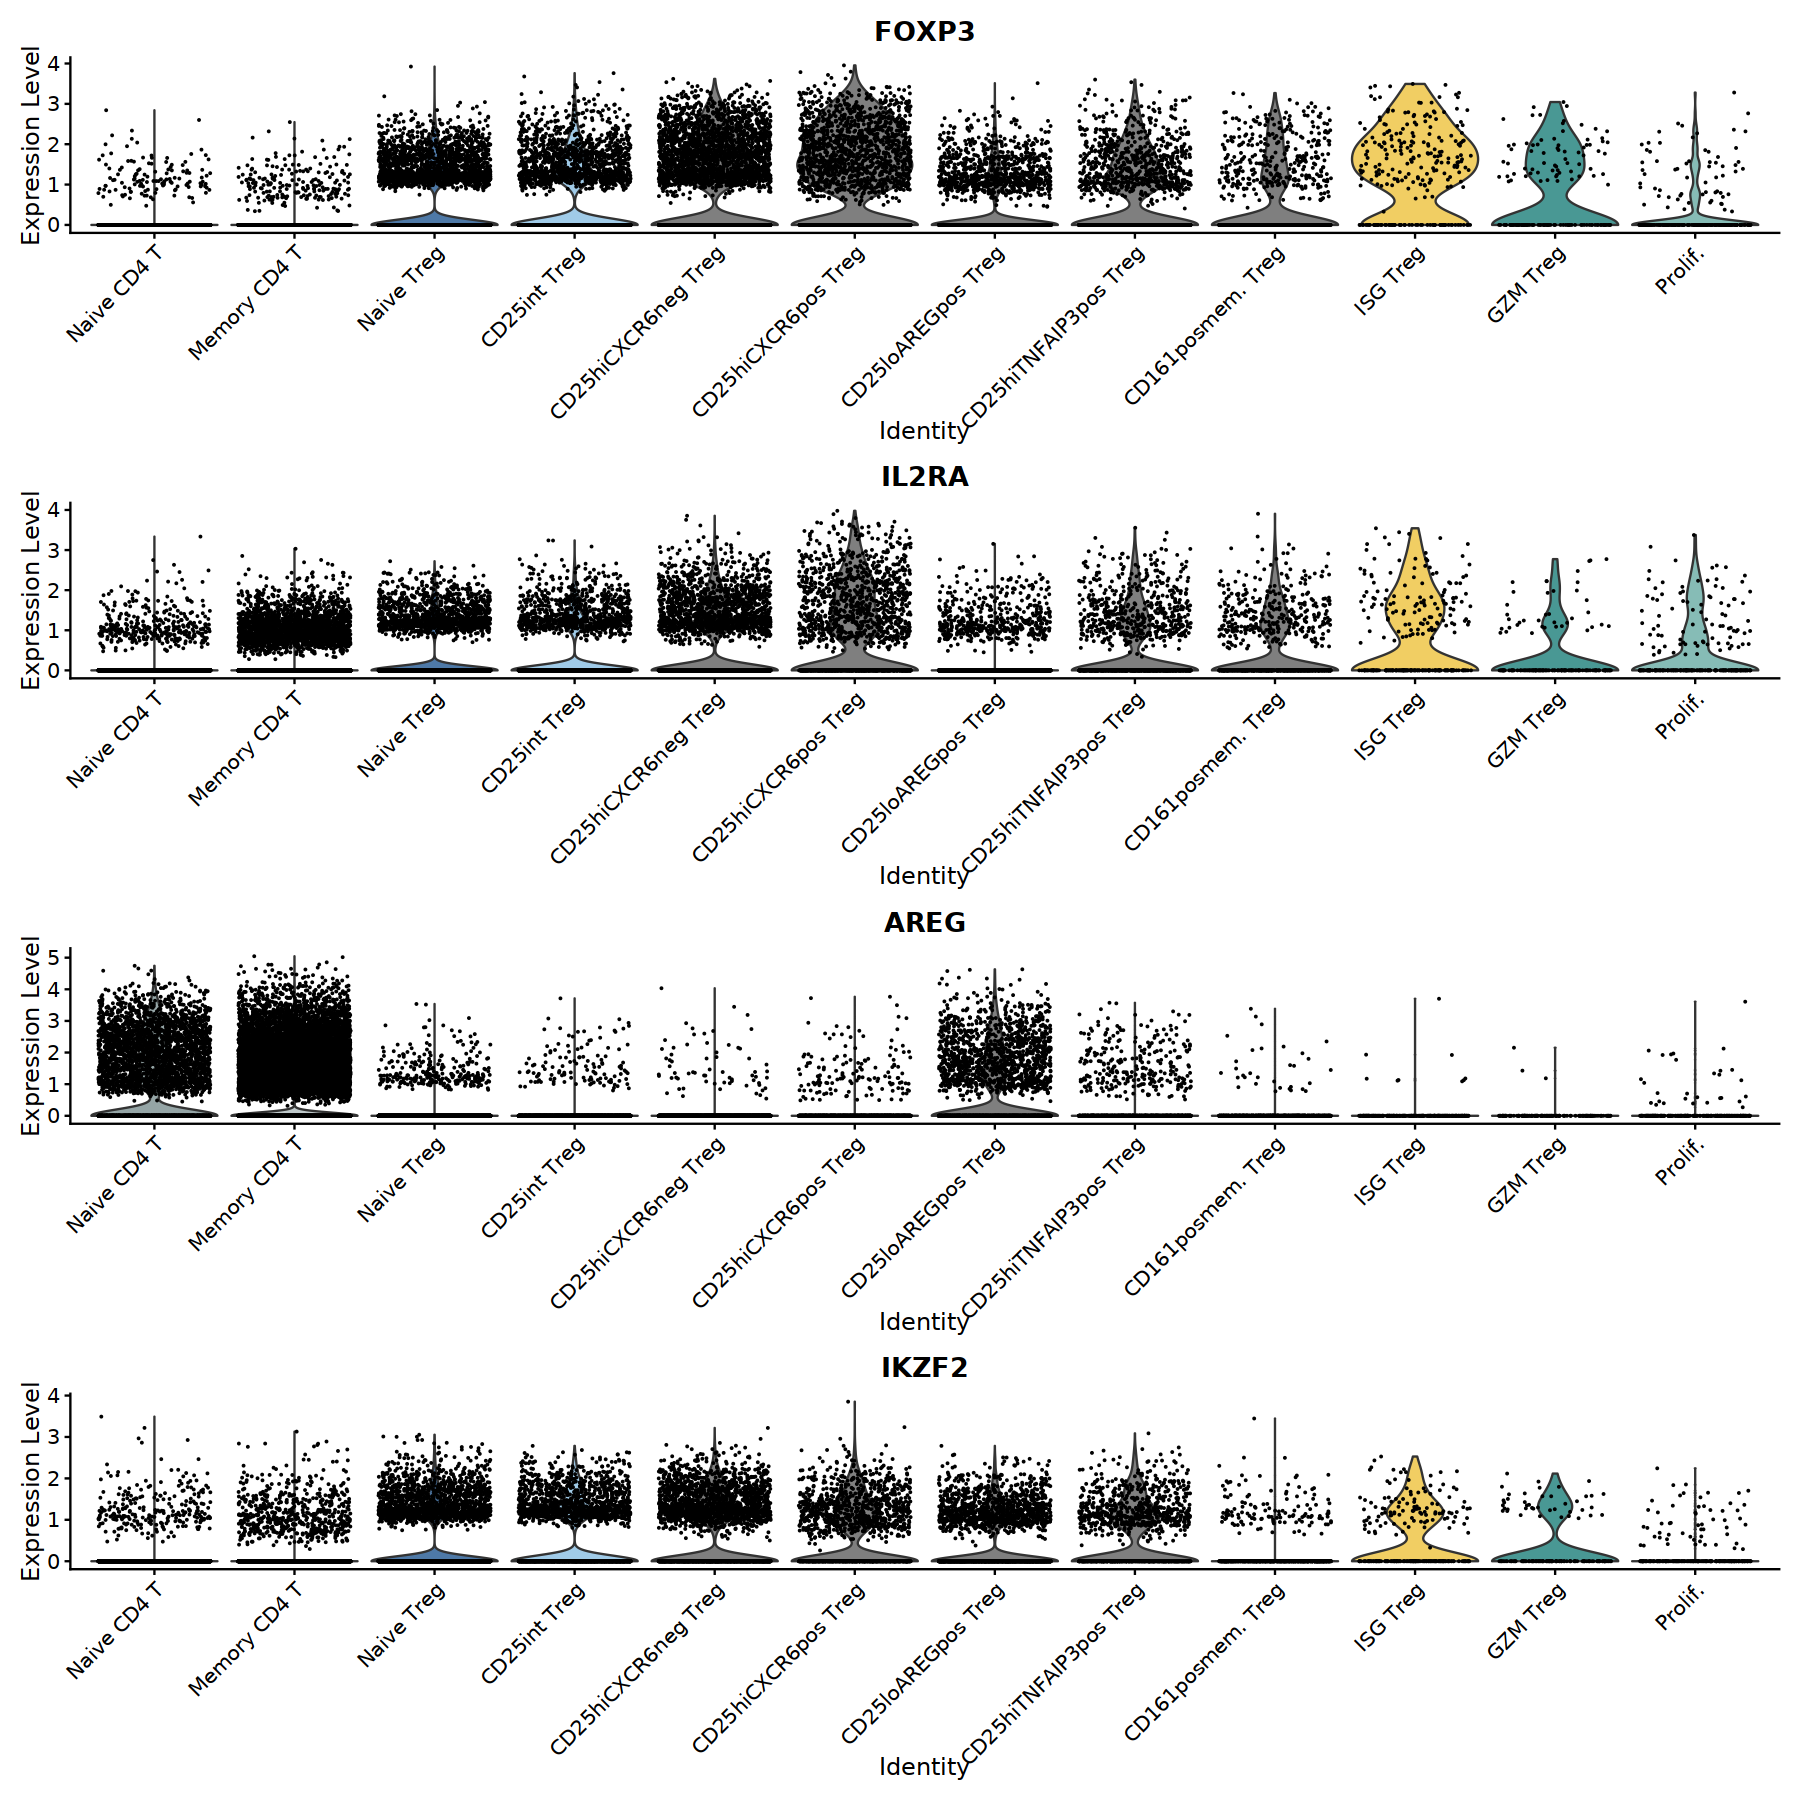

In [34]:
fig.size(15, 15)
VlnPlot(merged, features = c("FOXP3", "IL2RA", "AREG", "IKZF2"), group.by = "cell.states", ncol = 1, cols = cell.state.colors$cell.states)

pdf 
  2

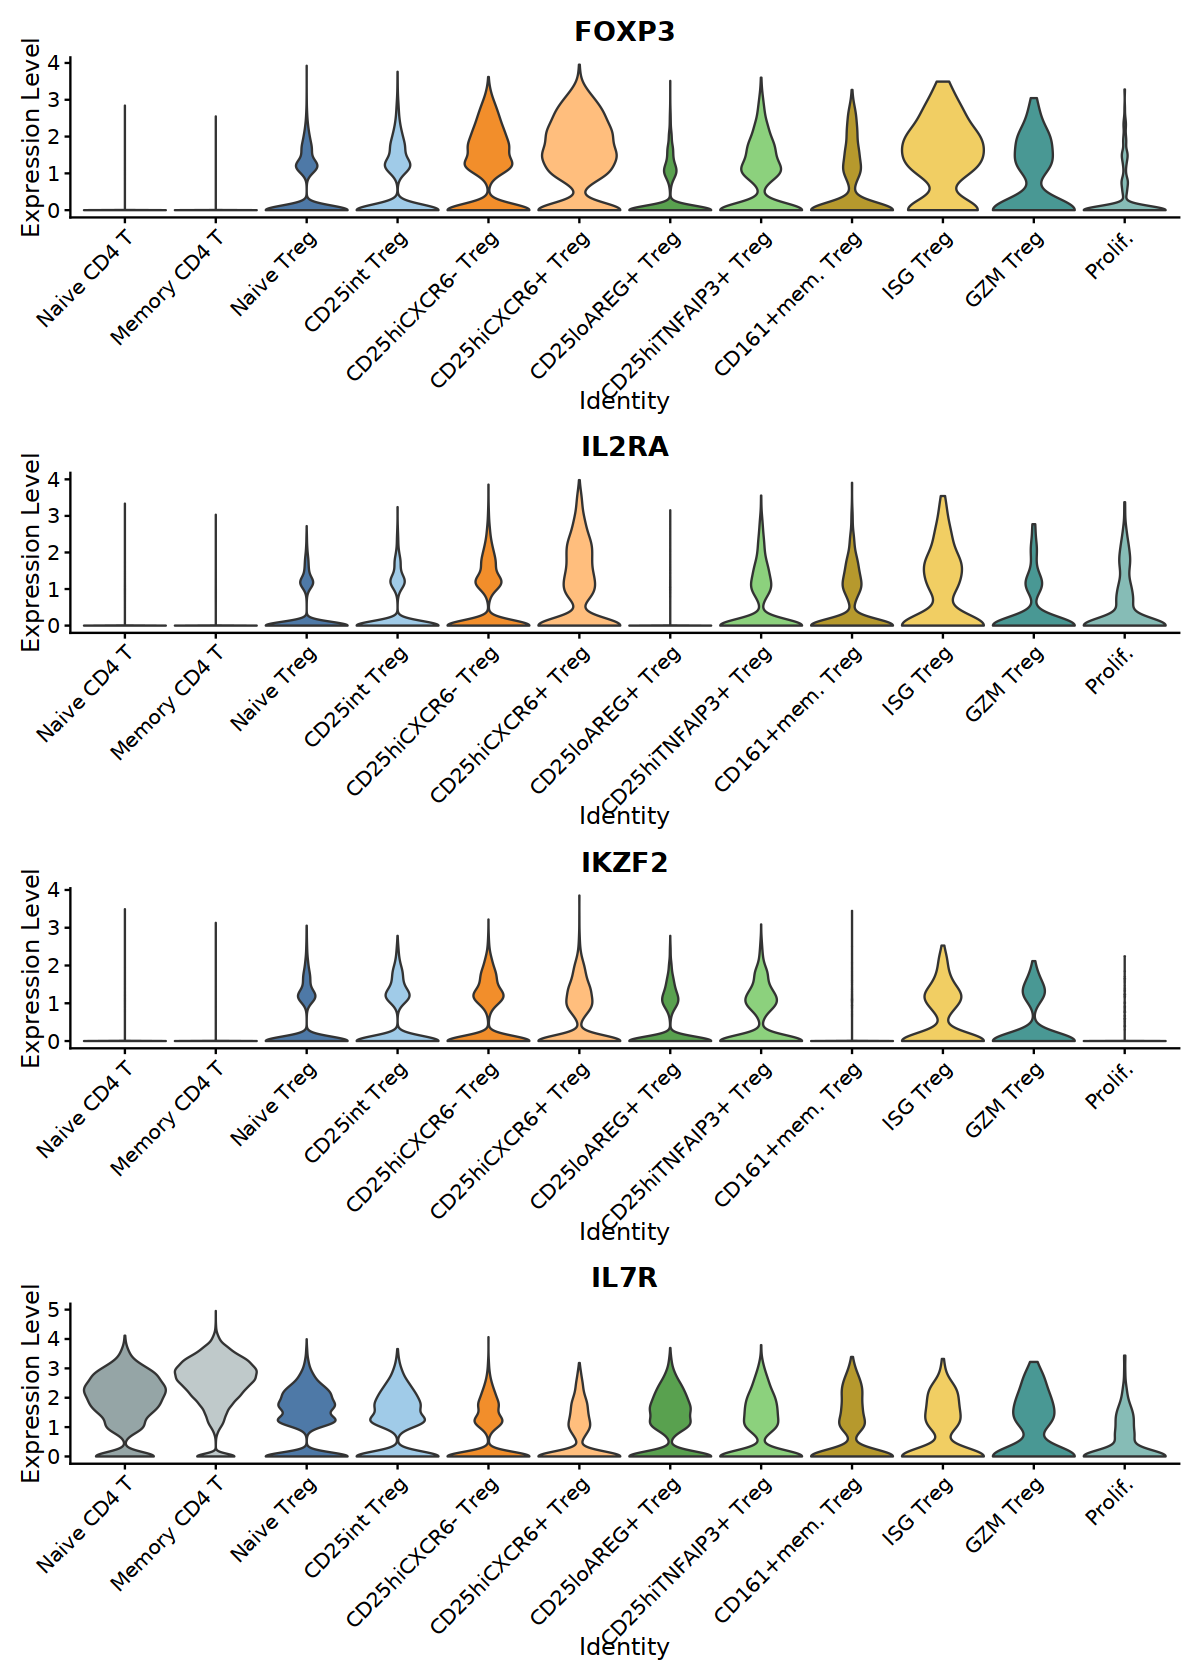

In [28]:
fig.size(14, 10)
pdf(file = paste(saving.path, "Figures/Fig1H.CanonicalMarkers.Vln.pdf", sep = ''),
    width = 10, 
    height = 12)

vln <- VlnPlot(merged, features = c("FOXP3", "IL2RA", "IKZF2", "IL7R"), group.by = "cell.states", ncol = 1, pt.size = 0, cols = cell.state.colors$cell.states) 
vln
dev.off()
vln


saveRDS(vln, paste(saving.path, "Figures/Fig1H.rds", sep = ''))

In [14]:
#markers for plotting
markers <- read.csv(marker_genes_path)
markers

X1.canonical.Treg.markers X2.Expected.low X3.supression.markers
1  CD4                       IL7R            ENTPD1               
2  FOXP3                                     ICOS                 
3  IL2RA                                     TNFRSF9              
4  IKZF2                                     IL10                 
5                                            TNFRSF4              
6                                            TGFB1                
7                                            TIGIT                
8                                            CTLA4                
9                                            TNFRSF18             
10                                           LAG3                 
11                                           PDCD1                
   X4.Chemokine.receptors X5.Tissue.resident X6.Fully.Differentiated.T X7.naïve
1  CCR4                   CD69               BATF                      TCF7    
2  CCR7                   CXCR6              KLRG1                     CCR7    
3  CXCR4                  ITGAE              PRDM1                     LEF1    
4  CXCR3                  ITGA1              HLA-DRA                   SELL    
5  CXCR6                  RUNX3                                                
6  CCR6                                                                        
7  CXCR5                                                                       
8                                                                              
9                                                                              
10                                                                             
11                                                                             
   C1.Naïve C2.CD25inter C3.CD25high C4.CD25highCXCR6 C5.AREG C6.TNFa C7.CD161
1  CCR7     CCR7         IKZF2       CXCR6            AREG    TNFAIP3 KLRB1   
2  TCF7     TCF7         CD52        TIGIT            CXCR4   KLF6    GSTK1   
3  EEF1B2   EEF1B2       CD74        LAG3             NR3C1   CXCR4           
4  TXNIP    TXNIP        IL32        TNFRSF18         NR4A2   CREM            
5  RPL32    RPL32                    TNFRSF4          SOCS1   DUSP1           
6  LEF1     LEF1                     MAF              FOS                     
7                                                     JUN                     
8                                                                             
9                                                                             
10                                                                            
11                                                                            
   C8.ISGhigh C9.GZM C10.Prolif
1  LY6E       GZMK   MKI67     
2  ISG15      GZMA   TUBA1B    
3  MX1        GZMB   STMN1     
4  IFI6                        
5                              
6                              
7                              
8                              
9                              
10                             
11

In [15]:
markers.p <- markers %>% tidyr::pivot_longer(cols = colnames(.), names_to = "group", values_to = "gene") %>% 
                filter(gene != "") %>% arrange(group)
markers.p$group <- factor(markers.p$group, levels = c('C1.Naïve',
                                                      'C2.CD25inter',
                                                      'C3.CD25high',
                                                      'C4.CD25highCXCR6',
                                                      'C5.AREG',
                                                      'C6.TNFa',
                                                      'C7.CD161',
                                                      'C8.ISGhigh',
                                                      'C9.GZM',
                                                      'C10.Prolif',
                                                      'X1.canonical.Treg.markers',
                                                      'X2.Expected.low',
                                                      'X3.supression.markers',
                                                      'X4.Chemokine.receptors',
                                                      'X5.Tissue.resident',
                                                      'X6.Fully.Differentiated.T',
                                                      'X7.naïve'))
markers.p <- markers.p %>% arrange(group)
markers.p %>% head

group    gene  
1 C1.Naïve CCR7  
2 C1.Naïve TCF7  
3 C1.Naïve EEF1B2
4 C1.Naïve TXNIP 
5 C1.Naïve RPL32 
6 C1.Naïve LEF1

In [30]:
dim(markers.p)

[1] 82  2

In [45]:
collapsed.counts <- presto::collapse_counts(merged@assays$RNA@counts, 
                        merged@meta.data, 
                        c("cell.states", "tissue", "orig.ident"))

CAREFUL: get_norm makes very strong assumptions about data



## Cluster markers scaled heatmaps

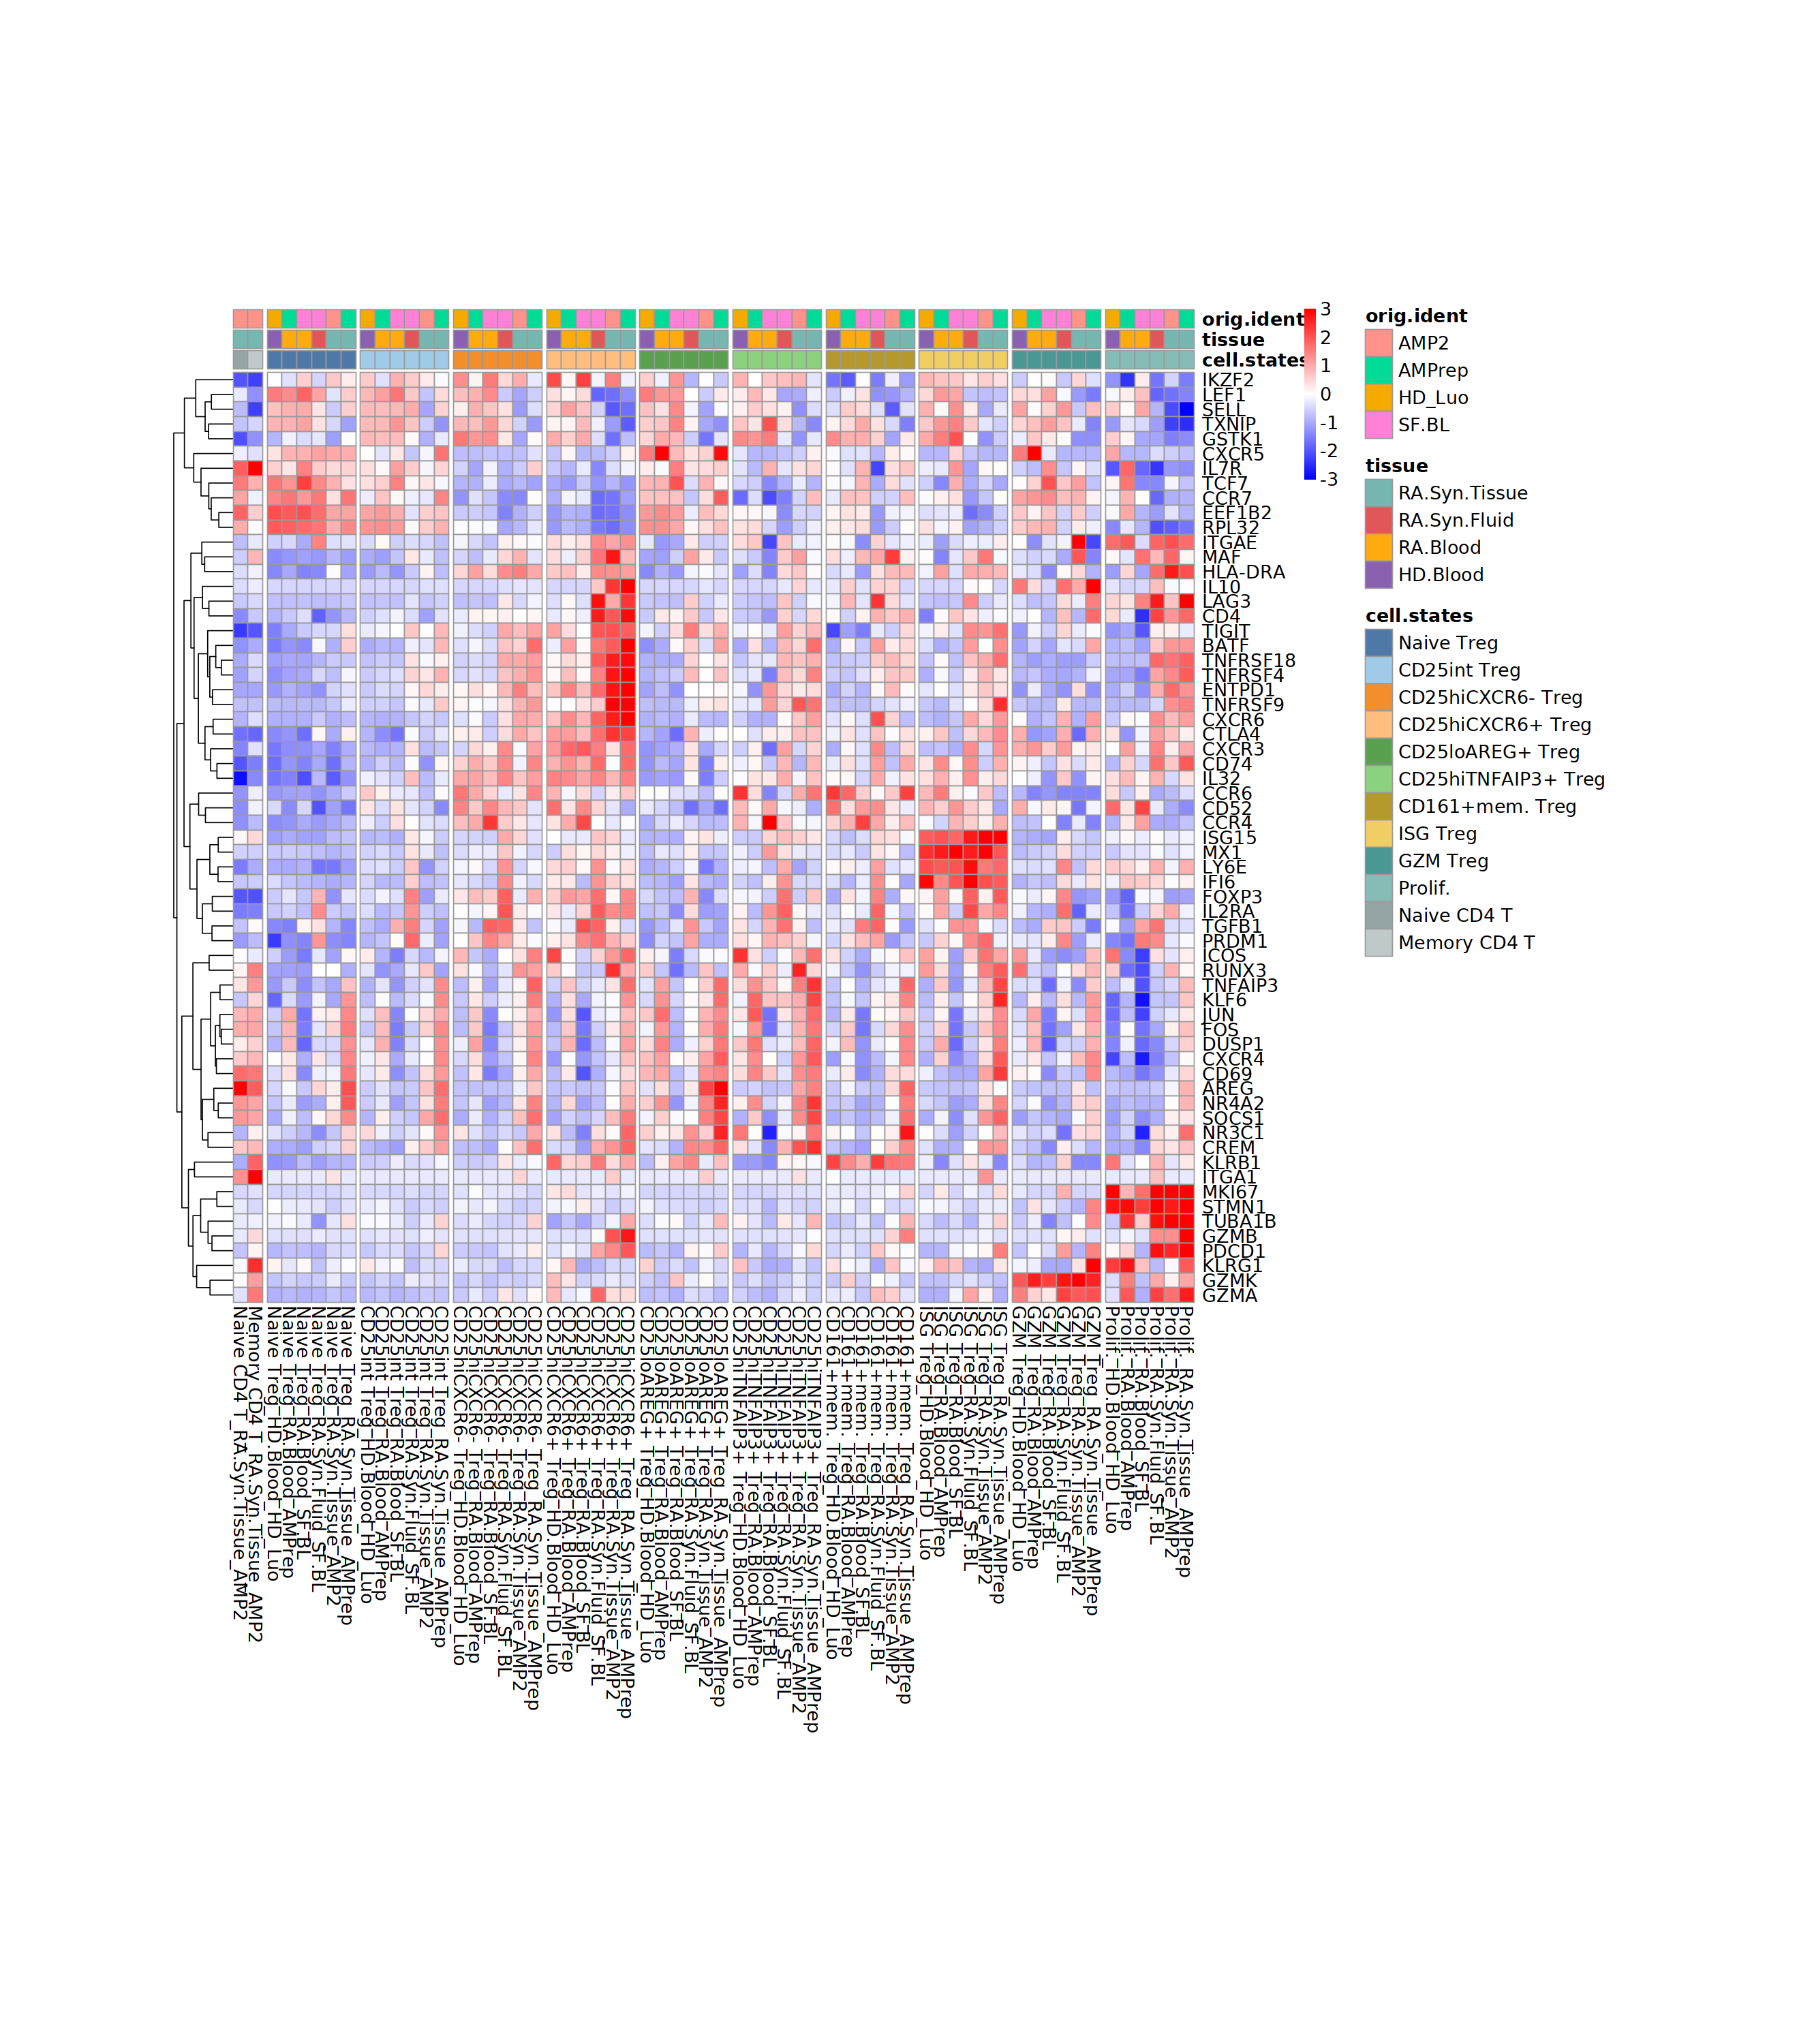

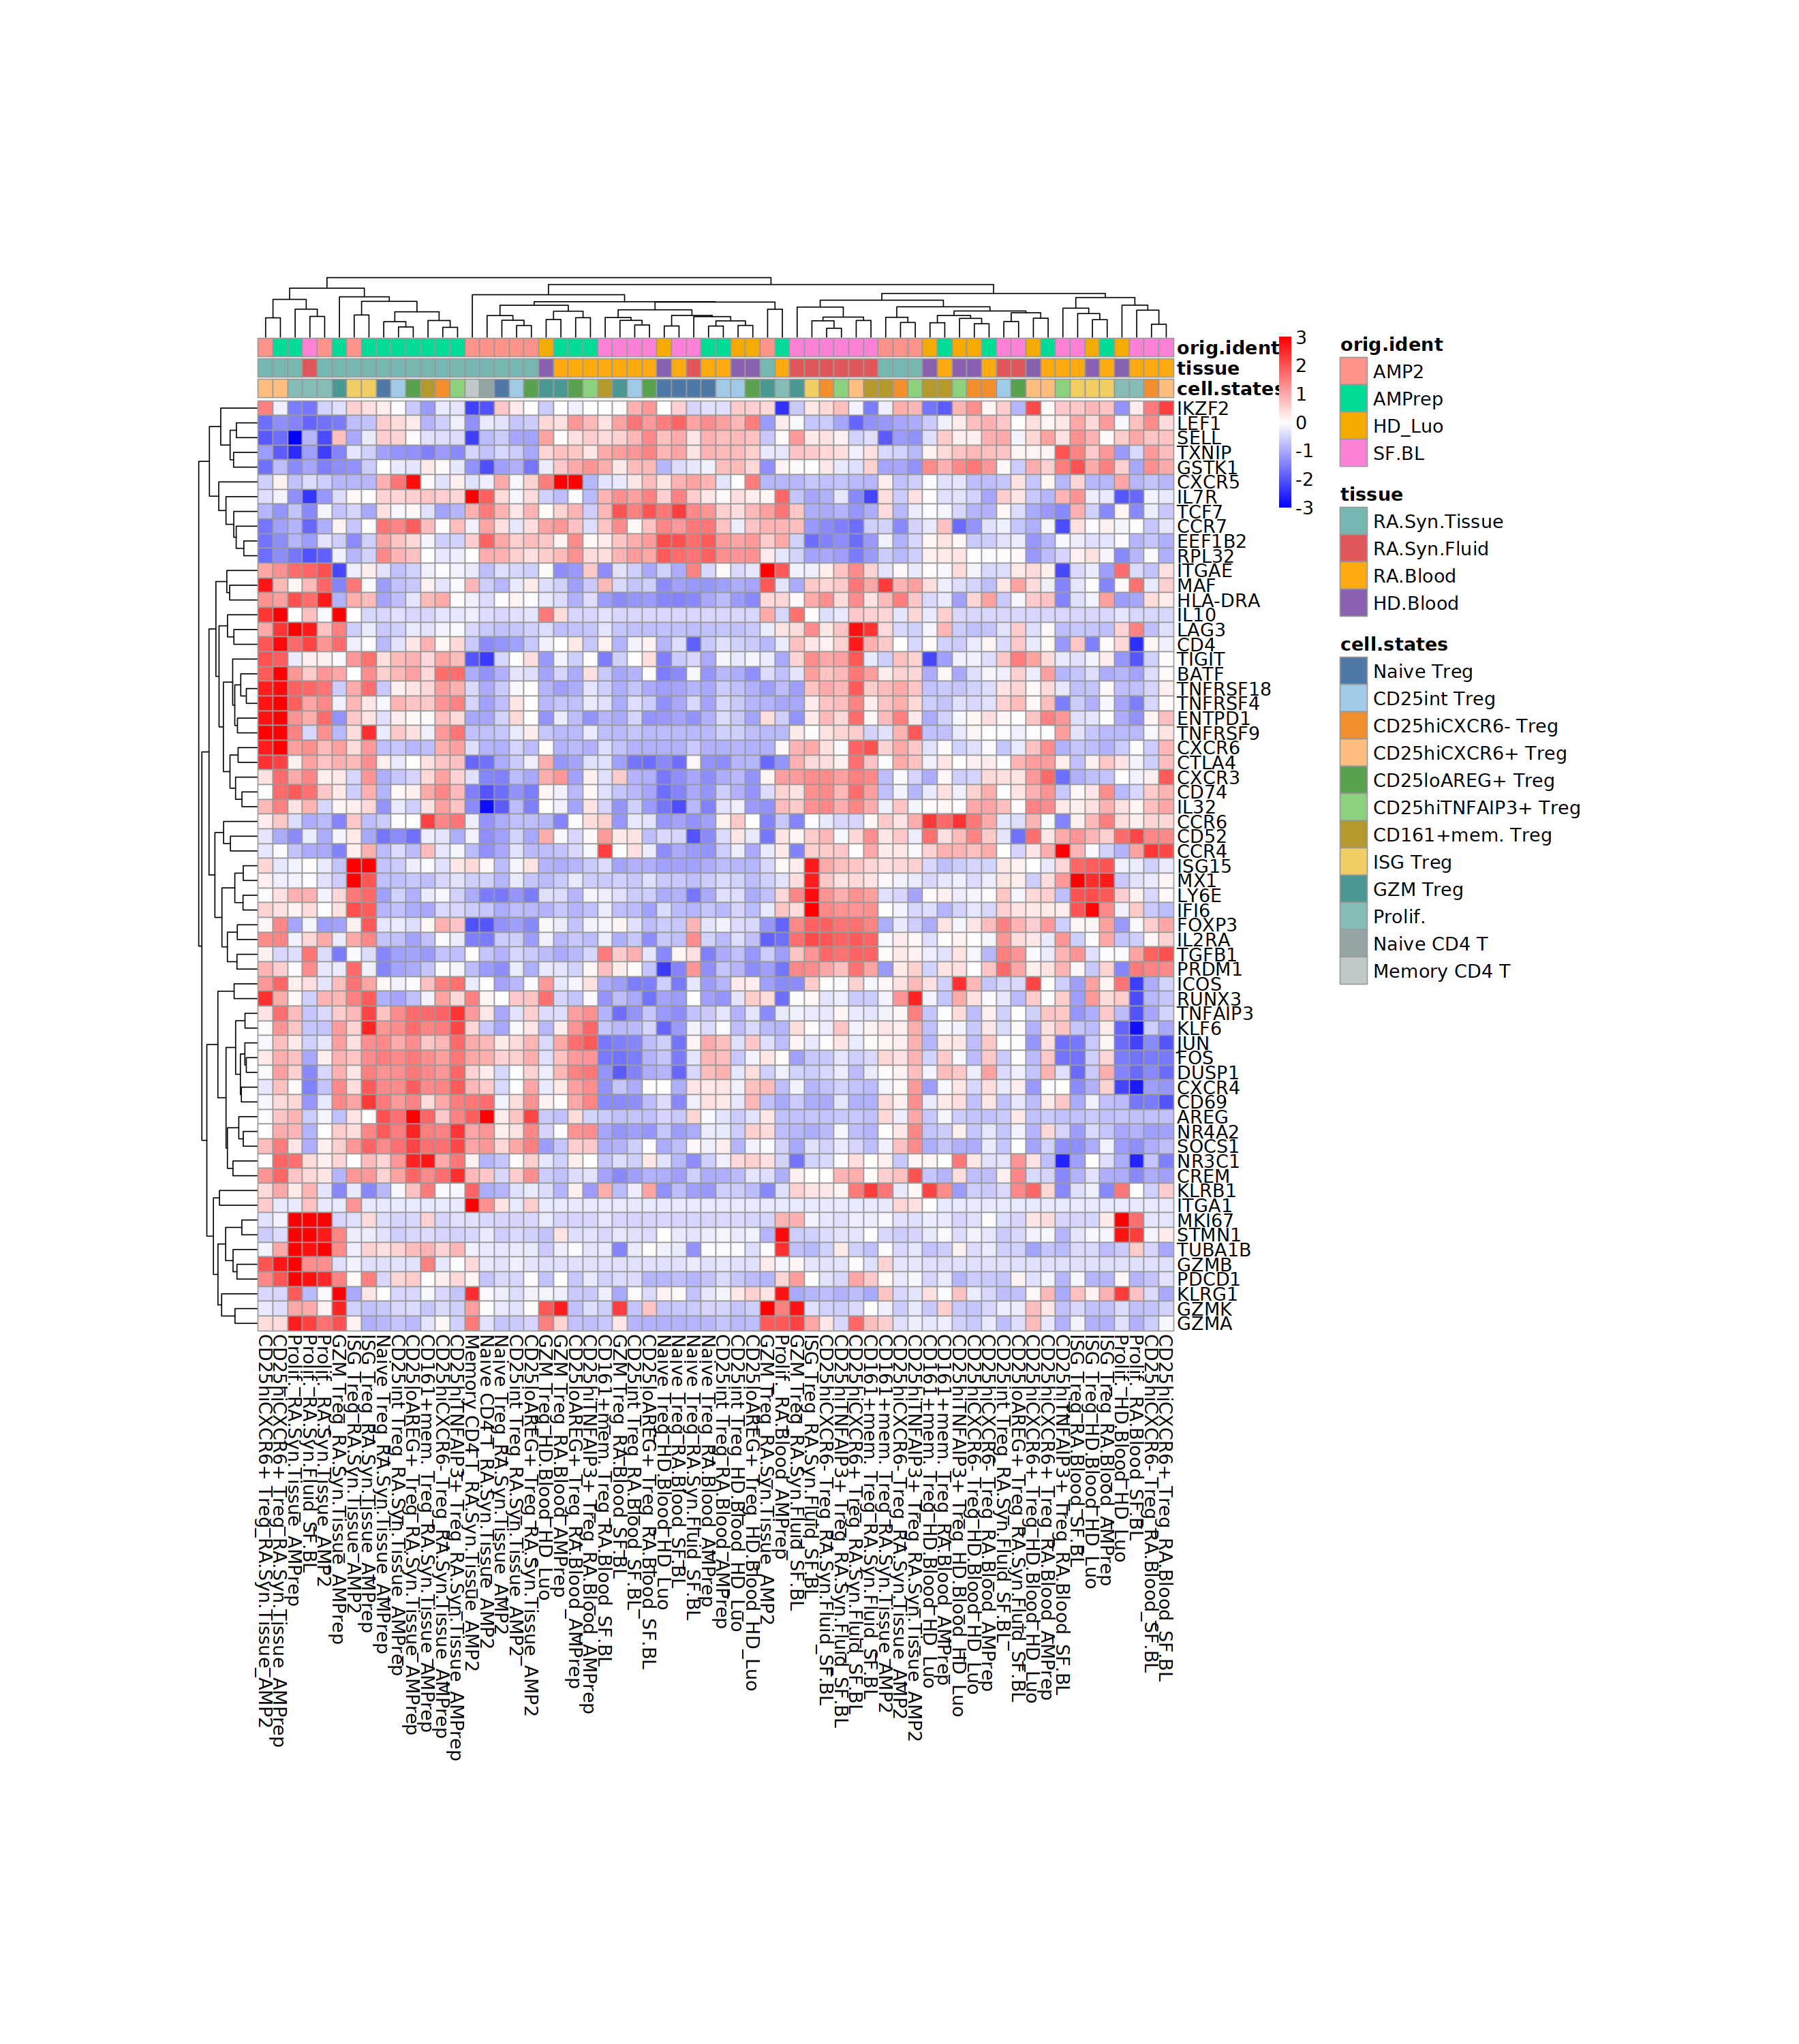

In [32]:
fig.size(25, 22)
organize.samples <- collapsed.counts$meta_data %>% arrange(cell.states, tissue) %>% select(cell.states, tissue, orig.ident)

dat2plot <- collapsed.counts$exprs_norm[unique(markers.p$gene),rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)
rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)

colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = T, cellheight=13, cellwidth=13, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T, annotation_col = organize.samples, 
         gaps_col = seq(2,62, 6),
         annotation_colors = cell.state.colors, fontsize = 16) 

pheatmap(dat2plot, scale = "row", cluster_cols = T, cluster_rows = T, cellheight=13, cellwidth=13, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T, annotation_col = organize.samples, 
         annotation_colors = cell.state.colors, fontsize = 16) 

In [21]:
# markers.p %>% group_by(group) %>% count()
spec.c <- markers.p %>% filter(grepl("C[0-9]", group)) %>% distinct(gene, .keep_all = T) %>% data.frame() 
spec.c$group <- factor(spec.c$group, levels = c("C1.Naïve","C3.CD25high", "C4.CD25highCXCR6", "C5.AREG" ,"C6.TNFa", "C7.CD161", "C8.ISGhigh", 
                                          "C9.GZM", "C10.Prolif"))
spec.c <- spec.c %>% arrange(group)
rownames(spec.c) <- spec.c$gene
spec.c %>% group_by(group) %>% count()

group            n
1 C1.Naïve         6
2 C3.CD25high      4
3 C4.CD25highCXCR6 6
4 C5.AREG          7
5 C6.TNFa          4
6 C7.CD161         2
7 C8.ISGhigh       4
8 C9.GZM           3
9 C10.Prolif       3

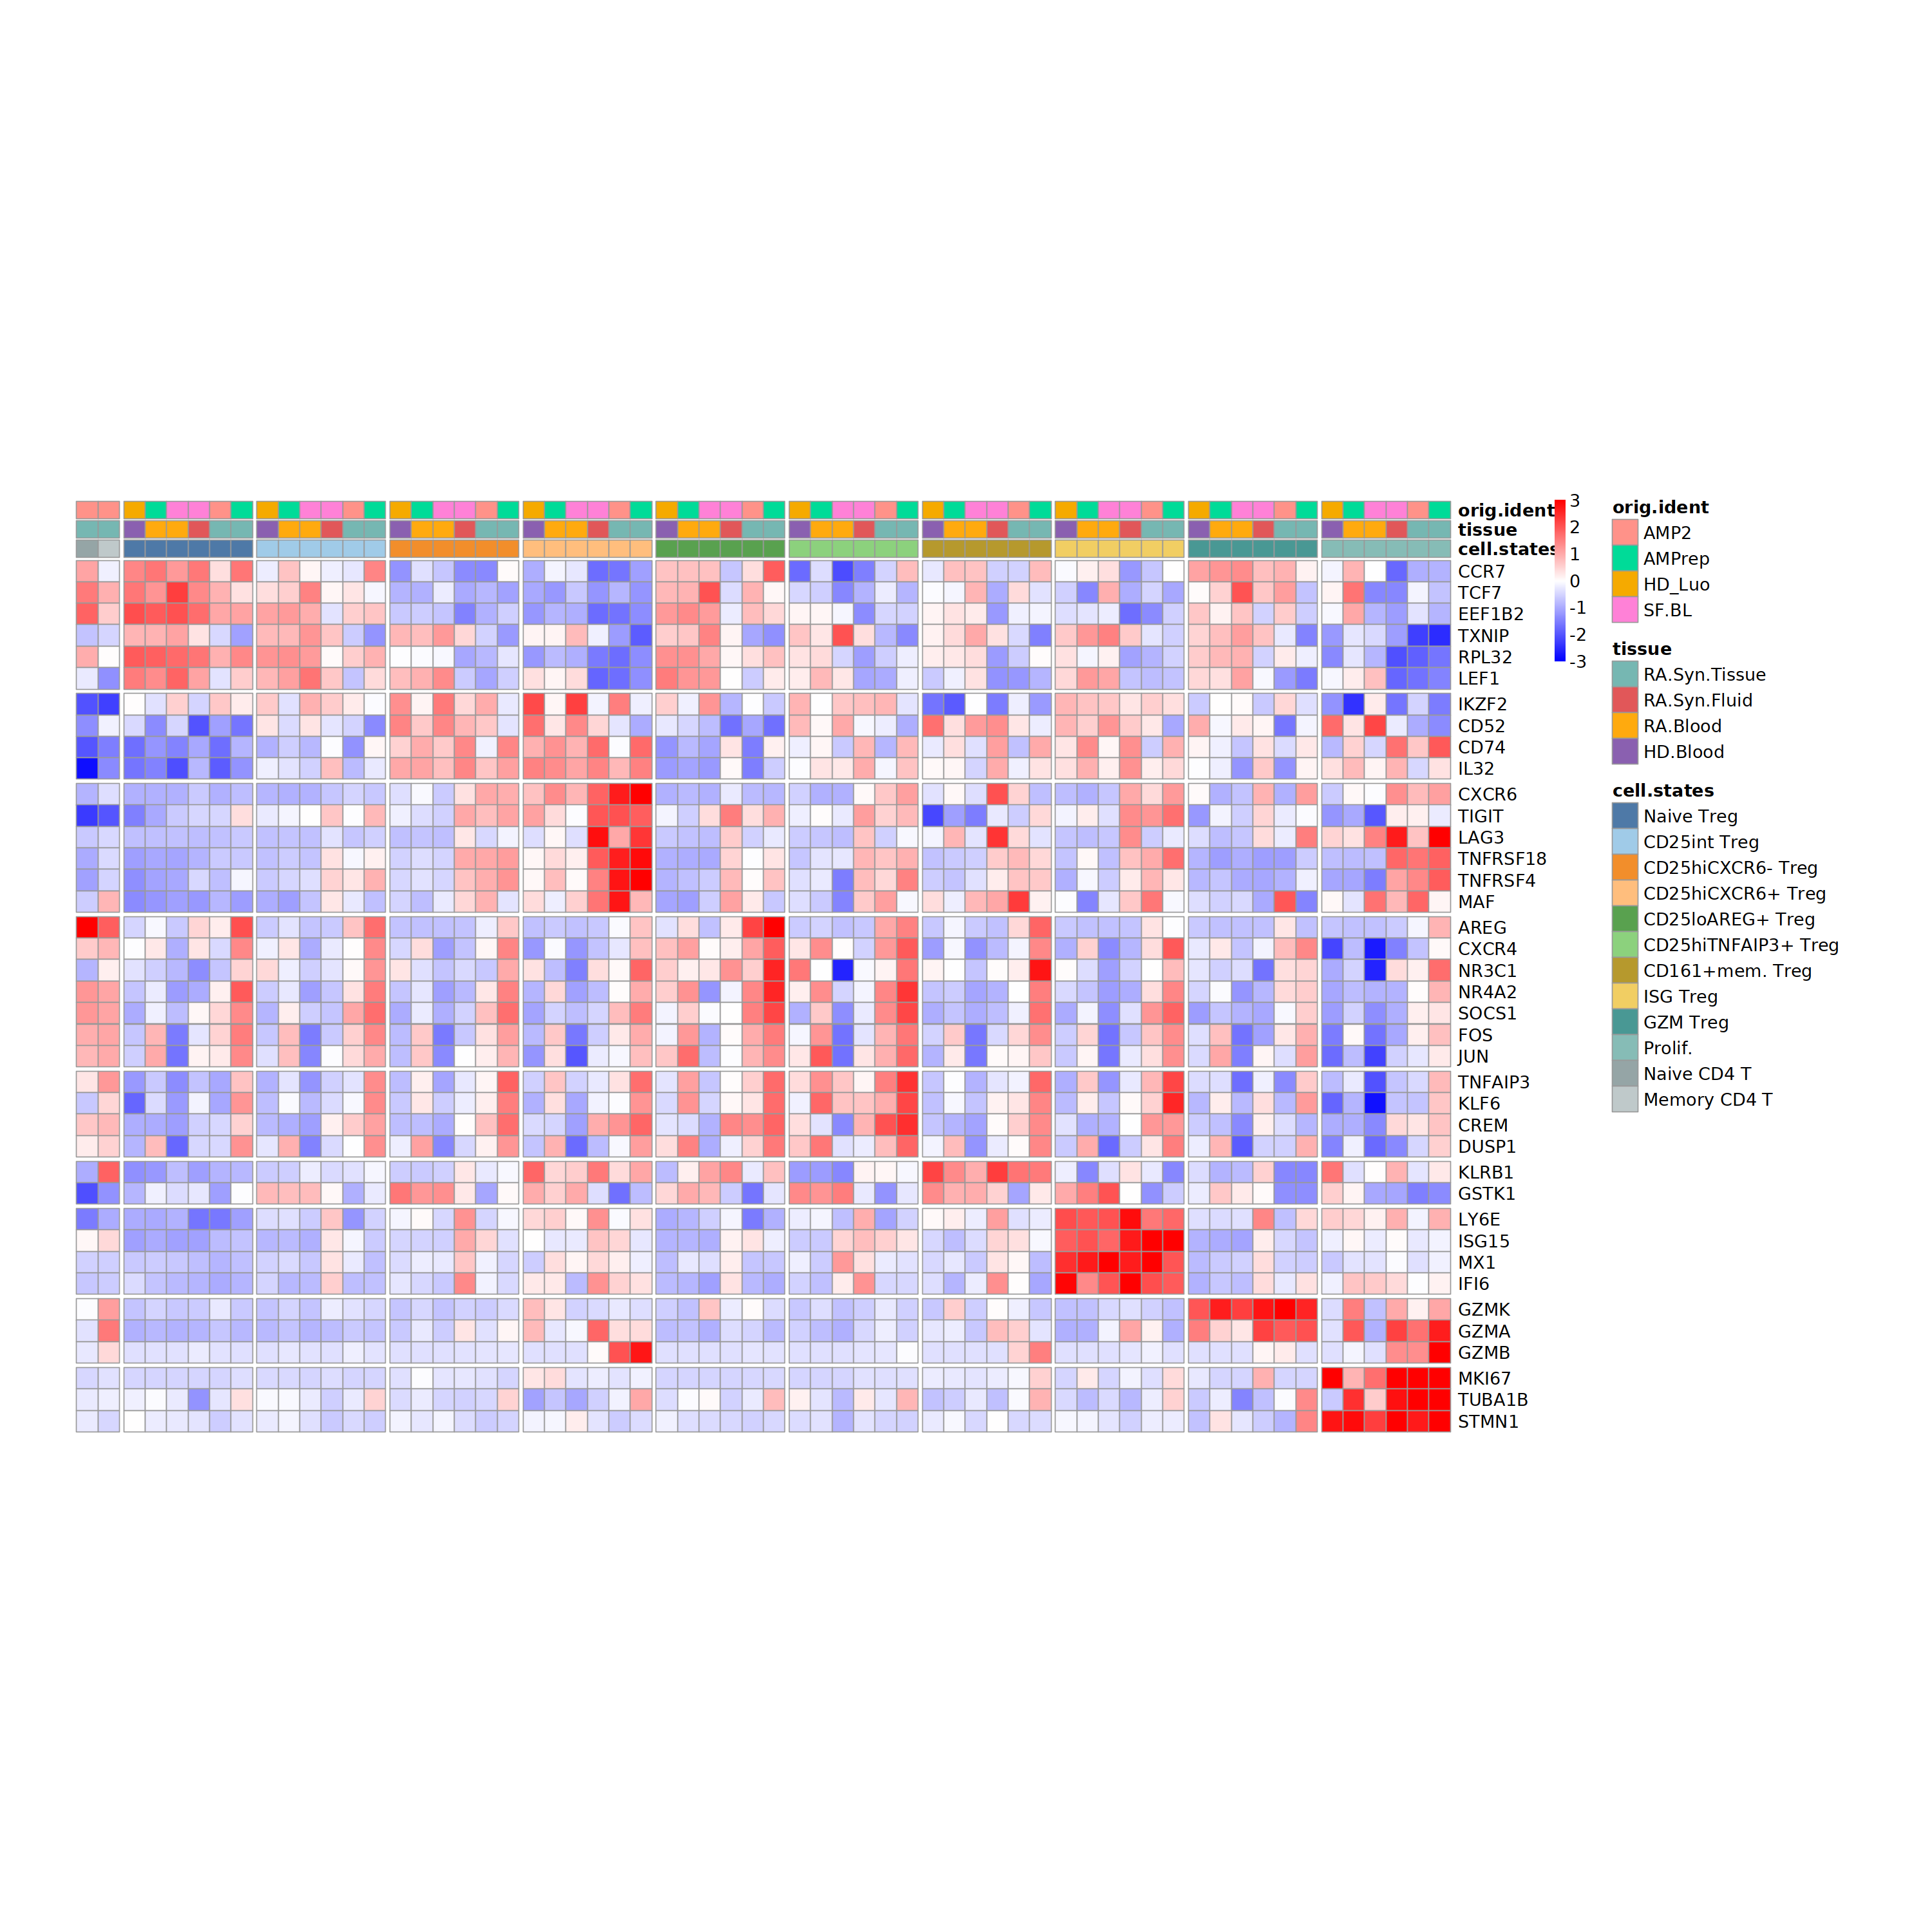

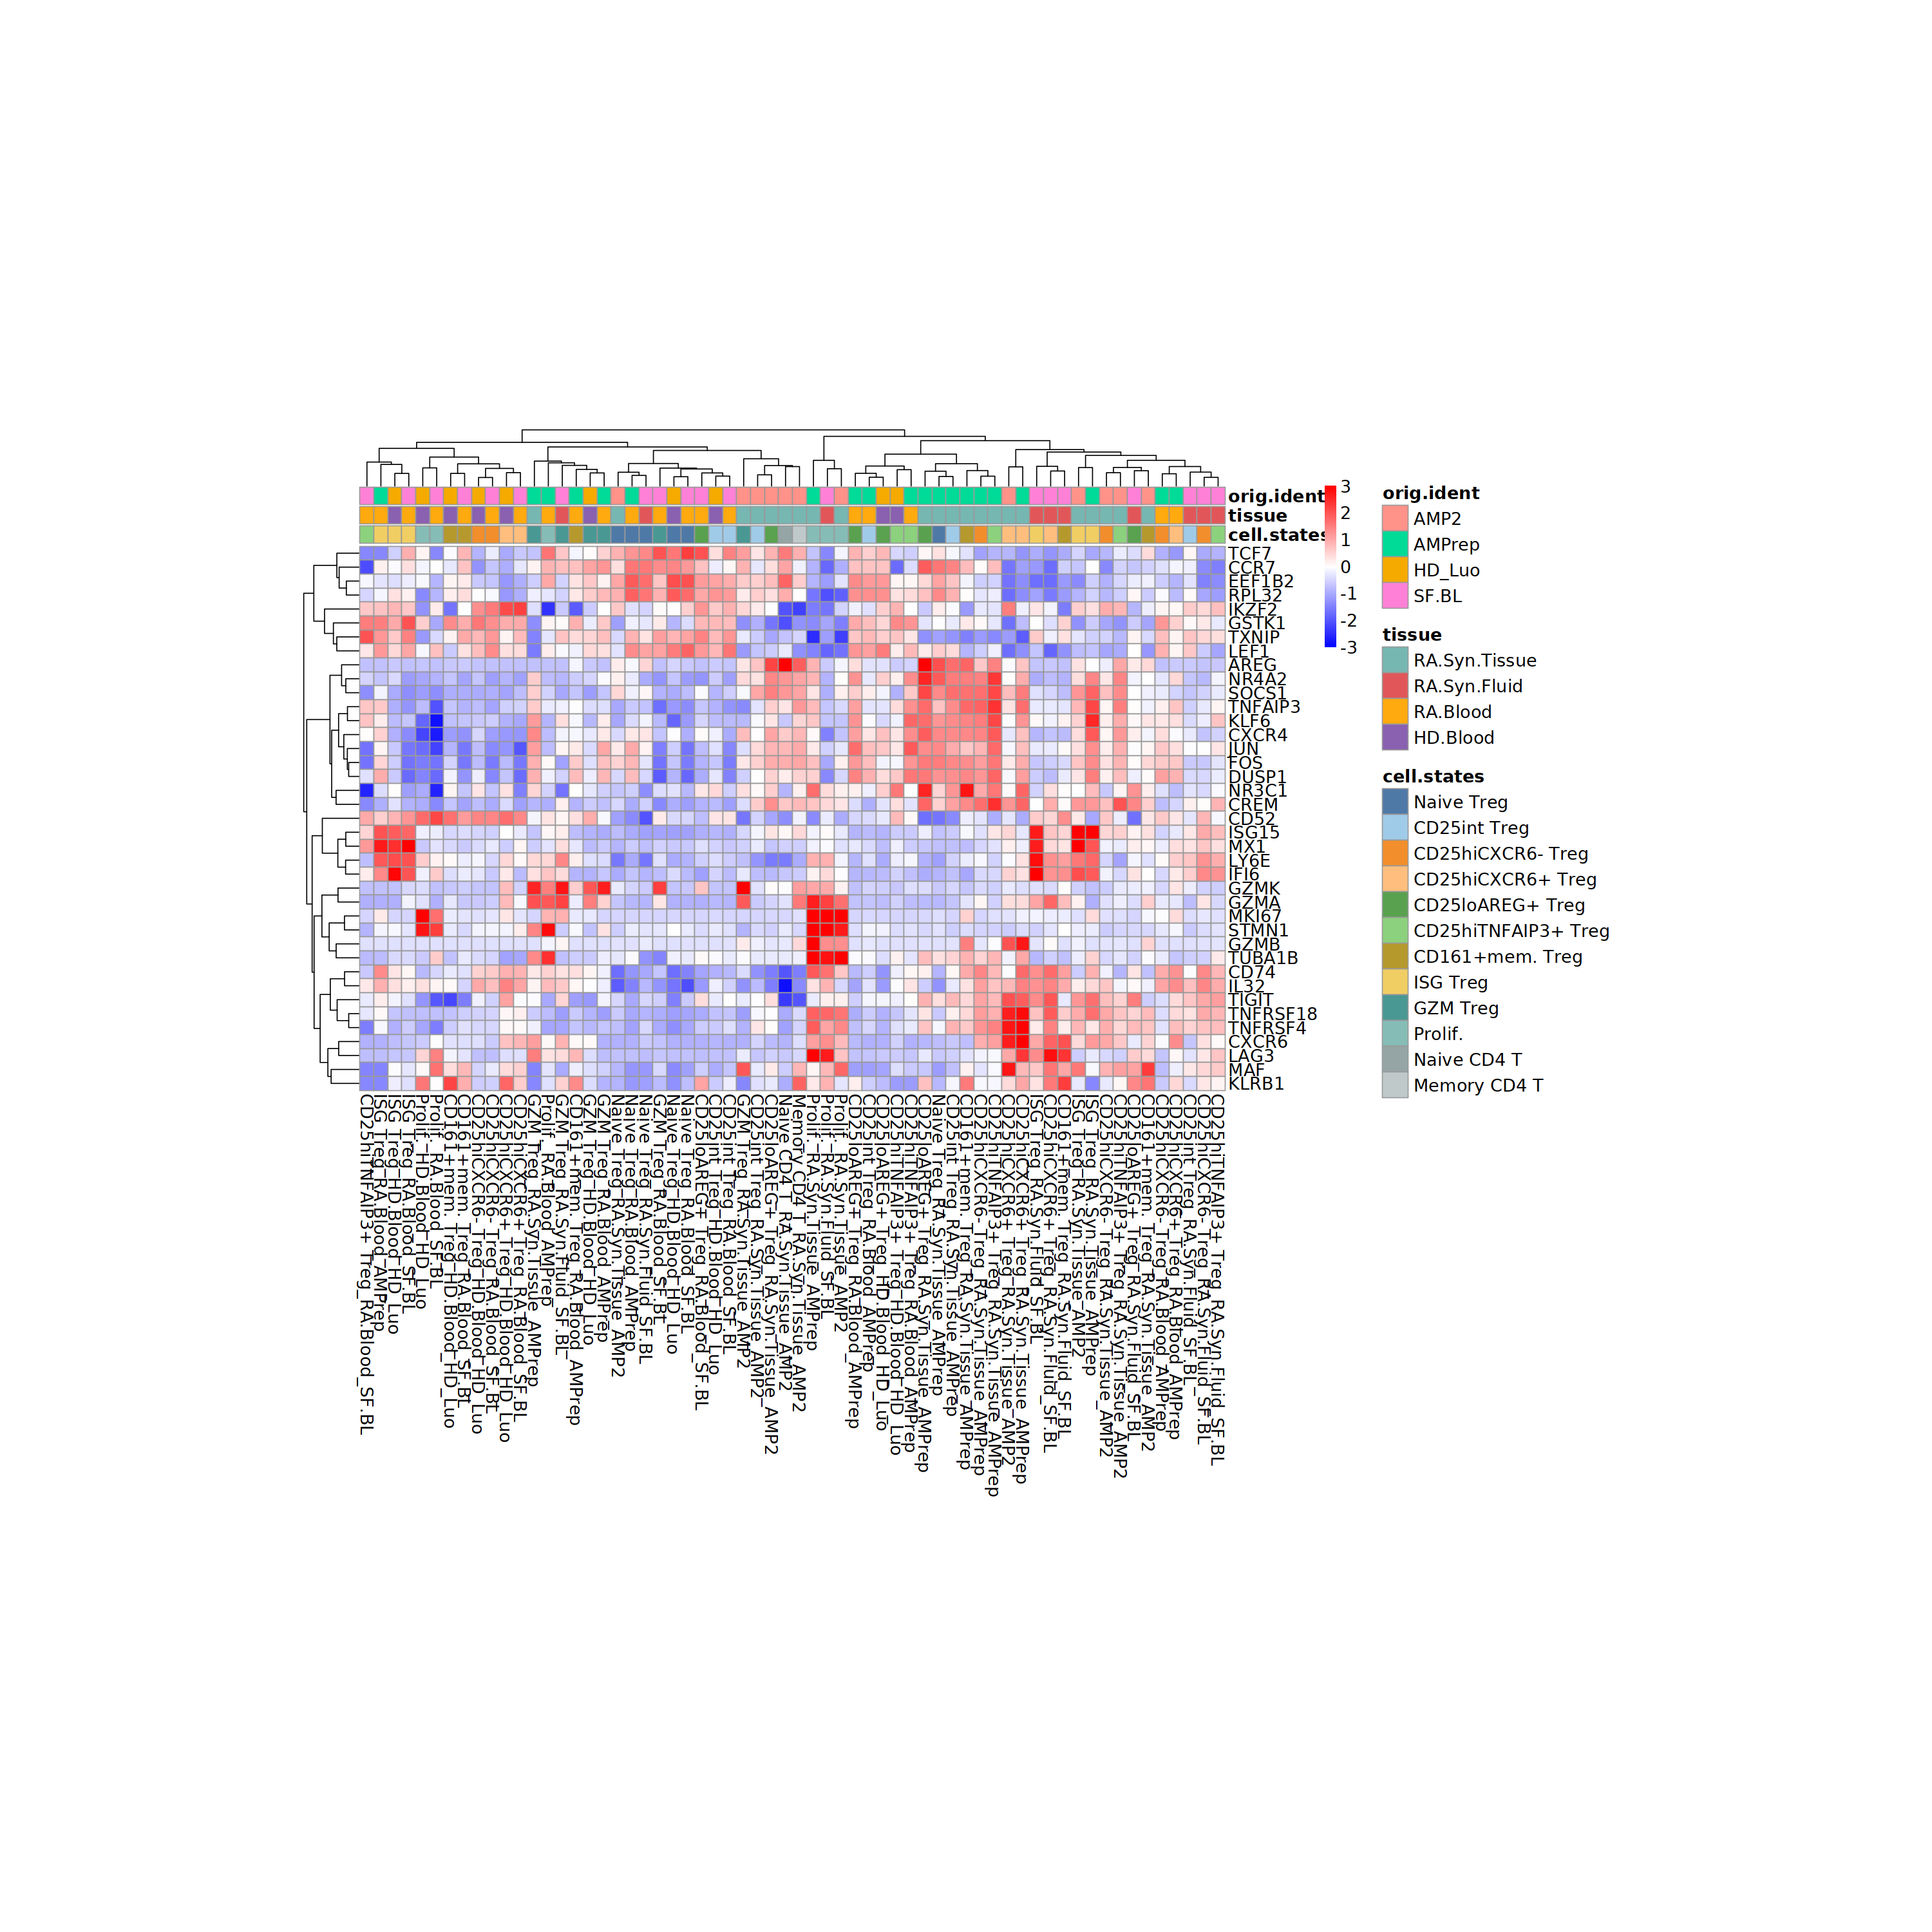

In [34]:
fig.size(25, 25)
organize.samples <- collapsed.counts$meta_data %>% arrange(cell.states, tissue) %>% select(cell.states, tissue, orig.ident)

dat2plot <- collapsed.counts$exprs_norm[spec.c$gene,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)
rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)

colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples, 
         gaps_col = seq(2,62, 6), gaps_row = c(6, 10, 16, 23, 27, 29, 33, 36),#, 19, 25,31,34,36,40,42,46,47,58,65,70, 74, 78),
         annotation_color = cell.state.colors,
        fontsize=16)

pheatmap(dat2plot, scale = "row", cluster_cols = T, cluster_rows = T, cellheight=13, cellwidth=13, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T, annotation_col = organize.samples,
         annotation_colors = cell.state.colors, fontsize = 16) 

### Scale to non Tregs

In [35]:
# Use mean expression from non Tregs and std from all cell types
organize.samples <- collapsed.counts$meta_data %>% arrange(cell.states, tissue) %>% select(cell.states, tissue, orig.ident)

dat2plot <- collapsed.counts$exprs_norm[spec.c$gene,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)
rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)

df <- dat2plot %>% as.data.frame
m <- rowMeans(df %>% select(`Naive CD4 T_RA.Syn.Tissue_AMP2`, `Memory CD4 T_RA.Syn.Tissue_AMP2`))
s <- apply(df, 1, sd, na.rm = T)
df <- (dat2plot - m) / s

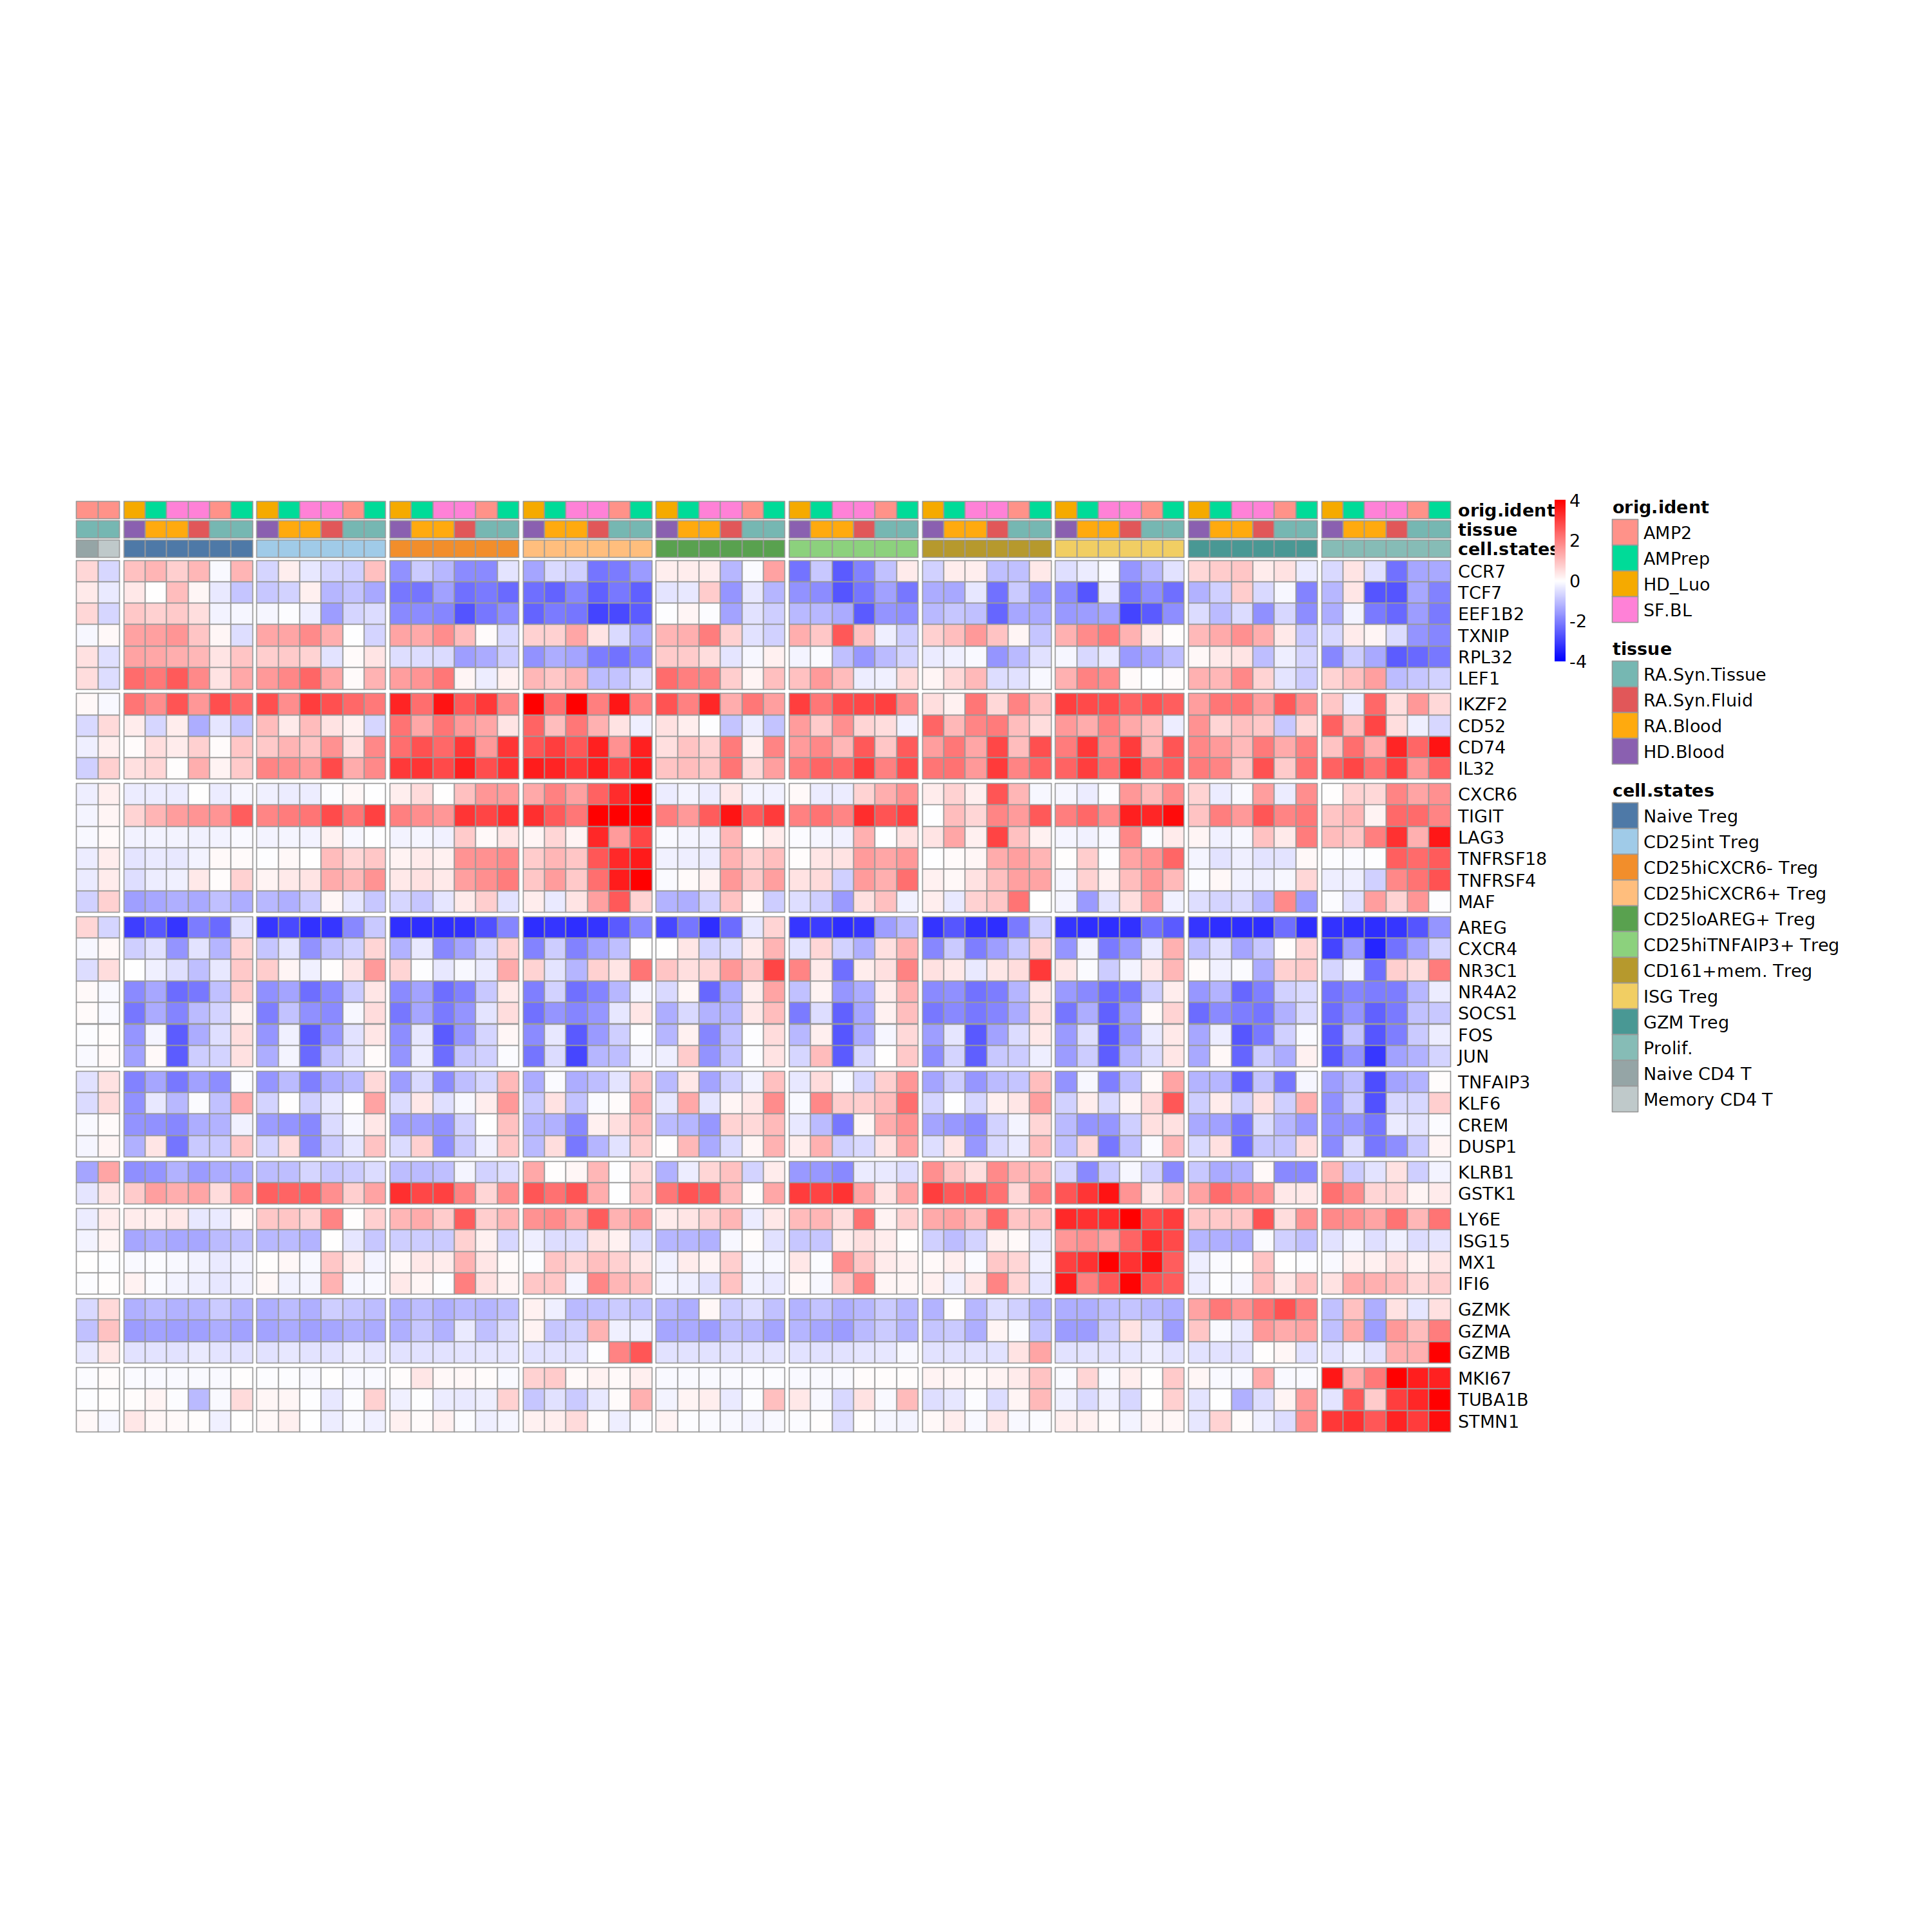

In [36]:
colorBreaks_cor = seq(-4,4,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(df, scale = "none", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples, 
         gaps_col = seq(2,62, 6), gaps_row =c(6, 10, 16, 23, 27, 29, 33, 36),
         annotation_color = cell.state.colors,
        fontsize=16)

## Cluster markers pseudobulk clusters

In [39]:
collapsed.counts.small <- presto::collapse_counts(merged@assays$RNA@counts, 
                        merged@meta.data, 
                        c("cell.states"))

CAREFUL: get_norm makes very strong assumptions about data



In [38]:
fig.size(20, 20)
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

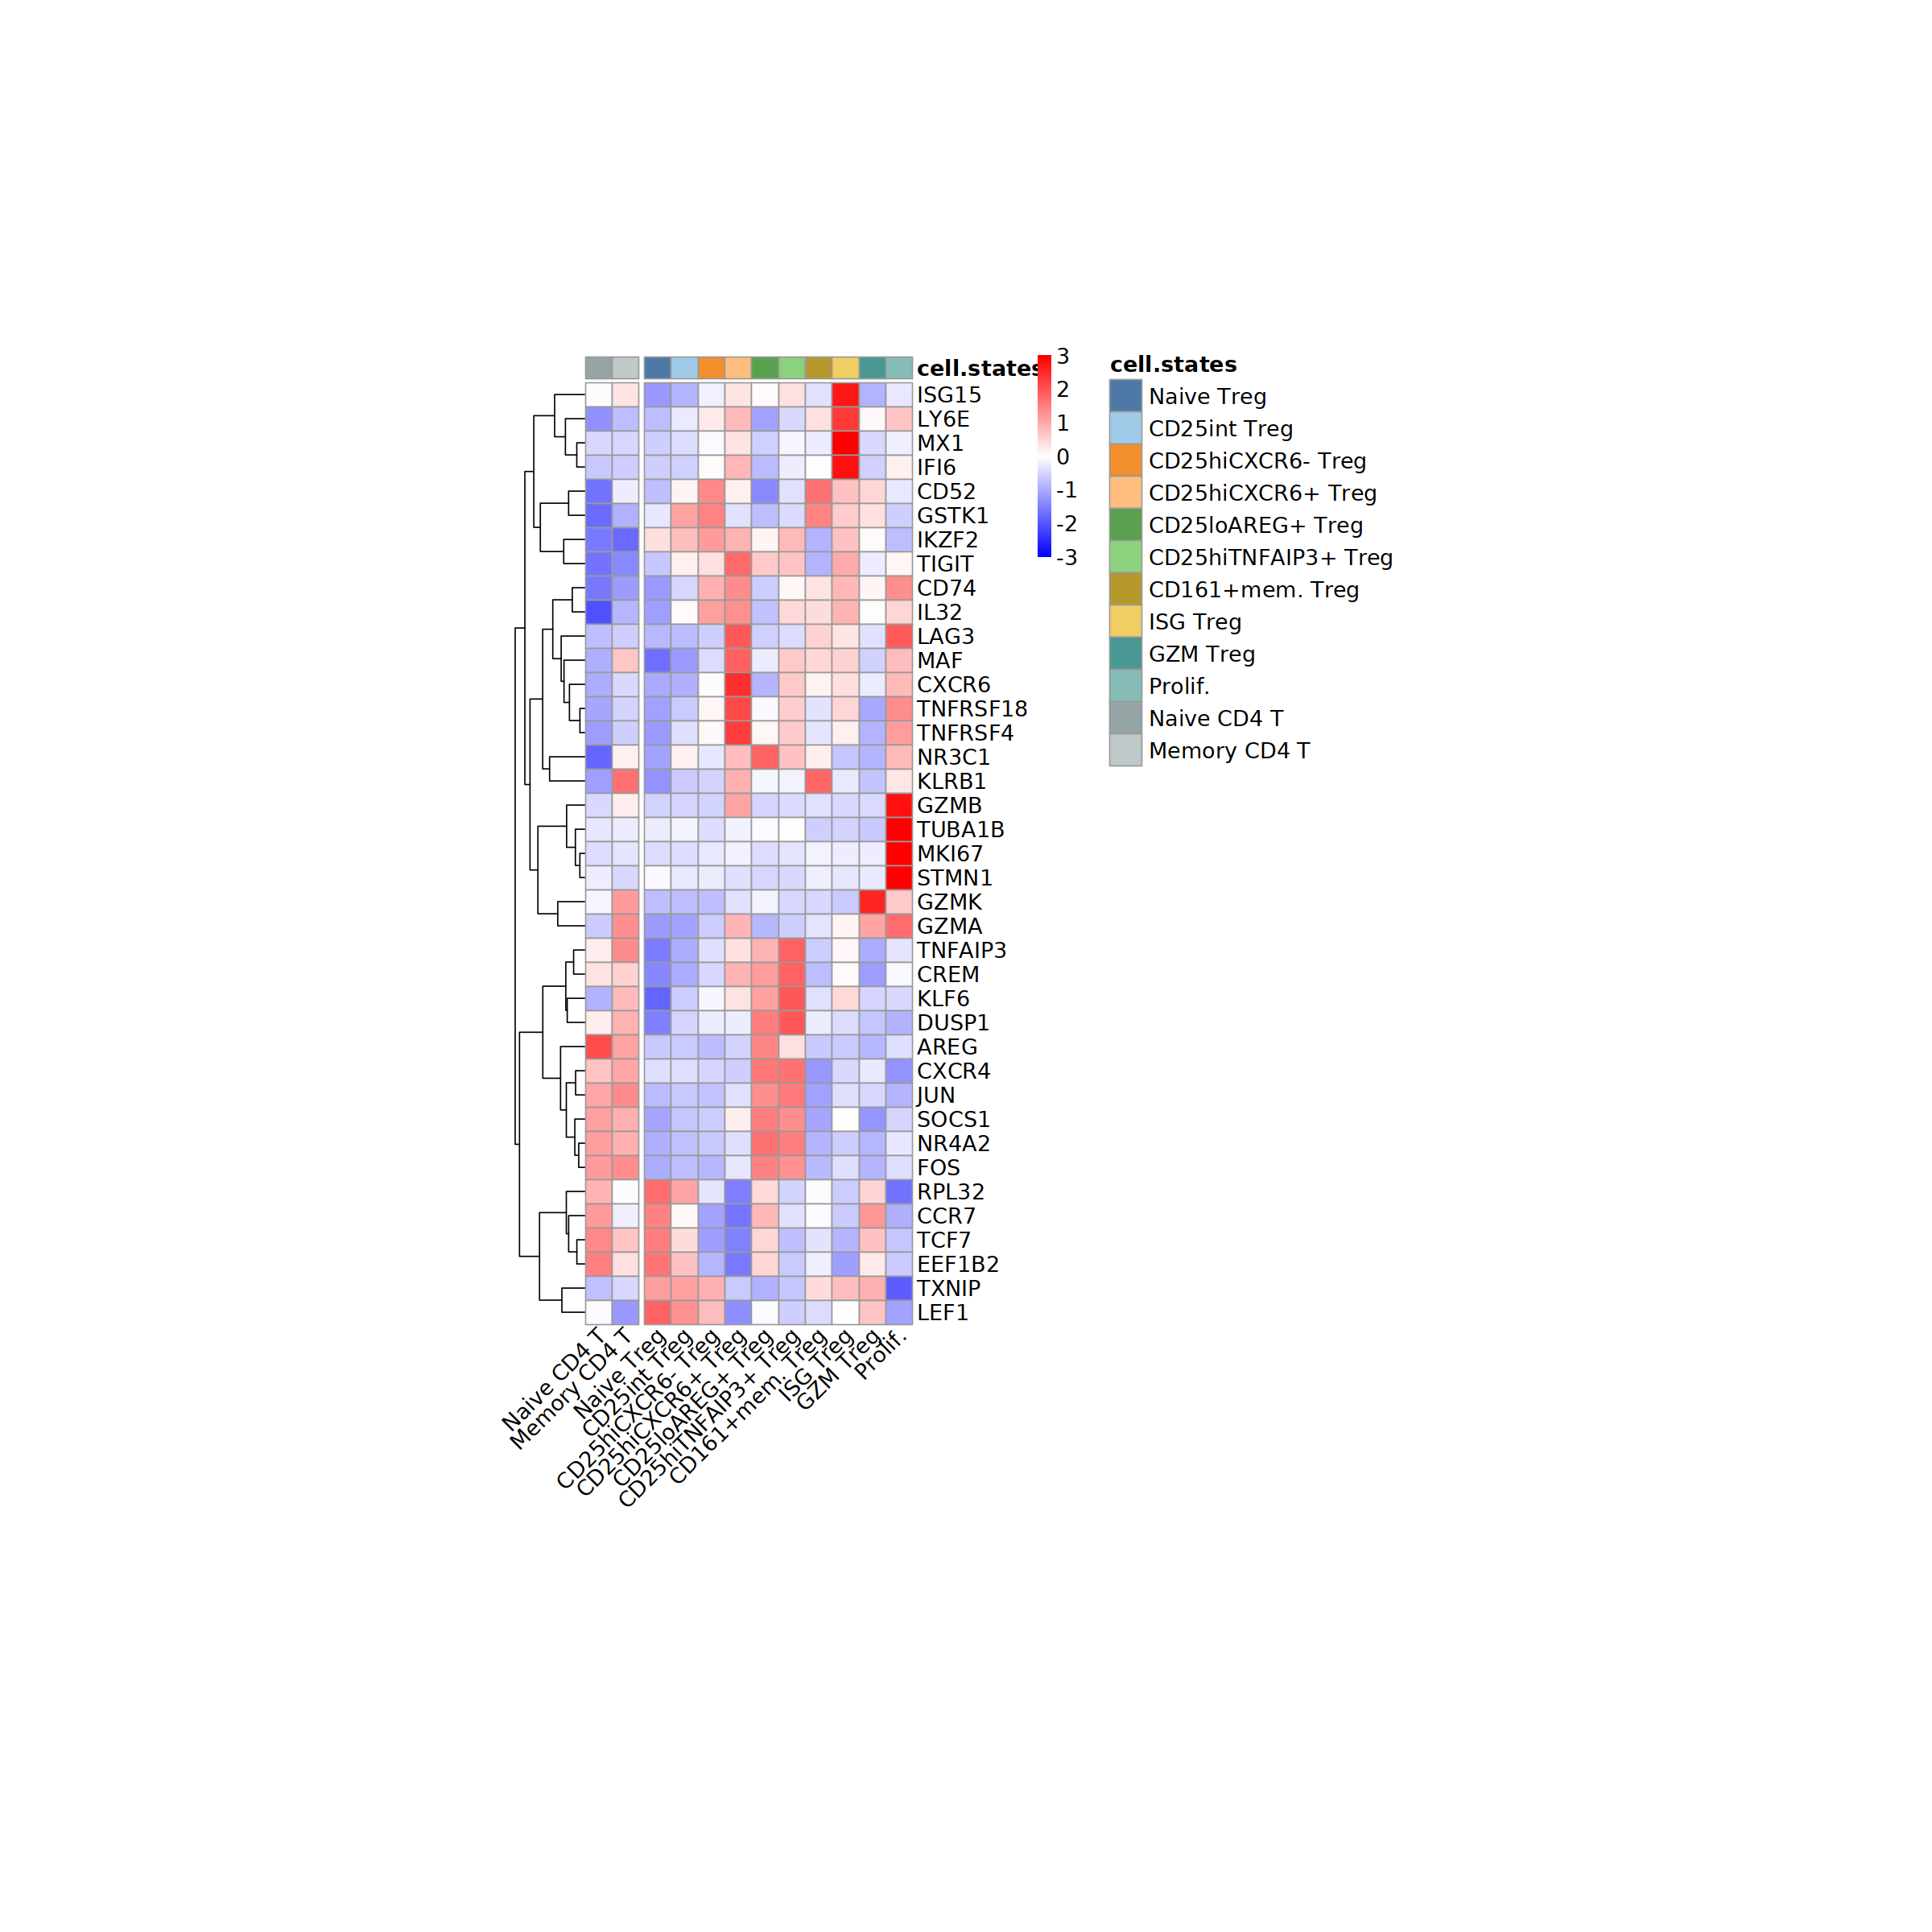

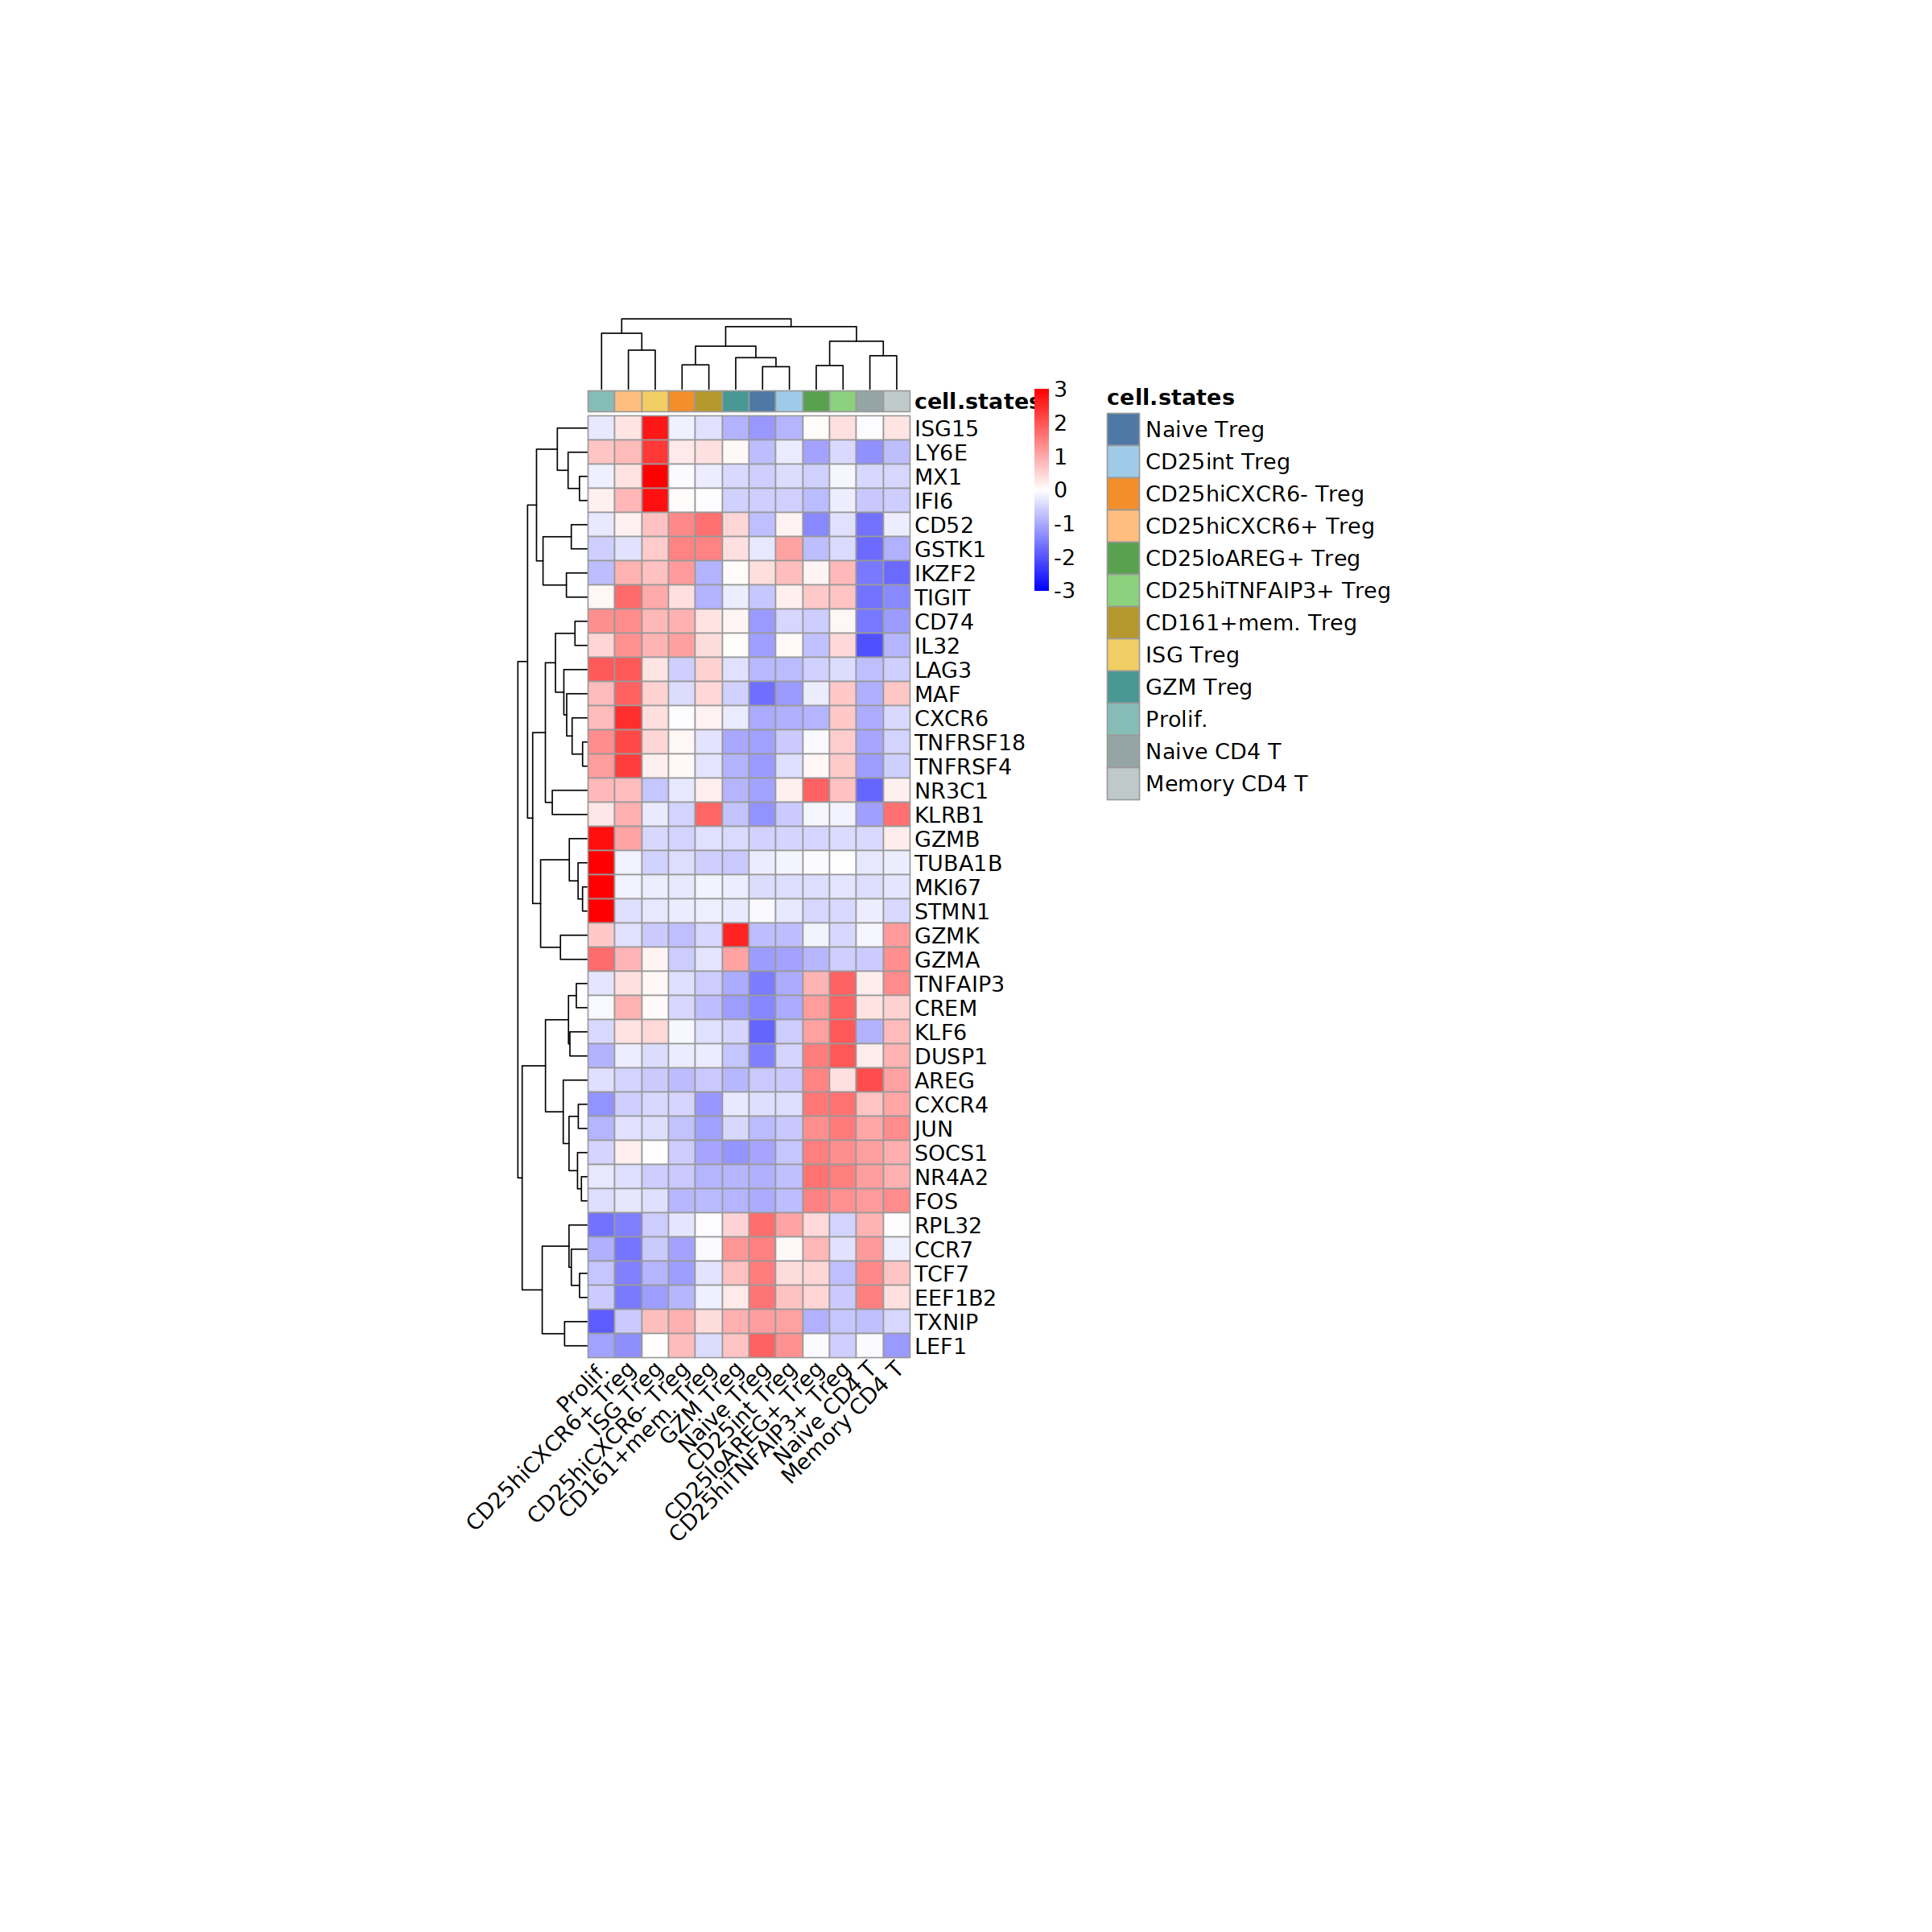

In [39]:
organize.samples <- collapsed.counts.small$meta_data %>% arrange(cell.states) %>% select(cell.states)

dat2plot <- collapsed.counts.small$exprs_norm[spec.c$gene,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states)
rownames(organize.samples) <- paste0(organize.samples$cell.states)

colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = T, cellheight=18, cellwidth=20,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T, annotation_col = organize.samples, 
         fontsize = 16, gaps_col = c(2),
        annotation_color = cell.state.colors) 

pheatmap(dat2plot, scale = "row", cluster_cols = T, cluster_rows = T, cellheight=18, cellwidth=20, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T, annotation_col = organize.samples, 
         fontsize = 16,
        annotation_color = cell.state.colors) 

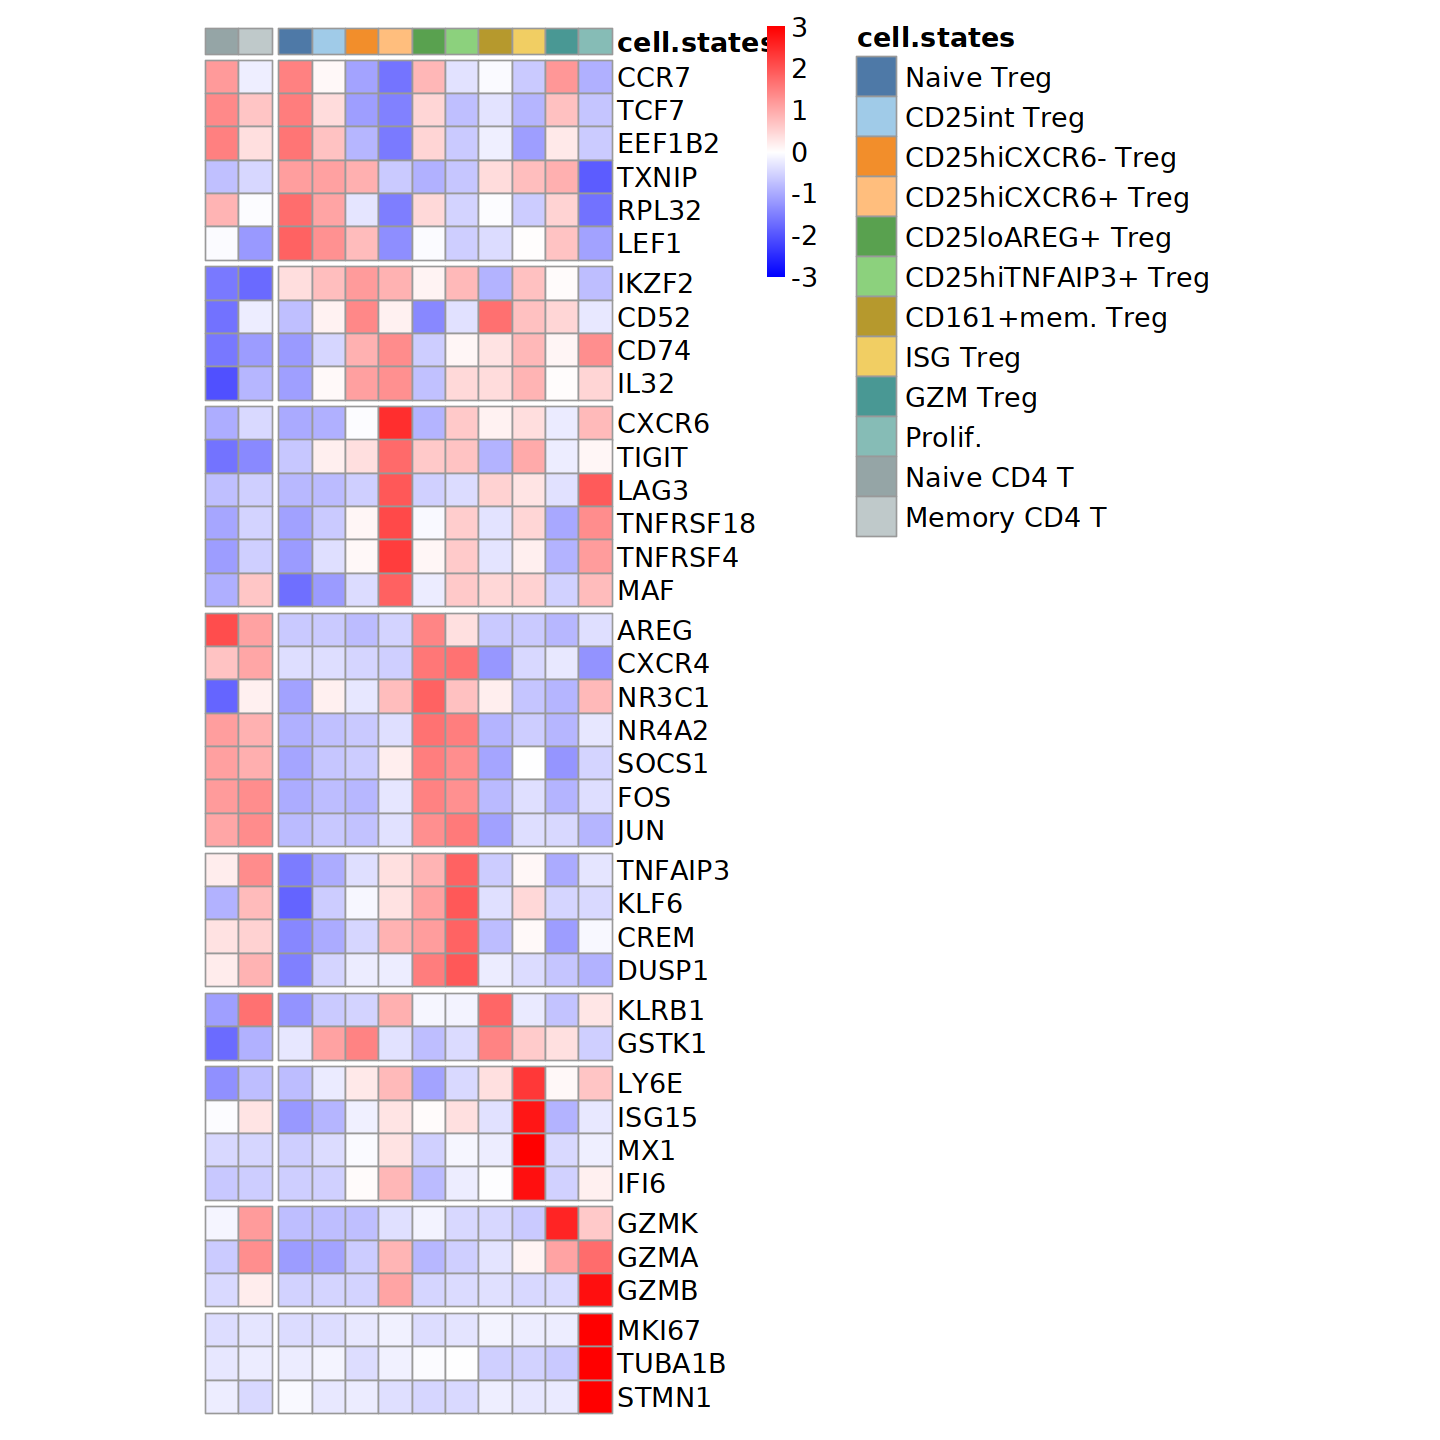

In [40]:
fig.size(12, 12)
organize.samples <- collapsed.counts.small$meta_data %>% arrange(cell.states) %>% select(cell.states)

dat2plot <- collapsed.counts.small$exprs_norm[spec.c$gene,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states)
rownames(organize.samples) <- paste0(organize.samples$cell.states)

# dat2plot <- collapsed.counts$exprs_norm[spec.c$gene,rownames(organize.samples)] 
# colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)
# rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)



colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), gaps_row = c(6, 10, 16, 23, 27, 29, 33, 36),
         annotation_color = cell.state.colors,
        fontsize=16)


### Scale to non-Tregs

In [41]:
df <- dat2plot %>% as.data.frame
m <- rowMeans(df %>% select(`Memory CD4 T`,`Naive CD4 T`))
s <- apply(df, 1, sd, na.rm = T)
df <- (dat2plot - m) / s

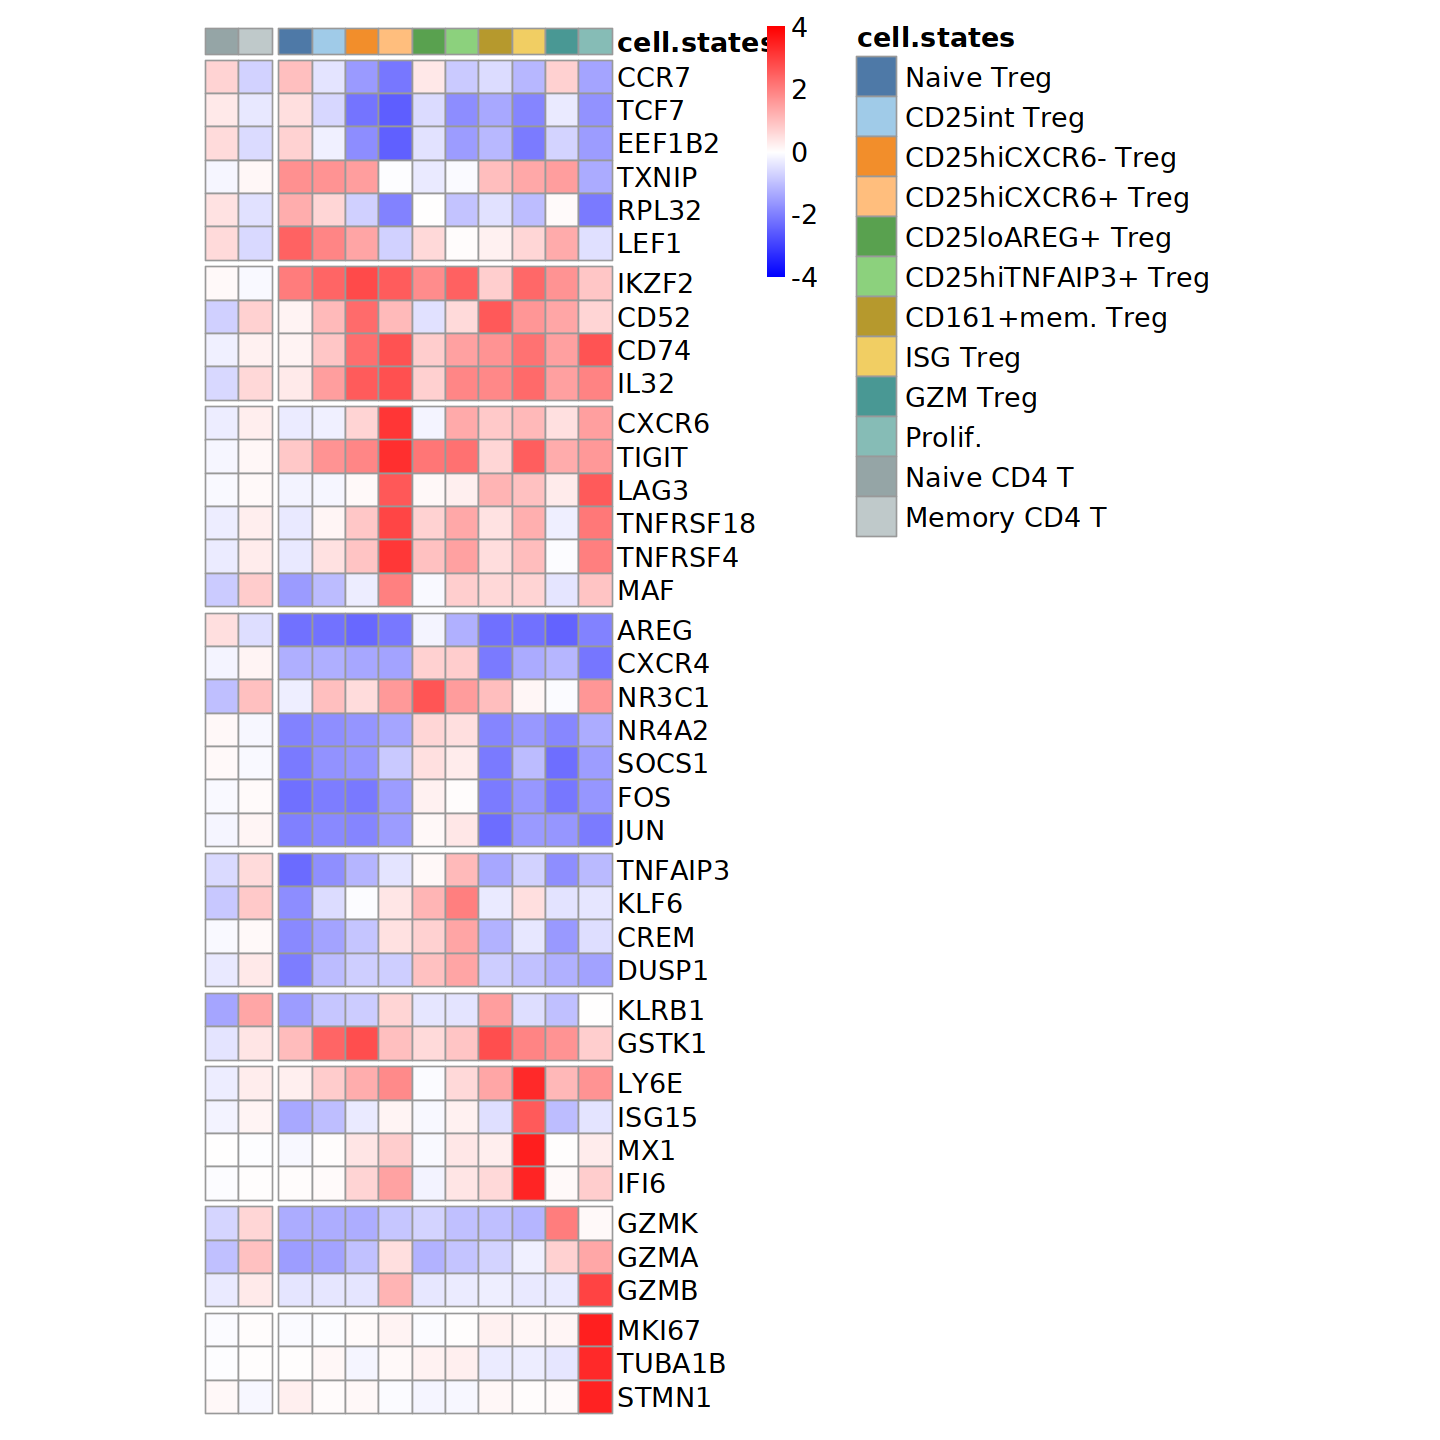

In [42]:
colorBreaks_cor = seq(-4,4,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(df, scale = "none", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), gaps_row = c(6, 10, 16, 23, 27, 29, 33, 36),
         annotation_color = cell.state.colors,
        fontsize=16)


## Selected modules heatmap

In [19]:
spec.m <- markers.p %>% filter(grepl("X[0-9]", group)) %>% distinct(gene, .keep_all = T) %>% data.frame()
rownames(spec.m) <- spec.m$gene

In [151]:
# colnames(spec.m) <- c("module", "gene")

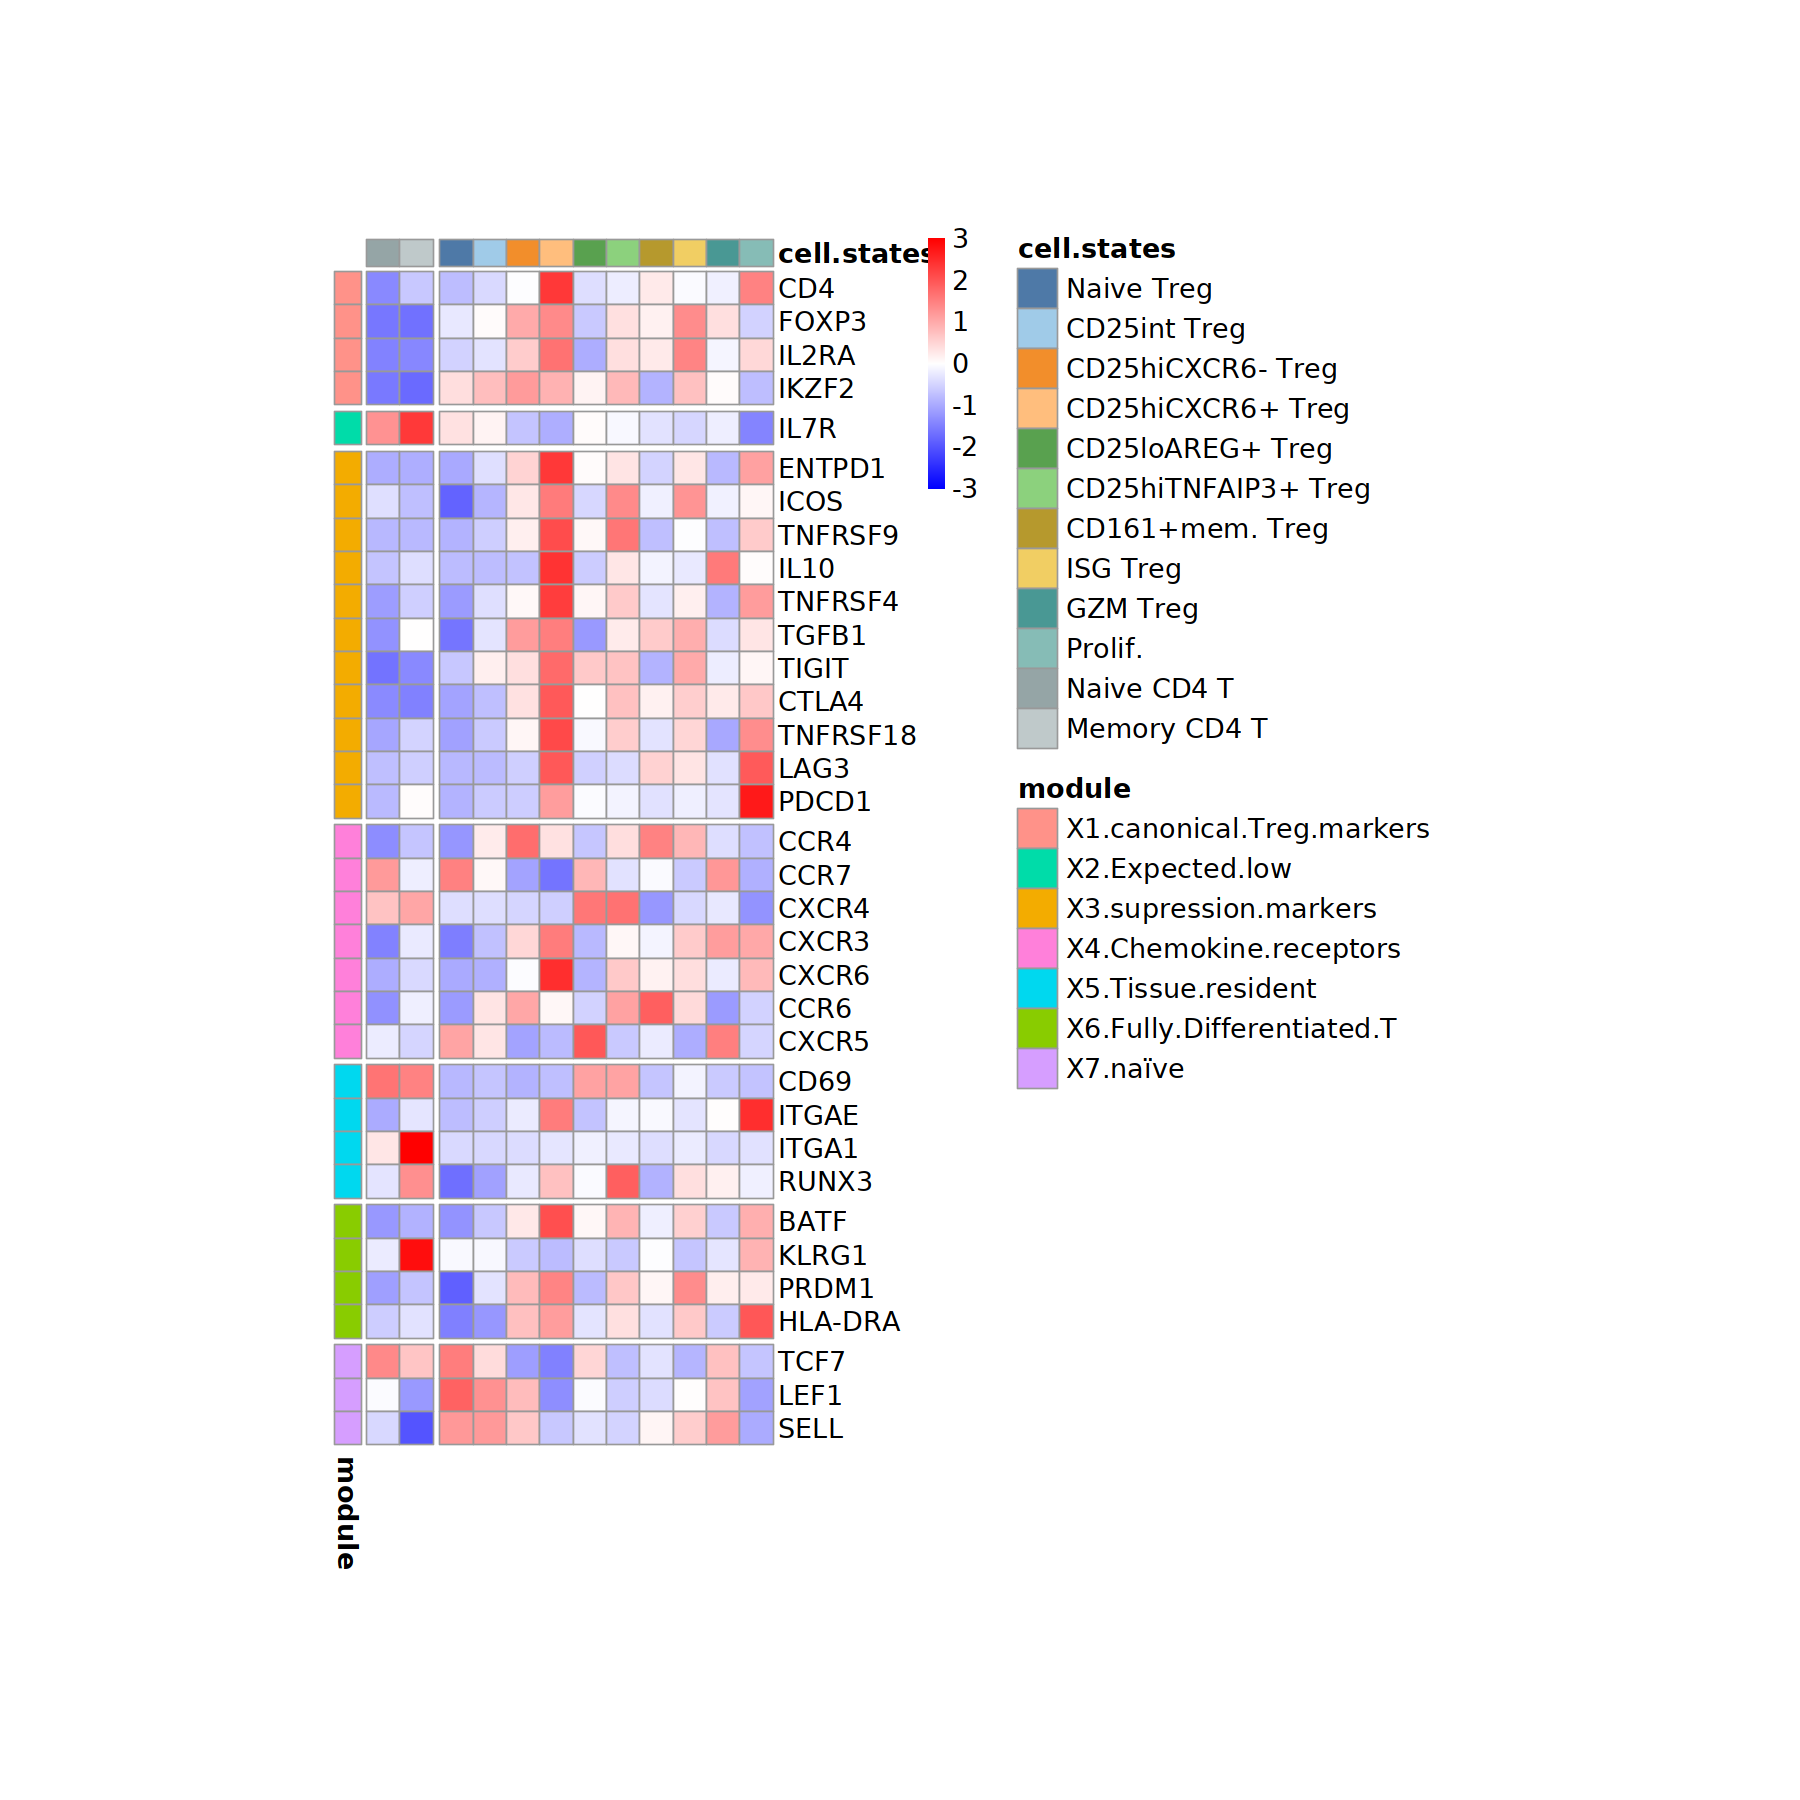

In [44]:
fig.size(15,15)
organize.samples <- collapsed.counts.small$meta_data %>% arrange(cell.states) %>% select(cell.states)

dat2plot <- collapsed.counts.small$exprs_norm[spec.m$gene, rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states)
rownames(organize.samples) <- paste0(organize.samples$cell.states)
colnames(spec.m) <- c("module", "gene")

colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), gaps_row = c(4, 5, 16, 23, 27, 31, 34), annotation_color = cell.state.colors,
         annotation_row = spec.m %>% select(module), 
        fontsize=16)


### scale to non-Treg

In [45]:
df <- dat2plot %>% as.data.frame
m <- rowMeans(df %>% select(`Memory CD4 T`,`Naive CD4 T`))
s <- apply(df, 1, sd, na.rm = T)
df <- (dat2plot - m) / s

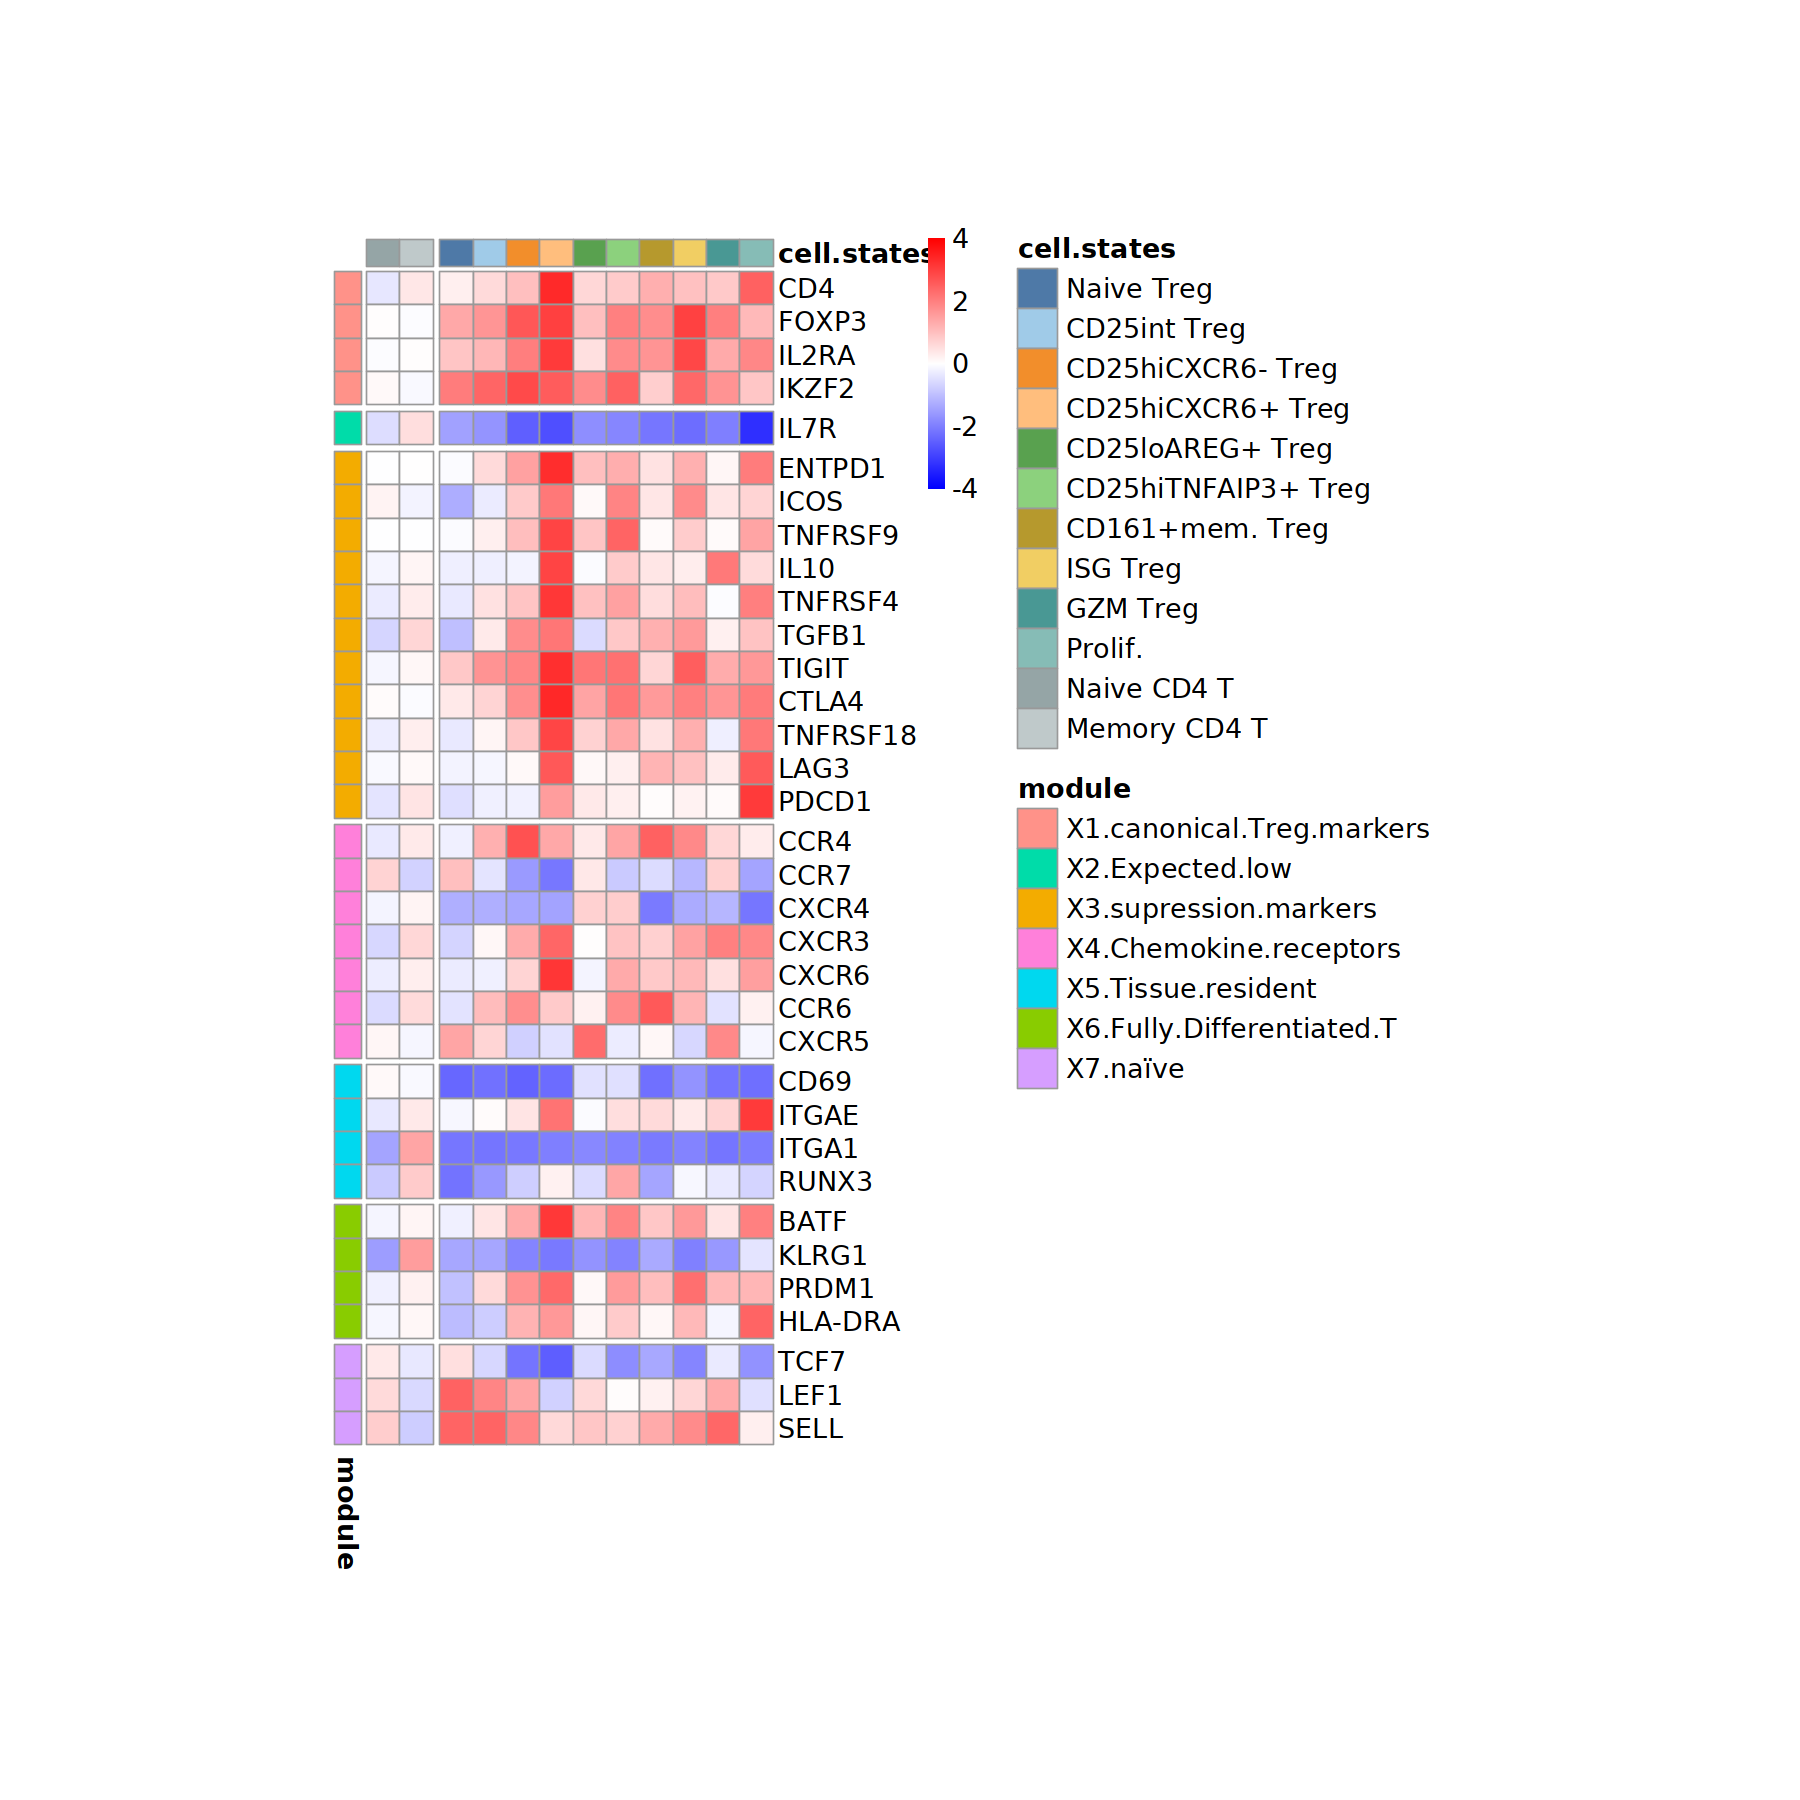

In [46]:
colorBreaks_cor = seq(-4,4,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(df, scale = "none", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), gaps_row = c(4, 5, 16, 23, 27, 31, 34),
         annotation_color = cell.state.colors, annotation_row = spec.m %>% select(module),
        fontsize=16)

## Cluster markers + genes of interest

In [22]:
colnames(spec.m) <- c("group", "gene")
g2p <- rbind(spec.m[1:5,], spec.c[-7,])
g2p

group                     gene    
CD4      X1.canonical.Treg.markers CD4     
FOXP3    X1.canonical.Treg.markers FOXP3   
IL2RA    X1.canonical.Treg.markers IL2RA   
IKZF2    X1.canonical.Treg.markers IKZF2   
IL7R     X2.Expected.low           IL7R    
CCR7     C1.Naïve                  CCR7    
TCF7     C1.Naïve                  TCF7    
EEF1B2   C1.Naïve                  EEF1B2  
TXNIP    C1.Naïve                  TXNIP   
RPL32    C1.Naïve                  RPL32   
LEF1     C1.Naïve                  LEF1    
CD52     C3.CD25high               CD52    
CD74     C3.CD25high               CD74    
IL32     C3.CD25high               IL32    
CXCR6    C4.CD25highCXCR6          CXCR6   
TIGIT    C4.CD25highCXCR6          TIGIT   
LAG3     C4.CD25highCXCR6          LAG3    
TNFRSF18 C4.CD25highCXCR6          TNFRSF18
TNFRSF4  C4.CD25highCXCR6          TNFRSF4 
MAF      C4.CD25highCXCR6          MAF     
AREG     C5.AREG                   AREG    
CXCR4    C5.AREG                   CXCR4   
NR3C1    C5.AREG                   NR3C1   
NR4A2    C5.AREG                   NR4A2   
SOCS1    C5.AREG                   SOCS1   
FOS      C5.AREG                   FOS     
JUN      C5.AREG                   JUN     
TNFAIP3  C6.TNFa                   TNFAIP3 
KLF6     C6.TNFa                   KLF6    
CREM     C6.TNFa                   CREM    
DUSP1    C6.TNFa                   DUSP1   
KLRB1    C7.CD161                  KLRB1   
GSTK1    C7.CD161                  GSTK1   
LY6E     C8.ISGhigh                LY6E    
ISG15    C8.ISGhigh                ISG15   
MX1      C8.ISGhigh                MX1     
IFI6     C8.ISGhigh                IFI6    
GZMK     C9.GZM                    GZMK    
GZMA     C9.GZM                    GZMA    
GZMB     C9.GZM                    GZMB    
MKI67    C10.Prolif                MKI67   
TUBA1B   C10.Prolif                TUBA1B  
STMN1    C10.Prolif                STMN1

In [40]:
organize.samples <- collapsed.counts.small$meta_data %>% arrange(cell.states) %>% select(cell.states)


dat2plot <- collapsed.counts.small$exprs_norm[g2p$gene, rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states)
rownames(organize.samples) <- paste0(organize.samples$cell.states)
colnames(g2p) <- c("group", "gene")


In [54]:
fig.size(10,10)

colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

hm <- pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=13, cellwidth=13,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), gaps_row = c(4, 5, 11, 14, 20, 27, 31,33,37,40), annotation_colors = cell.state.colors,
         annotation_row = g2p %>% select(group),
        fontsize=12, filename = paste(saving.path, "Figures/Fig1E.Heatmap.Alt.regularScale.pdf", sep = ''))


# pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20,
#          breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
#          gaps_col = c(2), gaps_row = c(4, 5, 11, 14, 20, 26, 28,30,34,36), annotation_color = cell.state.colors,
#         fontsize=16)

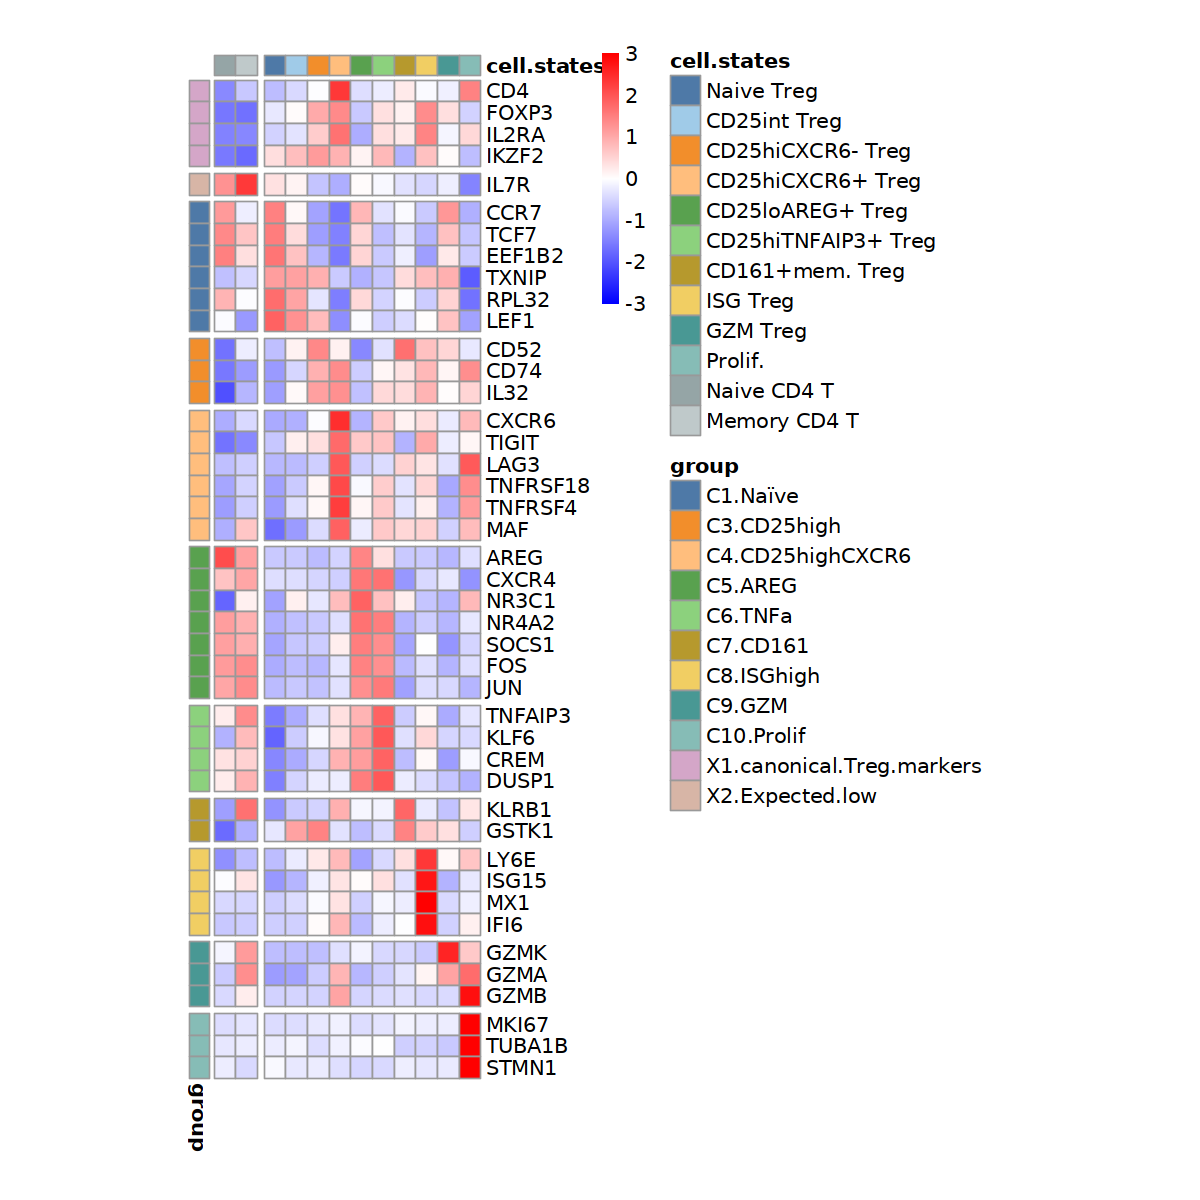

In [51]:
hm

### scale to non-Treg

In [42]:
df <- dat2plot %>% as.data.frame
m <- rowMeans(df %>% select(`Memory CD4 T`,`Naive CD4 T`))
s <- apply(df, 1, sd, na.rm = T)
df <- (dat2plot - m) / s

In [56]:
colorBreaks_cor = seq(-4,4,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))


hm <- pheatmap(df, scale = "none", cluster_cols = F, cluster_rows = F, cellheight=13, cellwidth=13,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), gaps_row = c(4, 5, 11, 14, 20, 27, 31,33,37,40),
         annotation_color = cell.state.colors, annotation_row = g2p %>% select(group),
        fontsize=12, filename = paste(saving.path, "Figures/Fig1E.Heatmap.TconvScale.pdf", sep = '')) 


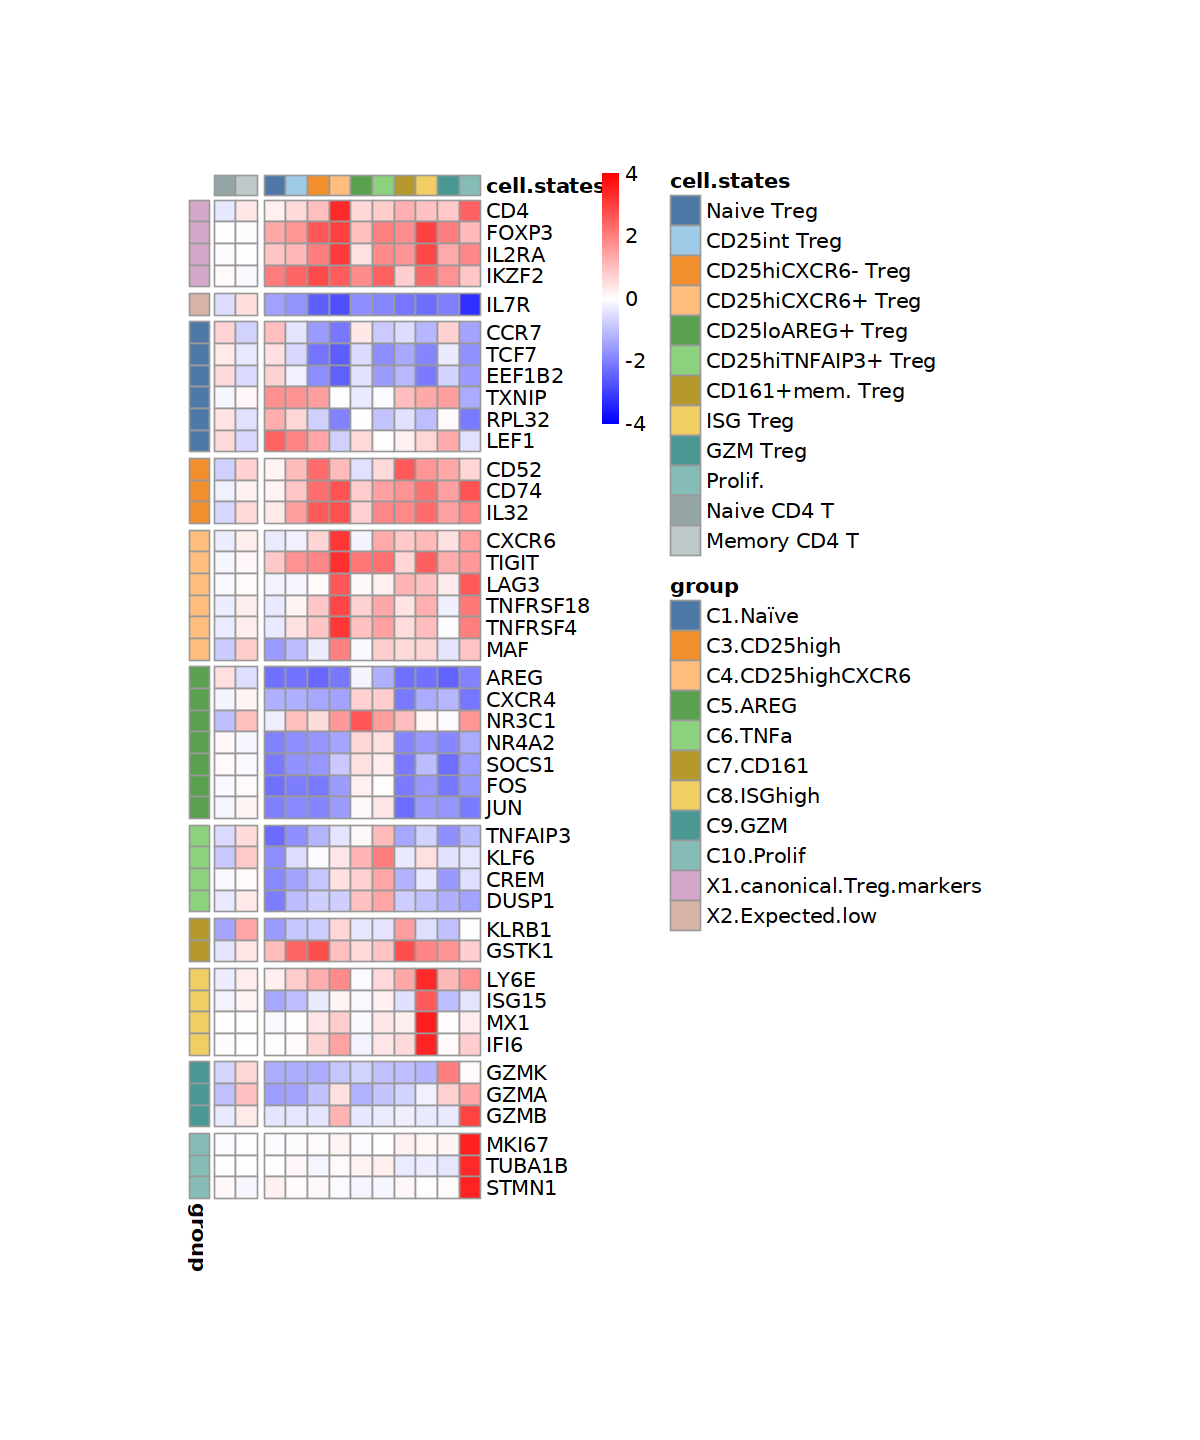

In [57]:
fig.size(12,10)
hm

### separate tissues

In [46]:
# Use mean expression from non Tregs and std from all cell types
organize.samples <- collapsed.counts$meta_data %>% arrange(cell.states, tissue) %>% select(cell.states, tissue, orig.ident)

dat2plot <- collapsed.counts$exprs_norm[g2p$gene,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)
rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)

df <- dat2plot %>% as.data.frame
df %>% head 
m <- rowMeans(df %>% select(`Naive CD4 T_RA.Syn.Tissue_AMP2`, `Memory CD4 T_RA.Syn.Tissue_AMP2`))
s <- apply(df, 1, sd, na.rm = T)
df <- (dat2plot - m) / s

Naive CD4 T_RA.Syn.Tissue_AMP2 Memory CD4 T_RA.Syn.Tissue_AMP2
CD4   0.51404627                     0.68415145                     
FOXP3 0.05758721                     0.01537344                     
IL2RA 0.14268261                     0.17325985                     
IKZF2 0.11142152                     0.05146978                     
IL7R  2.24438986                     2.77677988                     
CCR7  1.36963098                     0.83607591                     
      Naive Treg_HD.Blood_HD_Luo Naive Treg_RA.Blood_AMPrep
CD4   0.6264567                  0.6839467                 
FOXP3 0.8911090                  1.0696237                 
IL2RA 0.5979671                  0.6588659                 
IKZF2 0.7145505                  0.6067343                 
IL7R  1.6573586                  1.5412458                 
CCR7  1.5193305                  1.6001959                 
      Naive Treg_RA.Blood_SF.BL Naive Treg_RA.Syn.Fluid_SF.BL
CD4   0.7431052                 0.3974662                    
FOXP3 0.8579905                 1.7716408                    
IL2RA 0.5490517                 1.5810441                    
IKZF2 0.8698836                 0.5620461                    
IL7R  2.0659580                 1.6767370                    
CCR7  1.4231459                 1.5901319                    
      Naive Treg_RA.Syn.Tissue_AMP2 Naive Treg_RA.Syn.Tissue_AMPrep
CD4   0.5400598                     0.6402227                      
FOXP3 0.4794090                     1.0820643                      
IL2RA 0.6122852                     0.5666582                      
IKZF2 0.9000644                     0.7728702                      
IL7R  1.6044908                     1.6429887                      
CCR7  1.0680243                     1.6031777                      
      CD25int Treg_HD.Blood_HD_Luo CD25int Treg_RA.Blood_AMPrep ⋯
CD4   0.7070849                    0.7486611                    ⋯
FOXP3 1.0001435                    1.1690621                    ⋯
IL2RA 0.7168664                    0.5096782                    ⋯
IKZF2 0.8924109                    0.6061094                    ⋯
IL7R  1.5845991                    1.4532433                    ⋯
CCR7  0.8210939                    1.2145496                    ⋯
      GZM Treg_RA.Blood_SF.BL GZM Treg_RA.Syn.Fluid_SF.BL
CD4   0.6291283               1.0045370                  
FOXP3 1.3225722               2.0913251                  
IL2RA 0.4466880               1.7657234                  
IKZF2 0.7244924               0.5260632                  
IL7R  1.9990582               1.1238808                  
CCR7  1.4909535               1.2304881                  
      GZM Treg_RA.Syn.Tissue_AMP2 GZM Treg_RA.Syn.Tissue_AMPrep
CD4   0.6356961                   1.2426475                    
FOXP3 0.5105769                   0.5997105                    
IL2RA 0.0000000                   0.8030715                    
IKZF2 0.8469425                   0.5997105                    
IL7R  1.4658586                   1.2426475                    
CCR7  1.2988306                   0.9719838                    
      Prolif._HD.Blood_HD_Luo Prolif._RA.Blood_AMPrep Prolif._RA.Blood_SF.BL
CD4   0.9402852               0.77996445              0.2583717             
FOXP3 0.5361509               0.15595249              1.2115123             
IL2RA 0.5634420               0.08101332              0.6336413             
IKZF2 0.3379009               0.00000000              0.7789946             
IL7R  0.5498895               2.20838346              0.6336413             
CCR7  0.8535159               1.28535336              0.9058767             
      Prolif._RA.Syn.Fluid_SF.BL Prolif._RA.Syn.Tissue_AMP2
CD4   1.3482154                  1.1239029                 
FOXP3 1.1775330                  0.5640435                 
IL2RA 1.1484821                  1.4078586                 
IKZF2 0.2337794                  0.5587071                 
IL7R  0.3710607                  0.876

In [62]:
fig.size(10, 20)
colorBreaks_cor = seq(-4,4,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

hm <- pheatmap(df, scale = "none", cluster_cols = F, cluster_rows = F, cellheight=13, cellwidth=13,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples, 
         gaps_col = seq(2,62, 6), gaps_row = c(4, 5, 11, 14, 20, 27, 31,33,37,40) ,annotation_row = g2p %>% select(group),
         annotation_color = cell.state.colors,
        fontsize=12, filename = paste(saving.path, "Figures/FigS1d.Heatmap.TconvScale.pdf", sep = ''))

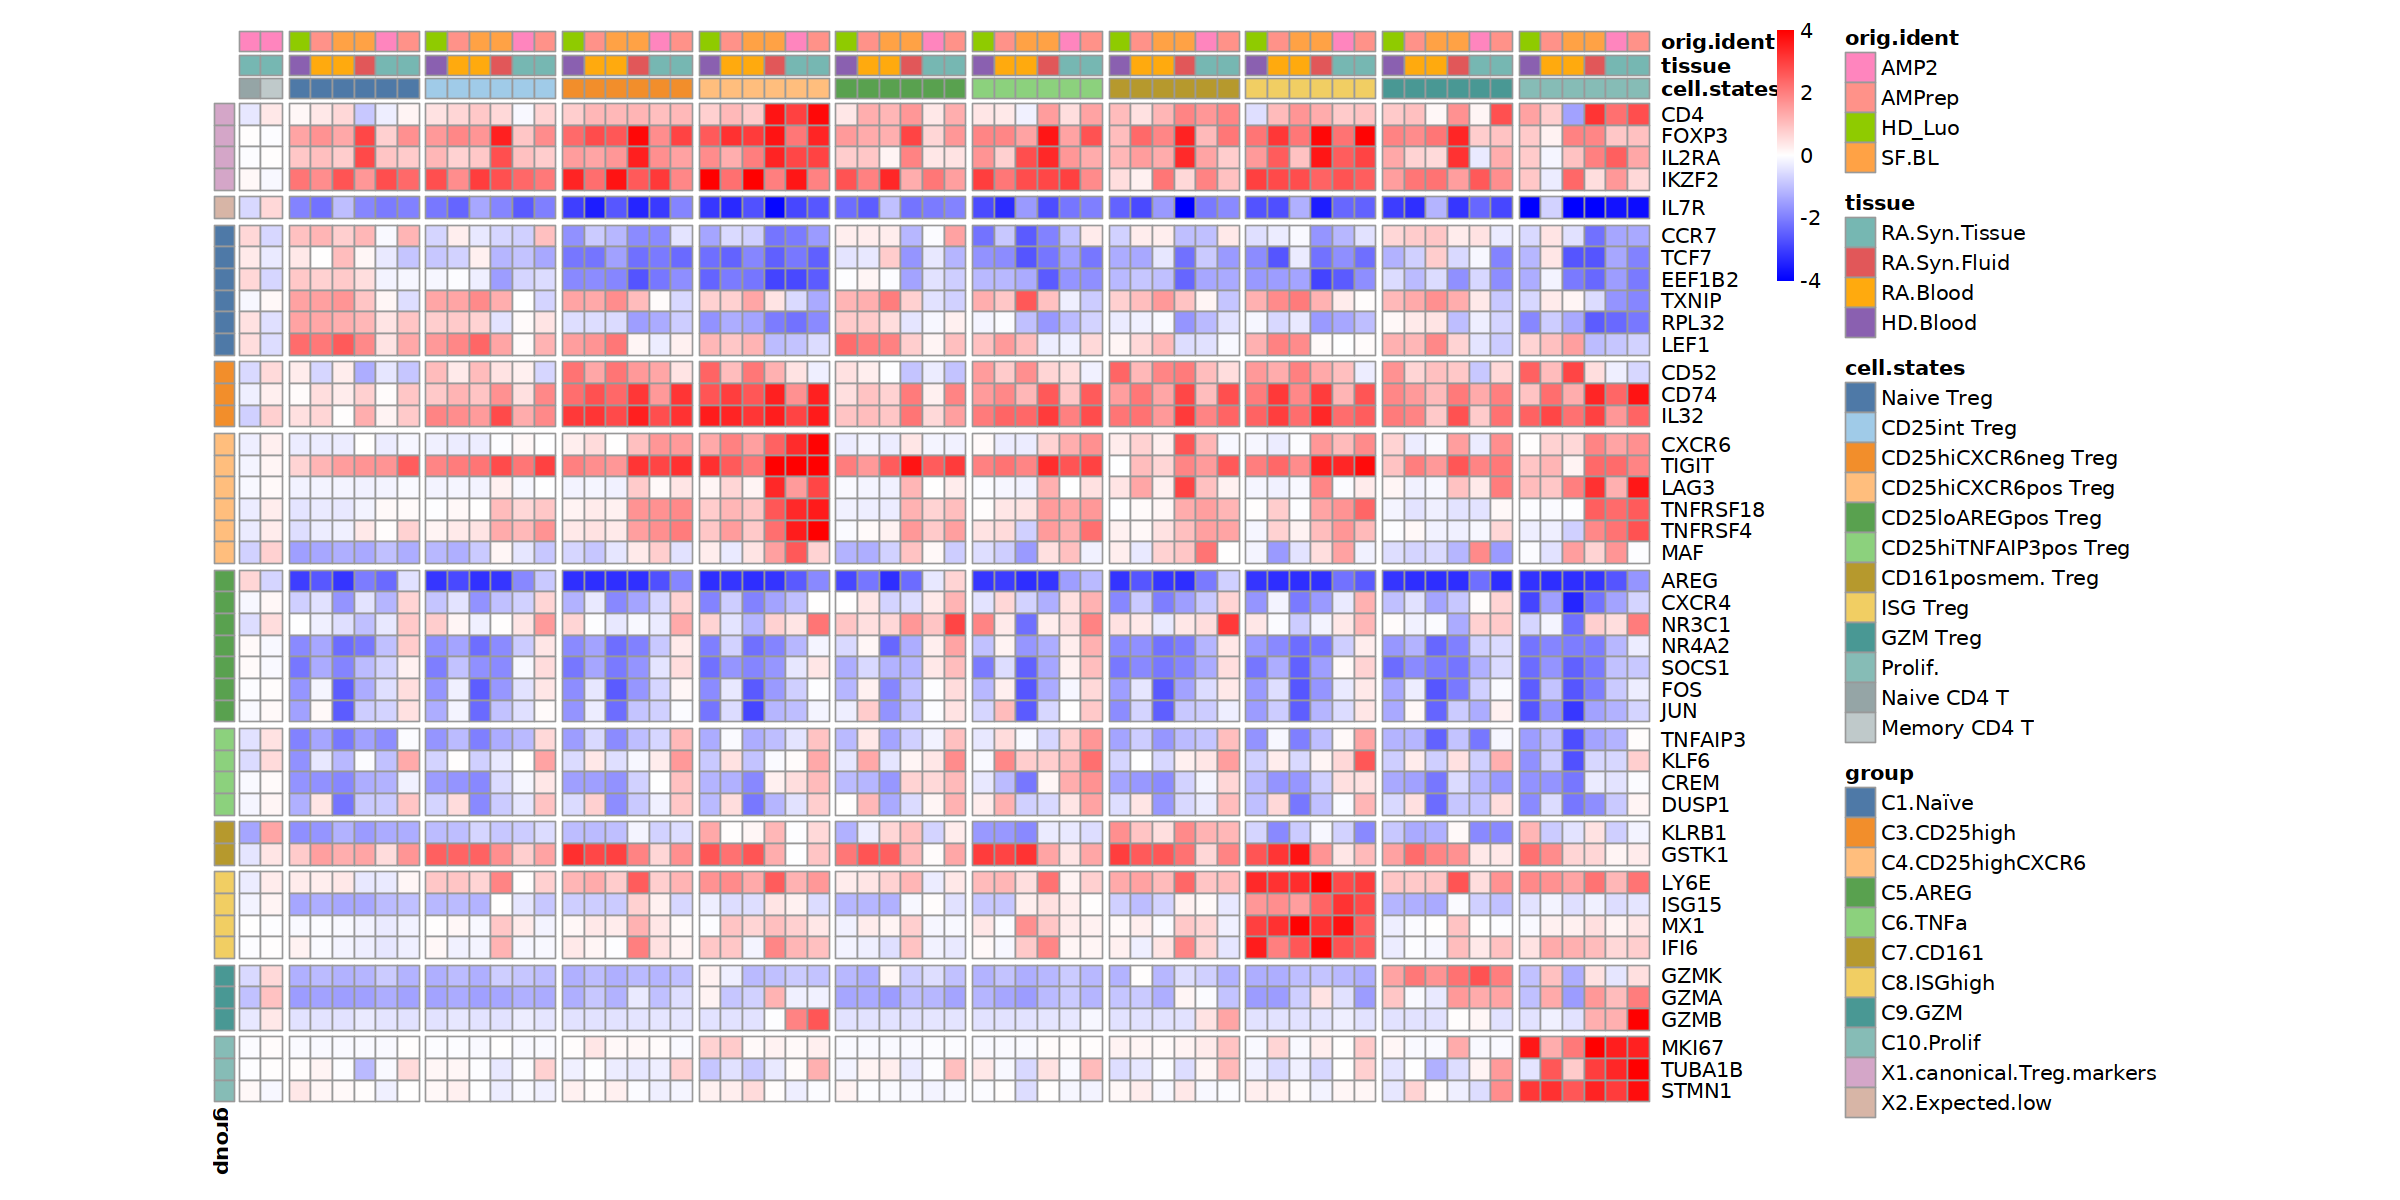

In [63]:
hm

## Check specific genes

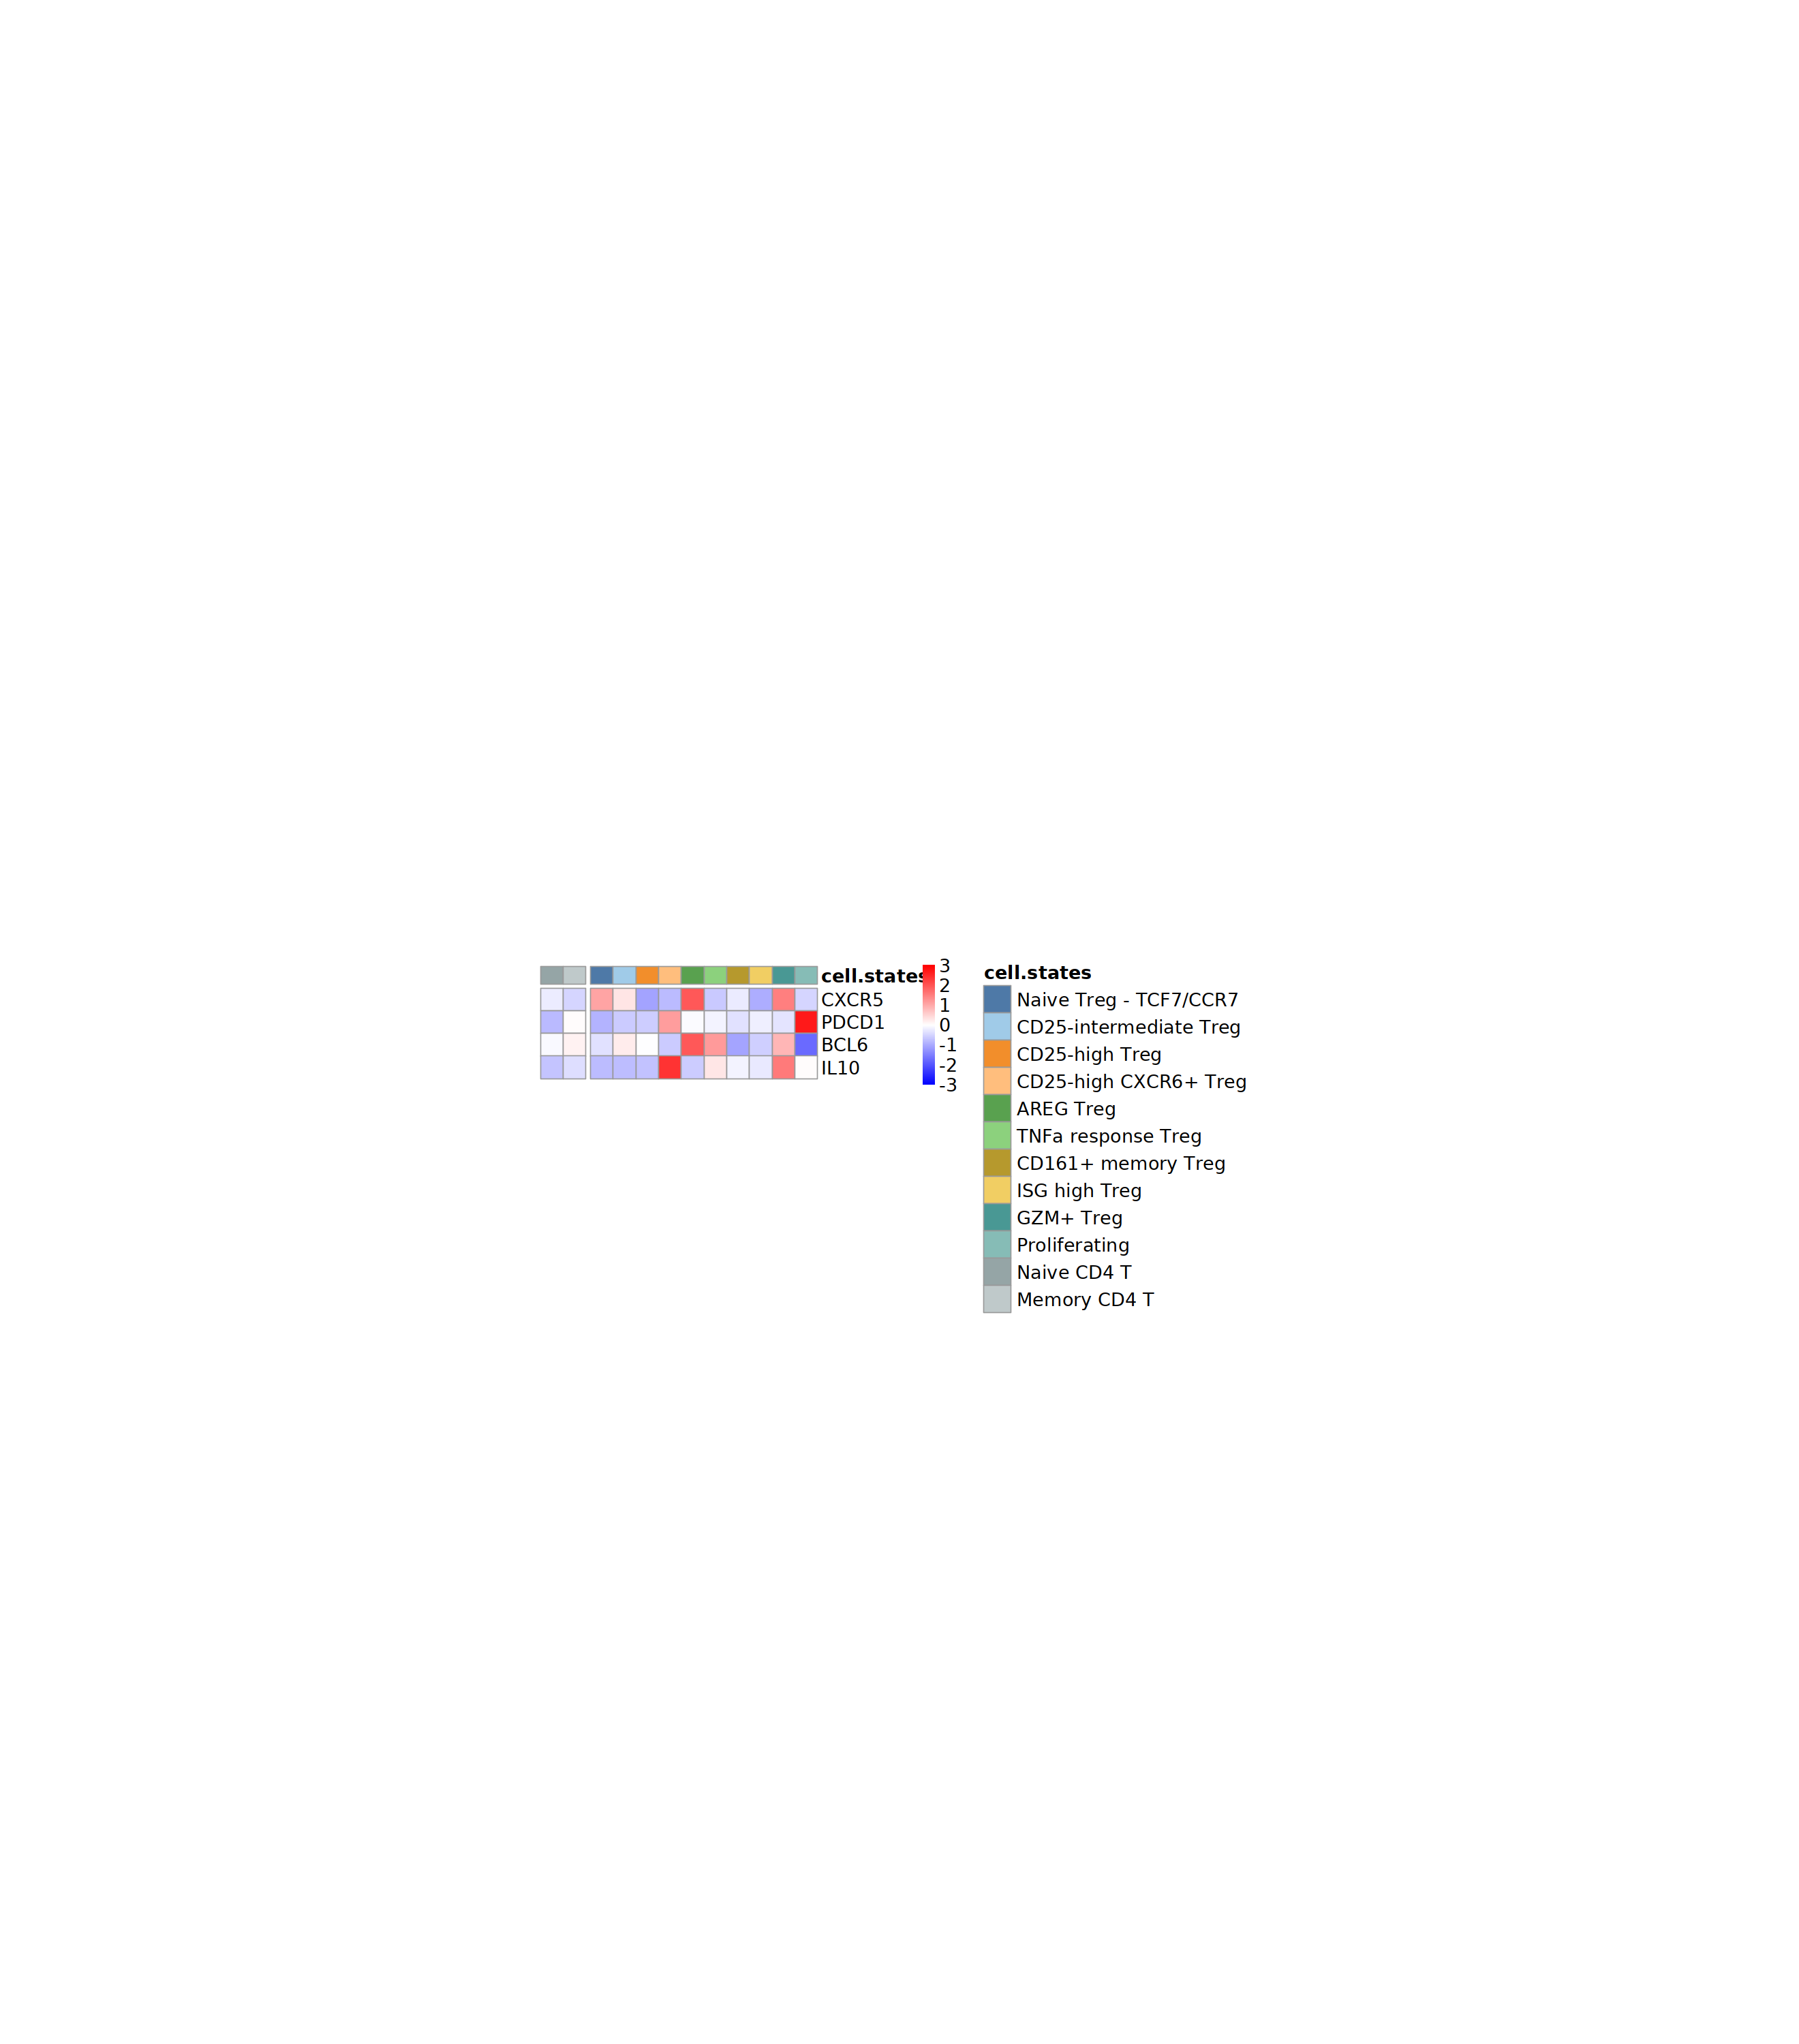

In [63]:
# Check specific genes
g <- c("CXCR5", "PDCD1", "BCL6", "IL10")

organize.samples <- collapsed.counts.small$meta_data %>% arrange(cell.states) %>% select(cell.states)

dat2plot <- collapsed.counts.small$exprs_norm[g, rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states)
rownames(organize.samples) <- paste0(organize.samples$cell.states)

organize.genes <- markers.p 
colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=20, cellwidth=20,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), 
         annotation_color = cell.state.colors,
        fontsize=16)


## Check IFN signature accross tissues

In [157]:
isg <- read.csv("/data/brennerlab/Shani/projects/Treg/analysis/ISG_gene_list.csv")$gene
isg

[1] "IL2RA"   "IL2RB"   "IL2RG"   "FOXP3"   "IKZF2"   "TLR5"    "OAS1"   
 [8] "MX1"     "IFI6"    "IFI44"   "IFIT1"   "USP15"   "EIF2AK2" "IFI27"  
[15] "IFITM3"  "OASL"    "USP18"   "IFIT2"   "IFIT3"   "OAS2"    "OAS3"   
[22] "IL15RA"  "CTLA4"   "ENTPD1"  "CD200"   "CREM"    "DUSP2"   "ETV7"   
[29] "HDAC9"   "ID2"     "IGFBP4"  "IGFL2"   "NCDN"    "NMB"     "RDH10"  
[36] "RUNX2"   "SUSD4"   "TOX"     "TOX2"    "FABP5"   "HERC5"   "HERC6"  
[43] "RPS4Y1"  "XIST"

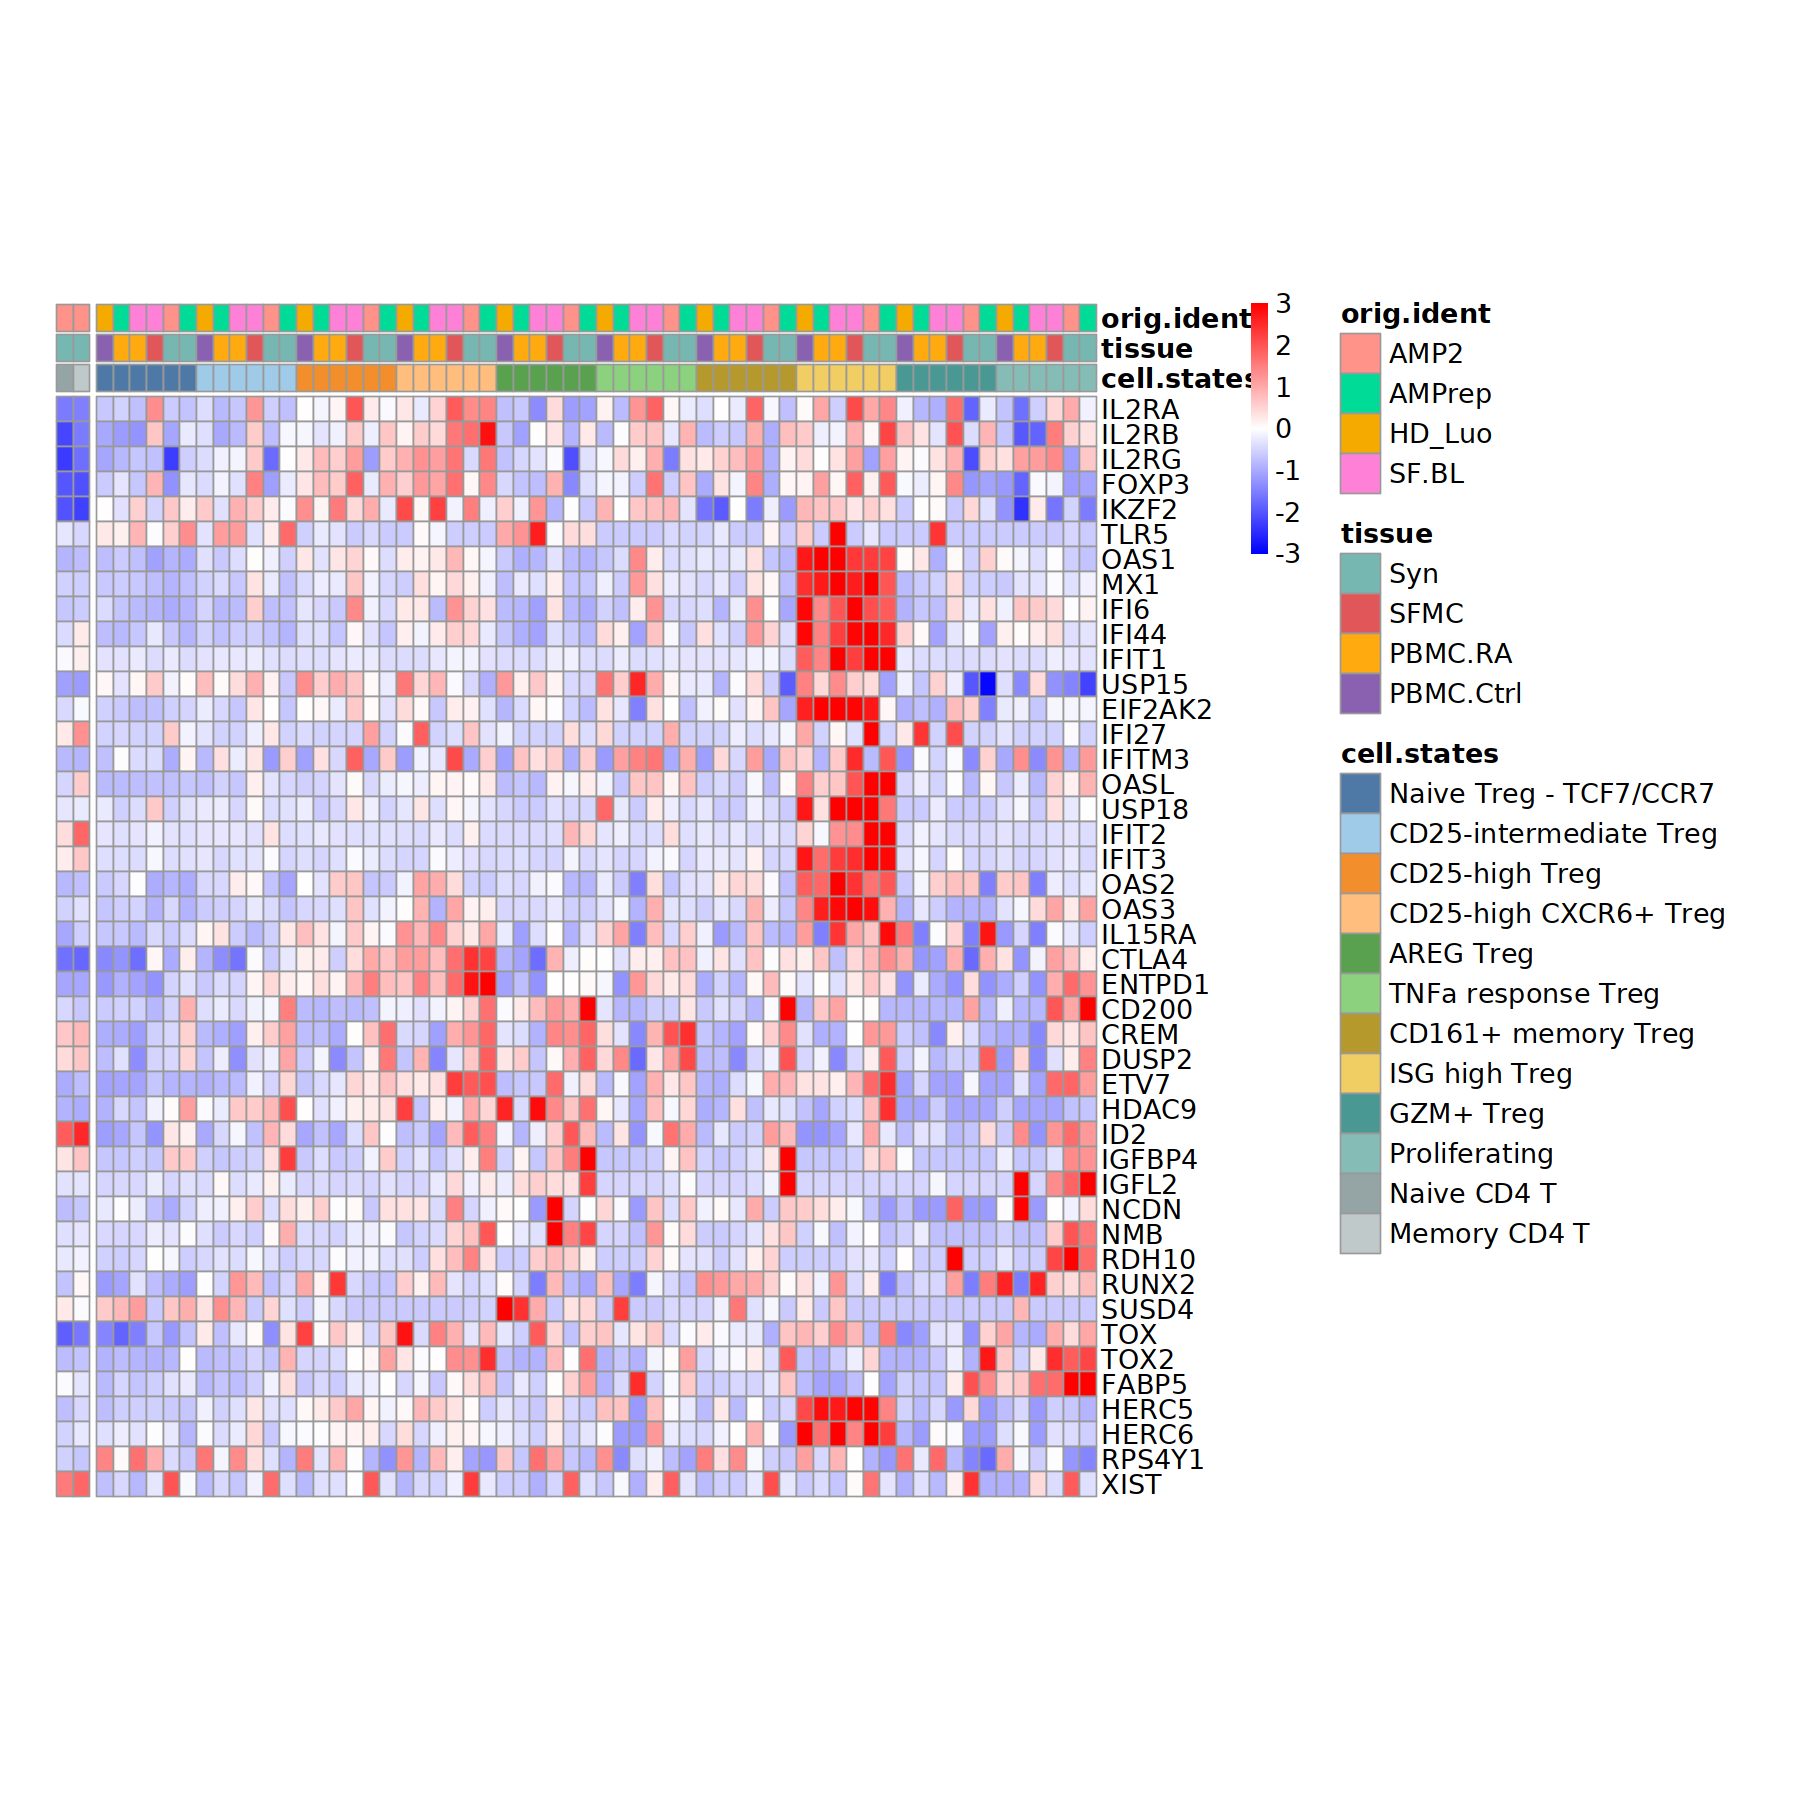

In [169]:
fig.size(15,15)
organize.samples <- collapsed.counts$meta_data %>% arrange(cell.states, tissue) %>% select(cell.states, tissue, orig.ident)

dat2plot <- collapsed.counts$exprs_norm[isg,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)
rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)

organize.genes <- isg 
colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=15, cellwidth=10,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(2), 
         annotation_color = cell.state.colors,
        fontsize=16)


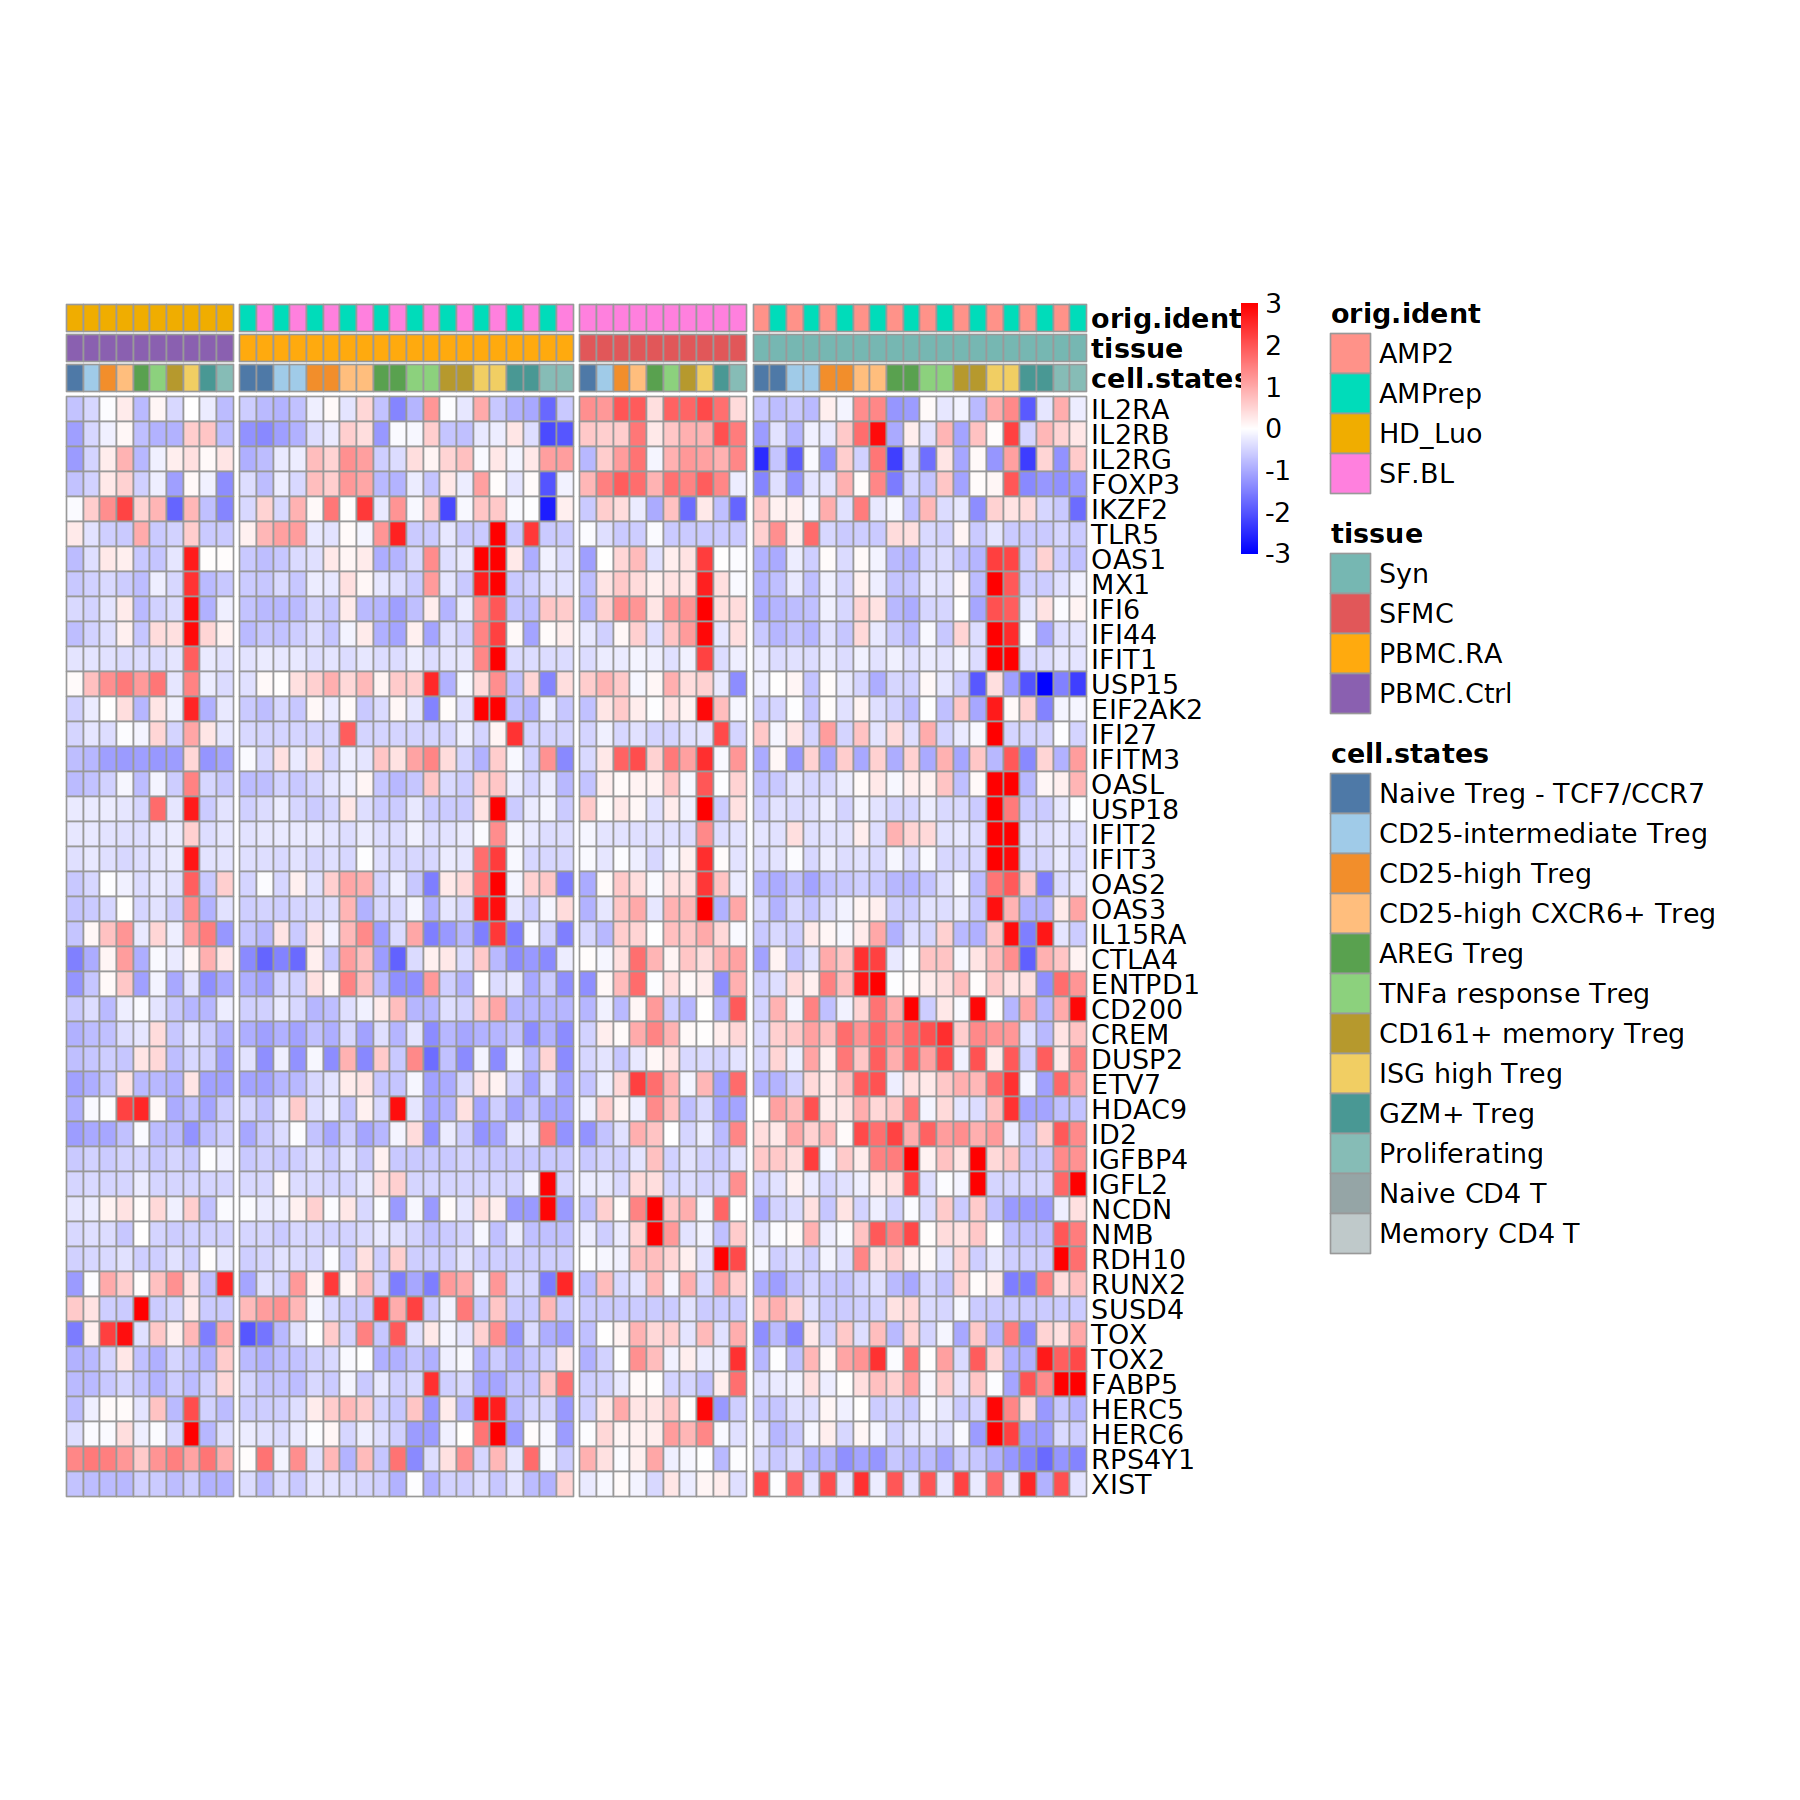

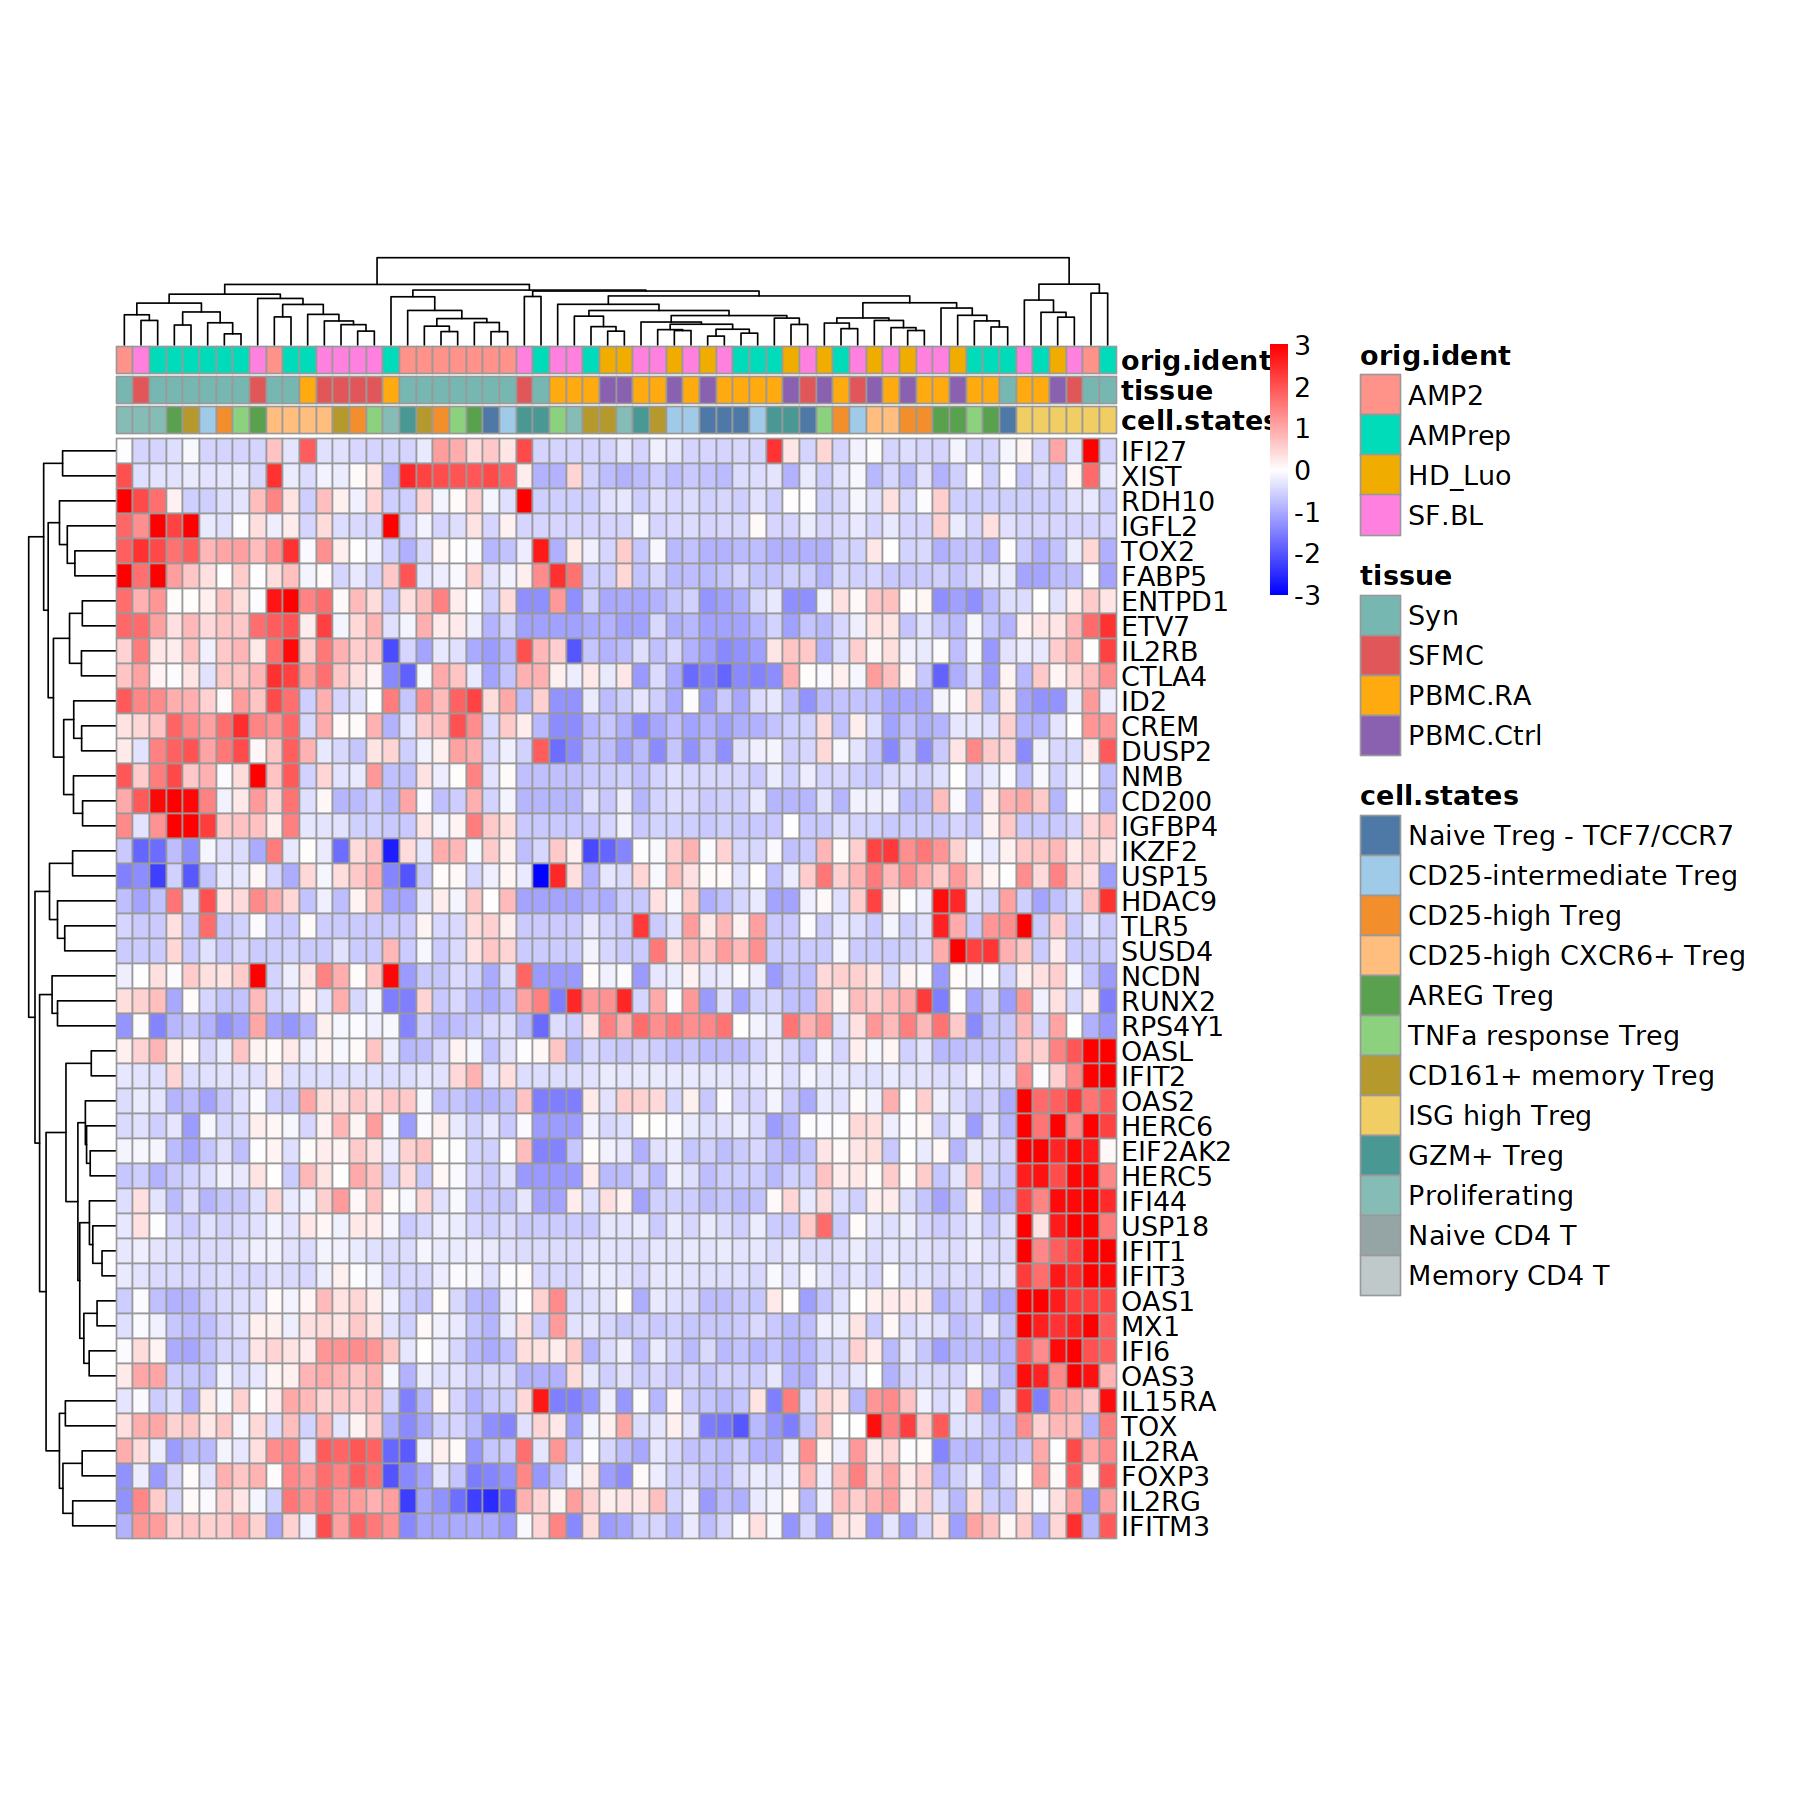

In [176]:
fig.size(15,15)
organize.samples <- collapsed.counts$meta_data %>% arrange(tissue, cell.states) %>% select(cell.states, tissue, orig.ident) %>% 
filter(!(cell.states %in% c("Memory CD4 T", "Naive CD4 T")))

dat2plot <- collapsed.counts$exprs_norm[isg,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)
rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue, "_", organize.samples$orig.ident)

organize.genes <- isg 
colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = F, cellheight=15, cellwidth=10,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(10, 30, 40), 
         annotation_color = cell.state.colors,
        fontsize=16)


pheatmap(dat2plot, scale = "row", cluster_cols = T, cluster_rows = T, cellheight=15, cellwidth=10,
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = F, annotation_col = organize.samples,
         gaps_col = c(10, 30, 40), 
         annotation_color = cell.state.colors,
        fontsize=16)


In [183]:
merged <- AddModuleScore(merged, features = list(isg))
merged$Cluster1 %>% head

BRI-401_AAACGCTCAATACCCA BRI-401_AAAGGATCACACACGC BRI-401_AACCAACCAGCTCTGG 
            0.0823853340             0.1017377304            -0.0009599034 
BRI-401_ACCGTTCTCTCTGCCA BRI-401_AGGATCTCACCCTAGG BRI-401_AGGTAGGGTCGTACTA 
           -0.1174091534            -0.0481530092            -0.0059705636

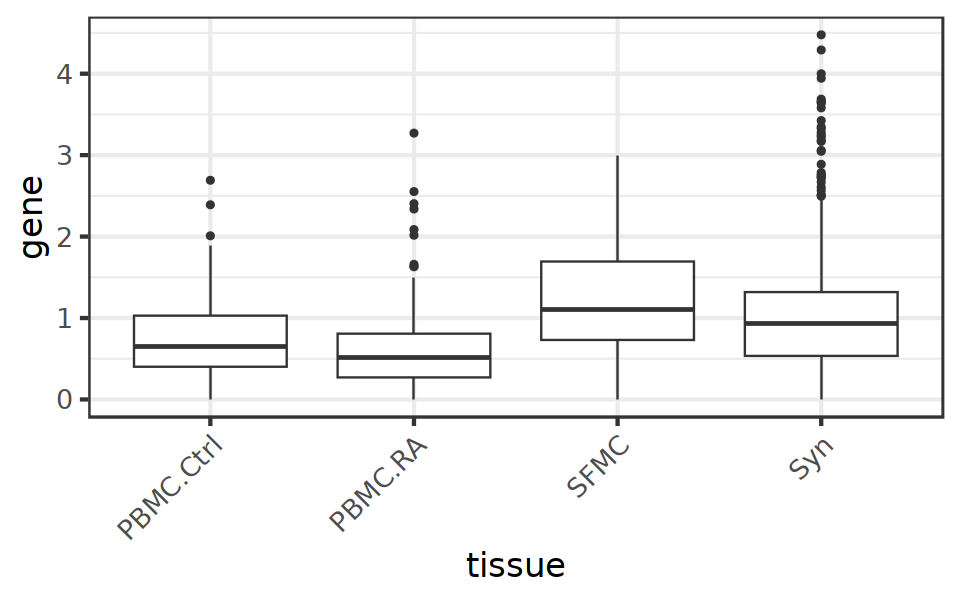

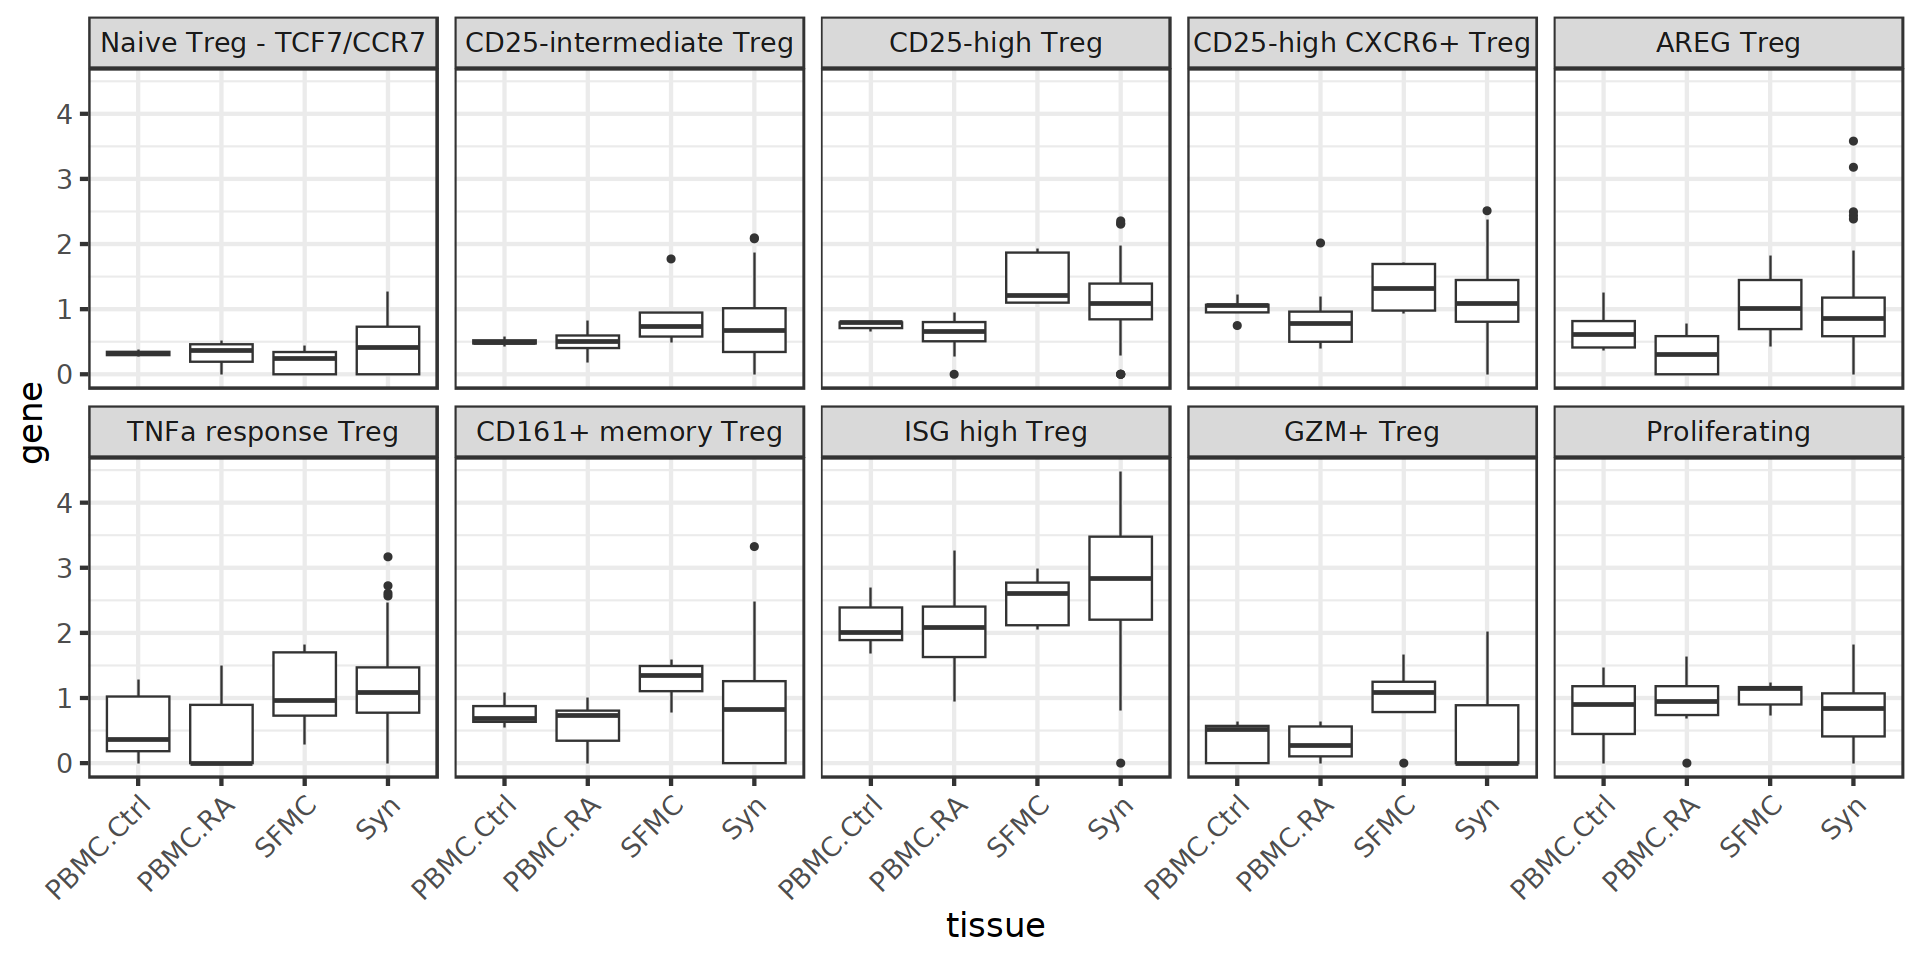

Warning message:
“There were 98 warnings in `summarise()`.
The first warning was:
ℹ In argument: `mean.gene = mean(gene)`.
ℹ In group 1: `donorID = "10021671"`, `tissue = "PBMC.RA"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 97 remaining warnings.”
`summarise()` has grouped output by 'donorID'. You can override using the
`.groups` argument.
Warning message:
“Removed 98 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


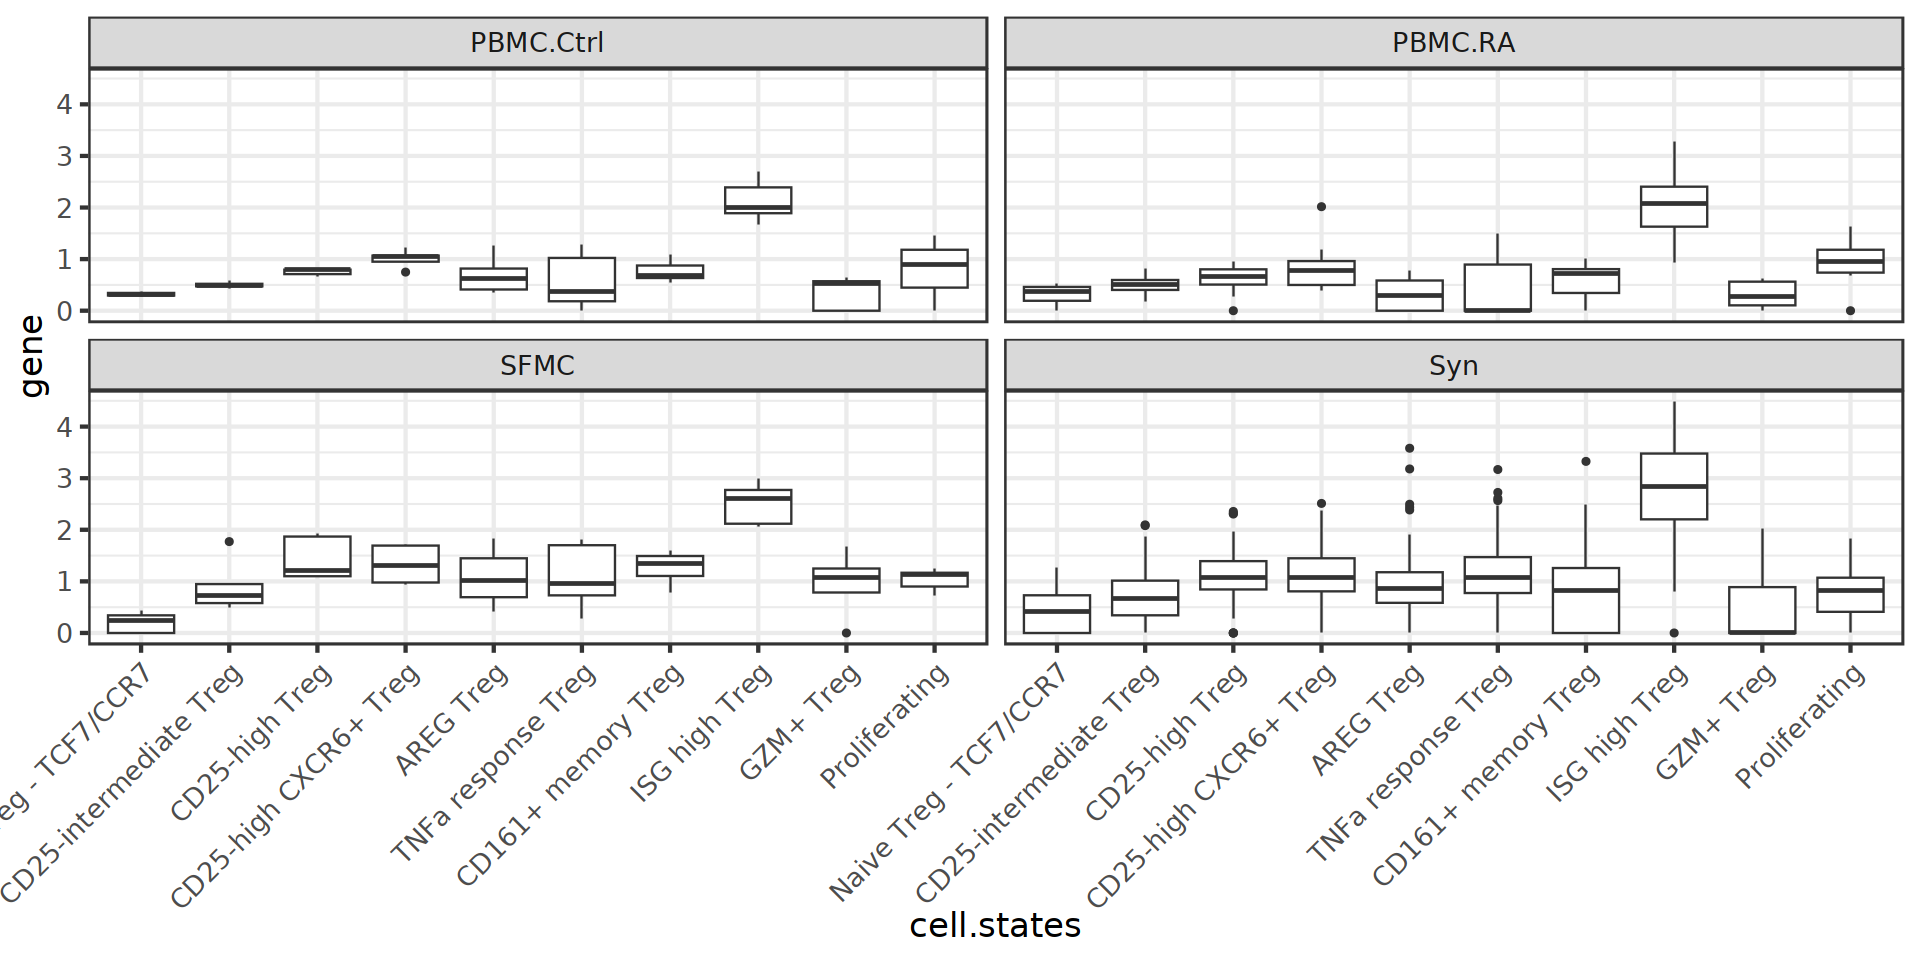

Warning message:
“There were 678 warnings in `summarise()`.
The first warning was:
ℹ In argument: `mean.gene = mean(gene)`.
ℹ In group 1: `cell.states = Naive CD4 T`, `donorID = NA`, `tissue = "Syn"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 677 remaining warnings.”
`summarise()` has grouped output by 'cell.states', 'donorID'. You can override
using the `.groups` argument.
Warning message:
“Removed 678 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message in max(f):
“no non-missing arguments to max; returning -Inf”
ERROR while rich displaying an object: Error in `geom_boxplot()`:
! Problem while computing stat.
ℹ Error occurred in the 1st layer.
Caused by error in `seq_len()`:
! argument must be coercible to non-negative integer

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimety

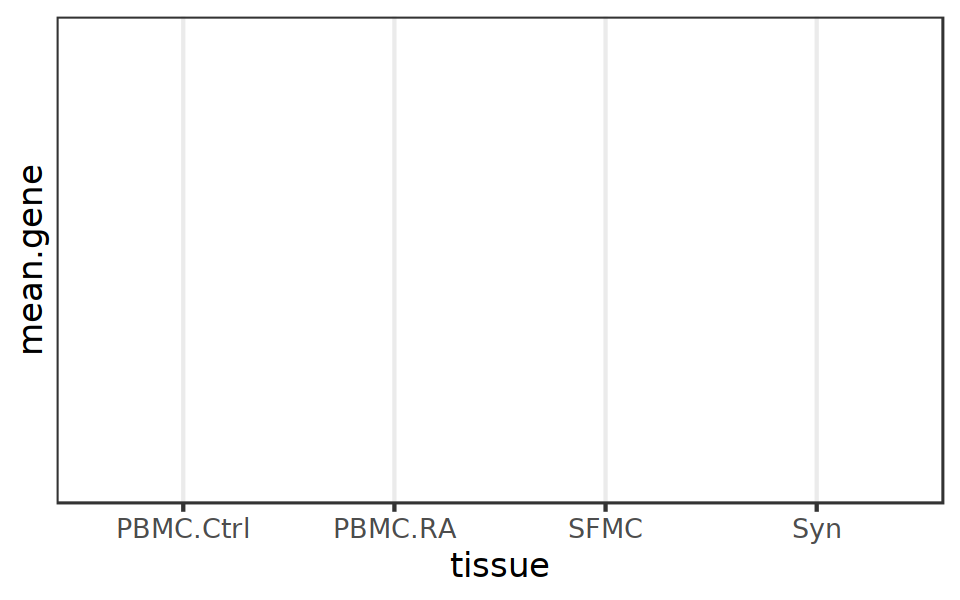

In [184]:
fig.size(5, 8)
merged <- AddModuleScore(merged, features = list(isg))
g <- "ISG15"
# collapsed.counts <- presto::collapse_counts(merged@assays$RNA@counts, 
#                         merged@meta.data, 
#                         c("cell.states", "donorID", "tissue"))
dat.plot <- collapsed.counts$meta_data %>% tibble::rownames_to_column() %>% 
    left_join(as.data.frame(collapsed.counts$exprs_norm[g,]) %>% tibble::rownames_to_column(), by = c("rowname" ="rowname")) %>% 
    tibble::column_to_rownames("rowname") %>% 
    rename(gene = 'collapsed.counts$exprs_norm[g, ]')
dat.plot%>% 
ggplot(aes(x = tissue, y = gene)) + geom_boxplot()+ theme_bw(base_size = 20) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

fig.size (8, 16)

dat.plot%>% 
ggplot(aes(x = tissue, y = gene)) + geom_boxplot() + facet_wrap(~cell.states, nrow = 2) + theme_bw(base_size = 20)+ 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

dat.plot%>% 
ggplot(aes(x = cell.states, y = gene)) + geom_boxplot() + facet_wrap(~tissue, nrow = 2)+ theme_bw(base_size = 20) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

fig.size(5, 8)

dat.plot <- FetchData(merged, vars = c(g, "cell.states", "donorID", "tissue"), layer = "data") 
# dat.plot %>% head
dat.plot %>% 
        group_by(donorID, tissue) %>% summarise(mean.gene = mean(gene))%>% 
        ggplot(aes(x = tissue, y = mean.gene)) + geom_boxplot() +
            theme(axis.text.x = element_text(angle = 45, hjust = 1)) +theme_bw(base_size = 20)

fig.size (8, 16)
dat.plot %>%  
        group_by(cell.states, donorID, tissue) %>% summarise(mean.gene = mean(gene)) %>% 
        ggplot(aes(x = tissue, y = mean.gene)) + geom_boxplot() + facet_wrap(~cell.states) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + theme_bw(base_size = 20)

In [57]:
merged

An object of class Seurat 
38406 features across 52040 samples within 3 assays 
Active assay: RNA (38224 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ADT, HTO

In [95]:
amp.subset@meta.data%>% head
merged@meta.data %>% head

orig.ident nCount_RNA nFeature_RNA sample 
BRI-401_AAACCCAGTACTTCCC BRI-401    5900       1547         BRI-401
BRI-401_AAACGAACACACGGTC BRI-401    8042       1915         BRI-401
BRI-401_AAAGTCCCACTGTGTA BRI-401    5316       1326         BRI-401
BRI-401_AAAGTCCTCATCCCGT BRI-401    6848       1626         BRI-401
BRI-401_AAAGTGATCCGACATA BRI-401    5761       1598         BRI-401
BRI-401_AACAAAGGTACAAACA BRI-401    5730       1561         BRI-401
                         cluster                 cell_type donor   fibro
BRI-401_AAACCCAGTACTTCCC T-4: CD4+ naive         T cell    BRI-401 FALSE
BRI-401_AAACGAACACACGGTC T-6: CD4+ memory        T cell    BRI-401 FALSE
BRI-401_AAAGTCCCACTGTGTA T-4: CD4+ naive         T cell    BRI-401 FALSE
BRI-401_AAAGTCCTCATCCCGT T-4: CD4+ naive         T cell    BRI-401 FALSE
BRI-401_AAAGTGATCCGACATA T-4: CD4+ naive         T cell    BRI-401 FALSE
BRI-401_AACAAAGGTACAAACA T-1: CD4+ CD161+ memory T cell    BRI-401 FALSE
                         Tfilter nUMI ⋯ age sex    treatment CDAI
BRI-401_AAACCCAGTACTTCCC TRUE    5900 ⋯ 77  Female Naïve     15  
BRI-401_AAACGAACACACGGTC TRUE    8042 ⋯ 77  Female Naïve     15  
BRI-401_AAAGTCCCACTGTGTA TRUE    5316 ⋯ 77  Female Naïve     15  
BRI-401_AAAGTCCTCATCCCGT TRUE    6848 ⋯ 77  Female Naïve     15  
BRI-401_AAAGTGATCCGACATA TRUE    5761 ⋯ 77  Female Naïve     15  
BRI-401_AACAAAGGTACAAACA TRUE    5730 ⋯ 77  Female Naïve     15  
                         disease.duration tissue.type krenn subject_id AMP2   
BRI-401_AAACCCAGTACTTCCC 2.1              Biopsy      2.33  300-0302   BRI-401
BRI-401_AAACGAACACACGGTC 2.1              Biopsy      2.33  300-0302   BRI-401
BRI-401_AAAGTCCCACTGTGTA 2.1              Biopsy      2.33  300-0302   BRI-401
BRI-401_AAAGTCCTCATCCCGT 2.1              Biopsy      2.33  300-0302   BRI-401
BRI-401_AAAGTGATCCGACATA 2.1              Biopsy      2.33  300-0302   BRI-401
BRI-401_AACAAAGGTACAAACA 2.1              Biopsy      2.33  300-0302   BRI-401
                         Syn   
BRI-401_AAACCCAGTACTTCCC Biopsy
BRI-401_AAACGAACACACGGTC Biopsy
BRI-401_AAAGTCCCACTGTGTA Biopsy
BRI-401_AAAGTCCTCATCCCGT Biopsy
BRI-401_AAAGTGATCCGACATA Biopsy
BRI-401_AACAAAGGTACAAACA Biopsy

orig.ident             nCount_RNA nFeature_RNA
BRI-401_AAACGCTCAATACCCA_1 TNFa response Treg      4980      1693        
BRI-401_AAAGGATCACACACGC_1 CD25-high Treg          5435      1869        
BRI-401_AACCAACCAGCTCTGG_1 ISG high Treg           6748      2140        
BRI-401_ACCGTTCTCTCTGCCA_1 AREG Treg               6992      2012        
BRI-401_AGGATCTCACCCTAGG_1 TNFa response Treg     12163      3558        
BRI-401_AGGTAGGGTCGTACTA_1 Naive Treg - TCF7/CCR7  5948      1341        
                           sample  cluster_number cluster_name            
BRI-401_AAACGCTCAATACCCA_1 BRI-401 T-8            T-8: CD4+ CD25-high Treg
BRI-401_AAAGGATCACACACGC_1 BRI-401 T-8            T-8: CD4+ CD25-high Treg
BRI-401_AACCAACCAGCTCTGG_1 BRI-401 T-9            T-9: CD4+ CD25-low Treg 
BRI-401_ACCGTTCTCTCTGCCA_1 BRI-401 T-9            T-9: CD4+ CD25-low Treg 
BRI-401_AGGATCTCACCCTAGG_1 BRI-401 T-8            T-8: CD4+ CD25-high Treg
BRI-401_AGGTAGGGTCGTACTA_1 BRI-401 T-9            T-9: CD4+ CD25-low Treg 
                           nCount_ADT nFeature_ADT age sex    ⋯ fibro Tfilter
BRI-401_AAACGCTCAATACCCA_1 1290       46           77  Female ⋯ NA    NA     
BRI-401_AAAGGATCACACACGC_1  352       43           77  Female ⋯ NA    NA     
BRI-401_AACCAACCAGCTCTGG_1  291       50           77  Female ⋯ NA    NA     
BRI-401_ACCGTTCTCTCTGCCA_1  347       46           77  Female ⋯ NA    NA     
BRI-401_AGGATCTCACCCTAGG_1  690       43           77  Female ⋯ NA    NA     
BRI-401_AGGTAGGGTCGTACTA_1  237       45           77  Female ⋯ NA    NA     
                           nUMI nGene percent_mito Tfilter2 tissue.type
BRI-401_AAACGCTCAATACCCA_1 NA   NA    NA           NA       NA         
BRI-401_AAAGGATCACACACGC_1 NA   NA    NA           NA       NA         
BRI-401_AACCAACCAGCTCTGG_1 NA   NA    NA           NA       NA         
BRI-401_ACCGTTCTCTCTGCCA_1 NA   NA    NA           NA       NA         
BRI-401_AGGATCTCACCCTAGG_1 NA   NA    NA           NA       NA         
BRI-401_AGGTAGGGTCGTACTA_1 NA   NA    NA           NA       NA         
                           subject_id AMP2 Syn
BRI-401_AAACGCTCAATACCCA_1 NA         NA   NA 
BRI-401_AAAGGATCACACACGC_1 NA         NA   NA 
BRI-401_AACCAACCAGCTCTGG_1 NA         NA   NA 
BRI-401_ACCGTTCTCTCTGCCA_1 NA         NA   NA 
BRI-401_AGGATCTCACCCTAGG_1 NA         NA   NA 
BRI-401_AGGTAGGGTCGTACTA_1 NA         NA   NA

In [65]:
cxcr6 <- merged@meta.data %>% filter(cell.states %in% c("CD25hiCXCR6+ Treg",
                                                        "CD25hiCXCR6- Treg",
                                                        "CD25int Treg",
                                                        "CD25loAREG+ Treg", 
                                                        "CD25hiTNFAIP3+ Treg", 
                                                        "Naive Treg"))
                                                        
cells <- rownames(cxcr6)
collapsed.counts.cxcr6 <- presto::collapse_counts(merged@assays$RNA@counts[,cells], 
                        cxcr6, 
                        c("cell.states", "tissue"))


collapsed.counts.cxcr6$meta_data %>% head 

CAREFUL: get_norm makes very strong assumptions about data



cell.states         tissue        N    logUMI  
sample_23 CD25hiTNFAIP3+ Treg RA.Syn.Tissue 1115 15.71337
sample_20 CD25hiCXCR6- Treg   RA.Syn.Tissue  605 14.92000
sample_22 CD25loAREG+ Treg    RA.Syn.Tissue 2696 16.49381
sample_18 Naive Treg          RA.Syn.Tissue  404 14.24417
sample_21 CD25hiCXCR6+ Treg   RA.Syn.Tissue  955 15.67353
sample_19 CD25int Treg        RA.Syn.Tissue  307 14.11778

In [73]:
collapsed.counts.cxcr6$meta_data$cell.states <- factor(collapsed.counts.cxcr6$meta_data$cell.states,
                                                       levels = c("CD25hiCXCR6+ Treg",
                                                        "CD25hiCXCR6- Treg",
                                                        "CD25hiTNFAIP3+ Treg",
                                                        "CD25int Treg",
                                                        "CD25loAREG+ Treg", 
                                                        "Naive Treg")
                                                      )                                                        

organize.samples <- collapsed.counts.cxcr6$meta_data %>% tibble::rownames_to_column("rowname") %>% 
group_by(cell.states) %>% mutate(total = sum(N)) %>% ungroup()%>% 
filter(N>0.05*total) %>% filter(tissue %in% c("RA.Syn.Tissue","RA.Syn.Fluid")) %>% 
tibble::column_to_rownames("rowname") %>% 
arrange(cell.states, tissue) %>% select(cell.states, tissue) 

In [75]:
genes4hm <- c("CXCR6", "ICOS", "CTLA4", "TIGIT", "IL10", "TGFB1", 
              "LAG3", "TNFRSF18", "TNFRSF9", "TNFRSF4", "TNFRSF1B", "PDCD1", "ENTPD1")


In [76]:
# organize.samples <- collapsed.counts.cxcr6$meta_data %>% filter(tissue == "Syn" | tissue == "SFMC")%>% 
#                     arrange(CXCR6, tissue) %>% select(CXCR6, tissue) 


dat2plot <- collapsed.counts.cxcr6$exprs_norm[genes4hm,rownames(organize.samples)] 
colnames(dat2plot) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue)
rownames(organize.samples) <- paste0(organize.samples$cell.states, "_", organize.samples$tissue)

colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

p <- pheatmap(dat2plot, scale = "row", cluster_cols = F, cluster_rows = T, cellheight=15, cellwidth=15, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T, 
         annotation_col = organize.samples, 
         annotation_colors = cell.state.colors, fontsize = 12, gaps_col = c(2,4,6,7,8),
        filename = paste(saving.path, "Figures/Fig3A.Heatmap.SuppresiveMarkers.pdf", sep = '')) 

print(p)

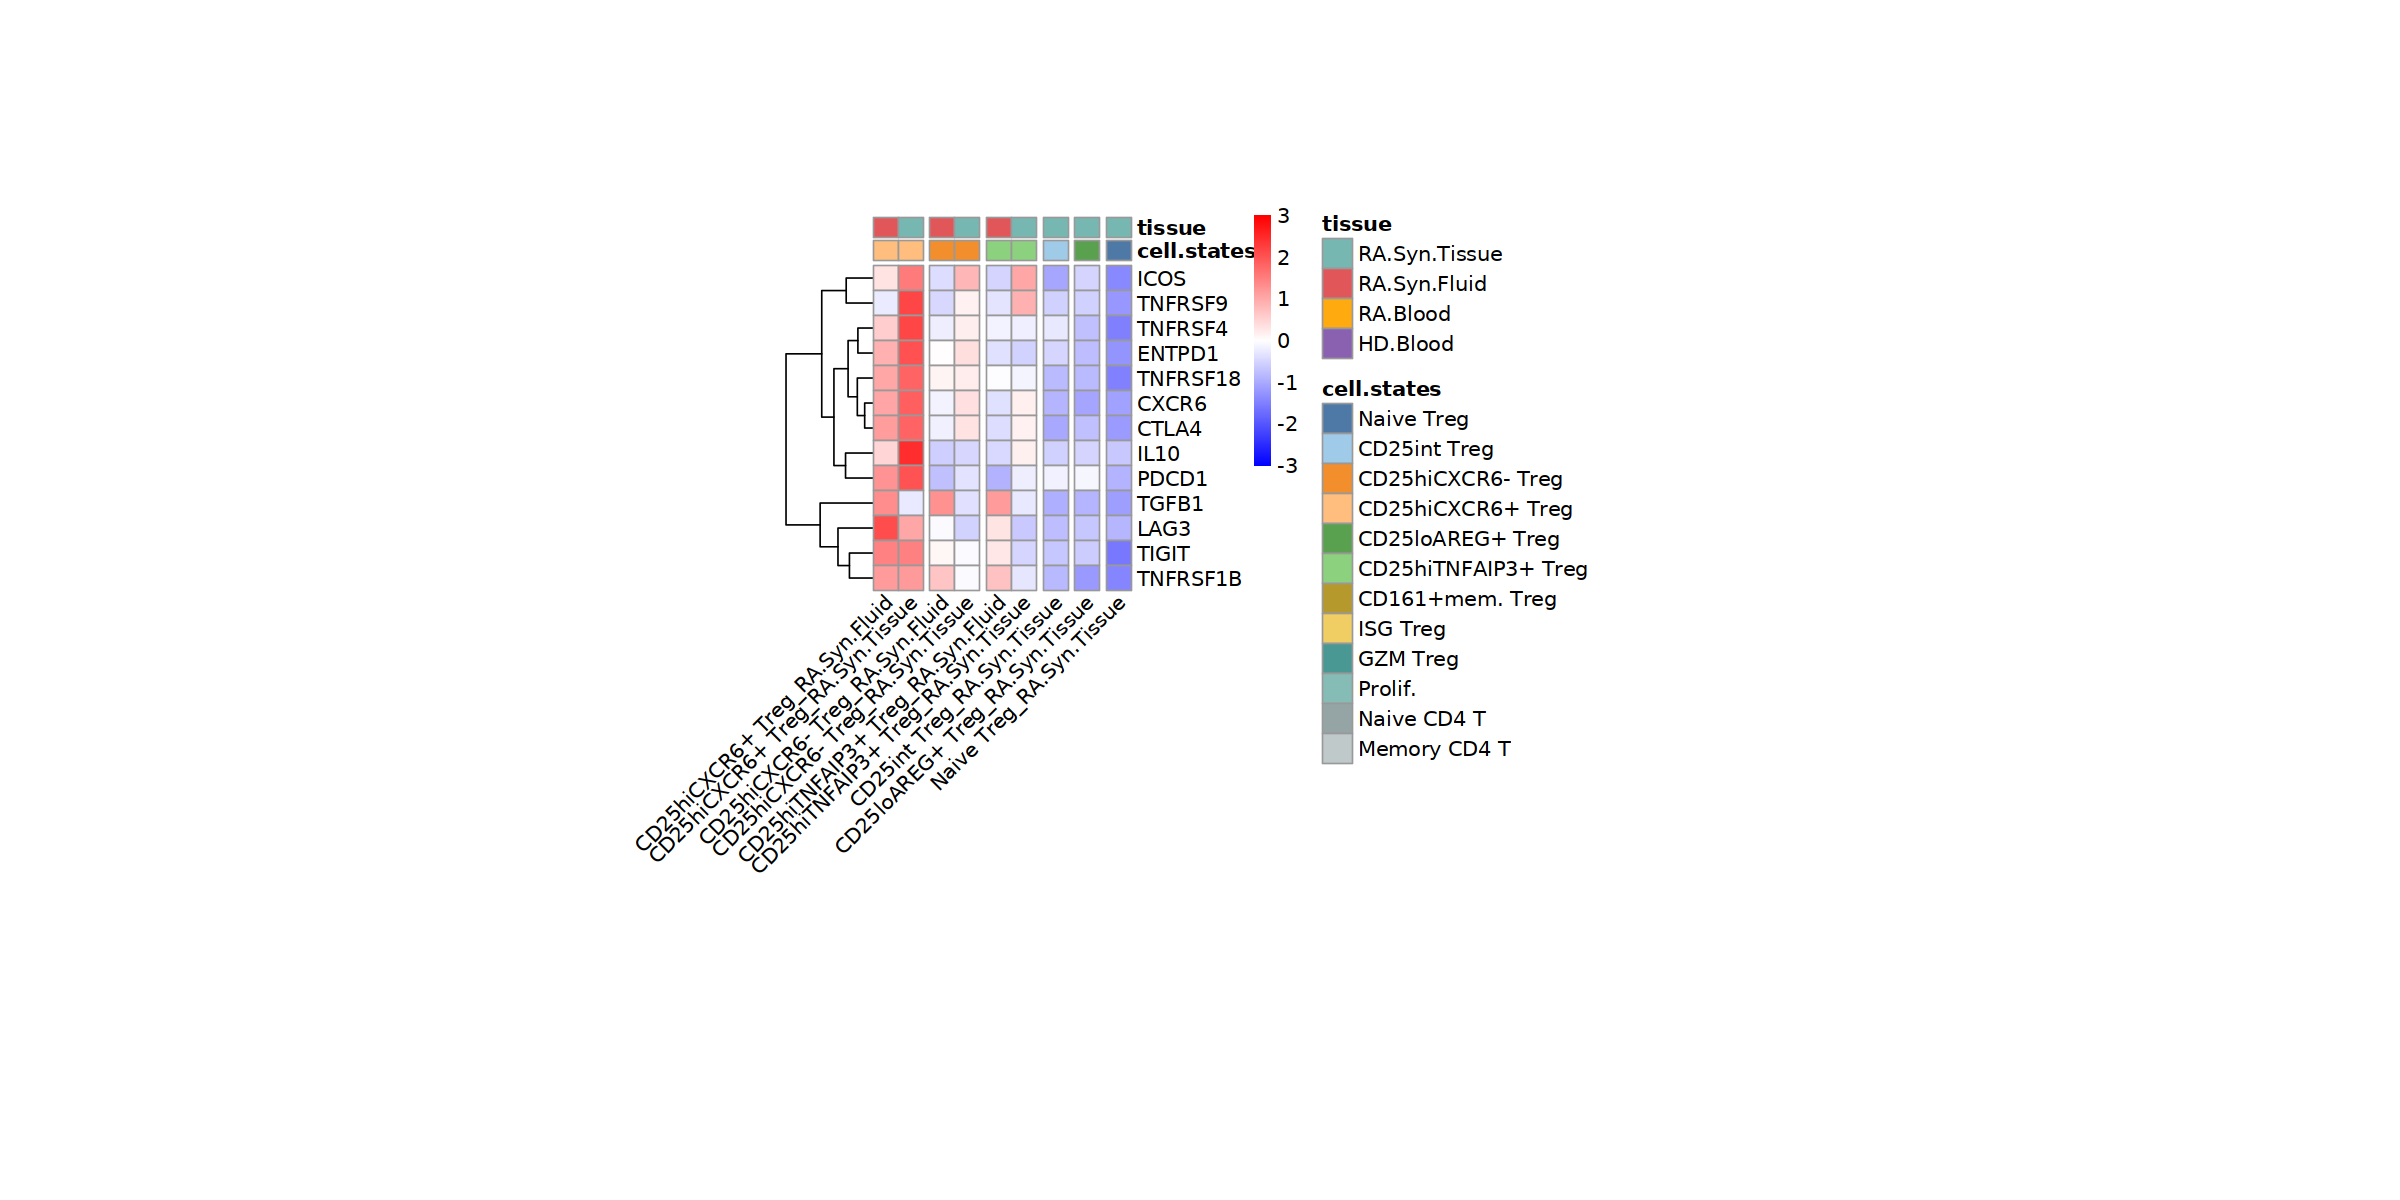

In [77]:
print(p)